

1.   Fairness-aware Hyperparameter Optimization
    *   To achieve the best result, we need to perform hyperparameter optimization (HPO) for the validation accuracy, and hope it generalize well in test set.
    *   However, if we only focus on the performance (validation accuracy) during HPO, the model will be unfair in terms of the equal opportunity.
    * Therefore, we can perform HPO with the consideration of both validation accuracy and validation fairness score.

2.   Generic Resampling
    * In Fairness and Bias in AI literature, resampling is adopted to ensure the balance and fairness of the training dataset.
    * However, it normally sacrifice the performance (i.e. accuracy) because it may put too much emphasis toward the protected race.
    * We propose a generic resampling method for improving the fairness of the model while maintaining the performance.
      1.   Split the training dataset into two portions
      2.   Use the large portion to resample and fit the first tree of LGBM
      3.   Use the small portion to evaluate the fairness score
      4.   Based on the fairness score, we adjust the resampling ratio. For instance, if the model is unfair, we increase the resampling ratio toward the protected group.
      5.  Use the large portion to resample with the new resampling ratio, and fit the second tree of the model.
      6.  Repeat Step 3-5 until we build a whole LGBM
      











In [ ]:
seed = 1111 #21 #42 #123 #1234

In [ ]:
version = 11

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings


warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [ ]:
!pip install --upgrade --quiet optuna
!pip install --upgrade --quiet hpbandster
!pip install --upgrade --quiet statsmodels
!pip install --upgrade --quiet optuna-integration
!pip install --upgrade --quiet ConfigSpace

import optuna
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
import lightgbm as lgb


In [ ]:
import pickle
with open(f"/content/drive/MyDrive/math6912/data/state_CA_cleaned_train_{seed}.pkl", 'rb') as f:
    df = pickle.load(f)
with open(f"/content/drive/MyDrive/math6912/data/state_CA_cleaned_val_{seed}.pkl", 'rb') as f:
    df_val = pickle.load(f)
with open(f"/content/drive/MyDrive/math6912/data/state_CA_cleaned_test_{seed}.pkl", 'rb') as f:
    df_test = pickle.load(f)


In [ ]:
df

,conforming_loan_limit,derived_race,applicant_sex,co-applicant_sex,action_taken,applicant_age,applicant_age_above_62,co-applicant_age,co-applicant_age_above_62,loan_type,loan_purpose,open-end_line_of_credit,loan_amount,loan_to_value_ratio,loan_term,property_value,occupancy_type,total_units,income,debt_to_income_ratio,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units,applicant_credit_score_type,co-applicant_credit_score_type,has_co-applicant
0,C,White,1,2,1,65-74,Yes,65-74,Yes,1,31,1,105000.0,54.040,360.0,315000.0,1,1,56.0,50%-60%,4363,89.04,65800,65.00,523,1175,60,8,9,1
1,C,White,2,1,1,25-34,No,35-44,No,1,2,1,85000.0,63.867,360.0,505000.0,1,1,NaN,NaN,6657,98.66,69300,56.00,491,1626,63,9,9,1
2,C,White,1,4,1,65-74,Yes,NaN,NaN,1,4,1,75000.0,100.000,180.0,695000.0,1,1,35.0,50%-60%,5662,21.34,84100,111.00,1555,2571,47,1,9,0
3,C,White,2,4,0,45-54,No,NaN,NaN,2,1,2,315000.0,56.818,360.0,555000.0,1,1,86.0,45%-<50%,3083,17.42,59700,103.00,1110,2106,30,2,9,0
4,C,White,2,1,1,65-74,Yes,65-74,Yes,1,4,1,125000.0,NaN,300.0,NaN,1,1,NaN,NaN,3463,28.33,81800,107.00,1010,1356,32,9,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390536,C,Black or African American,2,4,0,35-44,No,NaN,NaN,3,32,2,505000.0,89.480,360.0,565000.0,1,1,112.0,41%-<45%,5818,89.05,116800,116.59,1089,1266,16,3,9,0
390537,C,Black or African American,1,4,1,35-44,No,NaN,NaN,1,4,1,55000.0,79.997,420.0,435000.0,1,1,102.0,36%-<41%,2522,54.19,72600,164.40,379,695,11,2,9,0
390538,C,Black or African American,2,4,1,35-44,No,NaN,NaN,1,1,2,55000.0,103.600,360.0,435000.0,1,1,70.0,45%-<50%,5615,74.05,147900,66.19,976,1594,64,2,9,0
390539,C,Black or African American,1,1,1,65-74,Yes,65-74,Yes,1,32,2,335000.0,65.790,360.0,505000.0,1,1,104.0,41%-<45%,5848,98.24,98200,65.36,769,1742,74,9,3,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390541 entries, 0 to 390540
Data columns (total 30 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   conforming_loan_limit              390541 non-null  category
 1   derived_race                       390541 non-null  category
 2   applicant_sex                      390541 non-null  category
 3   co-applicant_sex                   390541 non-null  category
 4   action_taken                       390541 non-null  int64   
 5   applicant_age                      390282 non-null  category
 6   applicant_age_above_62             390282 non-null  category
 7   co-applicant_age                   186705 non-null  category
 8   co-applicant_age_above_62          186705 non-null  category
 9   loan_type                          390541 non-null  category
 10  loan_purpose                       390541 non-null  category
 11  open-end_line_of_credit   

# Data Preprocessing

Load the preprocessing module which involve the label encoder to transform the categorical features and oridinal features

In [ ]:
from sklearn.preprocessing import LabelEncoder
with open(f"/content/drive/MyDrive/math6912/preprocessing/data_preprocessing_{seed}_{version}.pkl", 'rb') as f:
    save_dict = pickle.load(f)

In [ ]:
le = save_dict['le']
selected_cols = save_dict['cols']
categorical_cols = save_dict['categorical_cols']

In [ ]:
df = df[selected_cols]
df_val = df_val[selected_cols]
df_test = df_test[selected_cols]

In [ ]:
le

{'derived_race': LabelEncoder(),
 'applicant_sex': LabelEncoder(),
 'applicant_age_above_62': LabelEncoder(),
 'loan_type': LabelEncoder(),
 'loan_purpose': LabelEncoder(),
 'open-end_line_of_credit': LabelEncoder(),
 'applicant_credit_score_type': LabelEncoder()}

In [ ]:

# prompt: get all the ordered categorical features

ordered_categorical_features = []
for col in df.select_dtypes(include=['category']).columns.tolist():
    if df_test[col].cat.ordered:
        ordered_categorical_features.append(col)
print(ordered_categorical_features)

# prompt: get the categorical columns excluded ordered

_categorical_features = [col for col in categorical_cols if col not in ordered_categorical_features]
_categorical_features

# prompt: labelencoder for categorical columns

print("Categorical")
for col in _categorical_features:
    print(col)
    df[col] = le[col].transform(df[col])
    df[col] = df[col].astype('category')
    df_val[col] = le[col].transform(df_val[col])
    df_val[col] = df_val[col].astype('category')
    df_test[col] = le[col].transform(df_test[col])
    df_test[col] = df_test[col].astype('category')
    # X_test[col] = le.fit_transform(X_test[col])
    # X_test[col] = X_test[col].astype('category')
print("="*50)
print("Ordinal")
for col in ordered_categorical_features:
    print(col)
    df[col] = df[col].cat.codes
    df_val[col] = df_val[col].cat.codes
    df_test[col] = df_test[col].cat.codes


categorical_cols = df.select_dtypes(include=['category']).columns.tolist()
print(categorical_cols)

['total_units', 'debt_to_income_ratio']
Categorical
derived_race
applicant_sex
applicant_age_above_62
loan_type
loan_purpose
open-end_line_of_credit
applicant_credit_score_type
Ordinal
total_units
debt_to_income_ratio
['derived_race', 'applicant_sex', 'applicant_age_above_62', 'loan_type', 'loan_purpose', 'open-end_line_of_credit', 'applicant_credit_score_type']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390541 entries, 0 to 390540
Data columns (total 16 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   derived_race                       390541 non-null  category
 1   applicant_sex                      390541 non-null  category
 2   applicant_age_above_62             390541 non-null  category
 3   loan_type                          390541 non-null  category
 4   loan_purpose                       390541 non-null  category
 5   open-end_line_of_credit            390541 non-null  category
 6   loan_amount                        390541 non-null  float64 
 7   loan_to_value_ratio                368794 non-null  float64 
 8   loan_term                          384652 non-null  float64 
 9   property_value                     377456 non-null  float64 
 10  total_units                        390541 non-null  int8    
 11  income                    

# Objective functions
We define objective functions and other helper functions.


For the performance metrics, we have accuracy, true positive rate, true negative rate, balance accuracy and confusion matrix.



For the fairness metrics, we have equal opportunity difference and ratio, equal odds difference, and demographic disparity difference.



For equal opportunity difference and ratio,

EOD = tpr(race1) - tpr(race2)

EOR = tpr(race1)/tpr(race2)


For equal odds difference,

EODD = abs(tpr(race1) - tpr(race2)) + abs(tnr(race1) - tnr(race2))

For demographic disparity difference,

DPD = approval rate of race1 - approval rate of race2

In [ ]:
def acc(model, X, y, m_cols=None, thrsh=[0.5, 0.5]):
    acc = 0
    n = 0
    for i in range(len(X)):
        _X = X[i]
        _y = y[i]
        if m_cols is None:
            _X = _X
        else:
            _X = _X[m_cols]
        y_pred = model.predict(_X) > thrsh[i]
        _acc = (y_pred == _y).sum()
        acc += _acc
        n += len(_y)
    return acc / n


In [ ]:
def eod(model, X, y, m_cols=None, thrsh=[0.5, 0.5]):
    tpr_w, _ = tpr_fn(model, X[0], y[0], m_cols=m_cols, thrsh=thrsh[0])
    tpr_b, _ = tpr_fn(model, X[1], y[1], m_cols=m_cols, thrsh=thrsh[1])
    return tpr_w - tpr_b, np.min([tpr_w, tpr_b])/np.max([tpr_w, tpr_b])


In [ ]:
def eodd(model, X, y, m_cols=None, thrsh=[0.5, 0.5]):
    tpr_w, _ = tpr_fn(model, X[0], y[0], m_cols=m_cols, thrsh=thrsh[0])
    tpr_b, _ = tpr_fn(model, X[1], y[1], m_cols=m_cols, thrsh=thrsh[1])
    tnr_w, _ = tnr_fn(model, X[0], y[0], m_cols=m_cols, thrsh=thrsh[0])
    tnr_b, _ = tnr_fn(model, X[1], y[1], m_cols=m_cols, thrsh=thrsh[1])
    return np.abs(eod) + np.abs(tnr_w - tnr_b)


In [ ]:
def dpd(model, X, y, m_cols=None, thrsh=[0.5, 0.5]):
    if m_cols is None:
        p_w = (model.predict(X[0]) > thrsh[0]).mean()
        p_b = (model.predict(X[1]) > thrsh[1]).mean()
    else:
        p_w = (model.predict(X[0][m_cols]) > thrsh[0]).mean()
        p_b = (model.predict(X[1][m_cols]) > thrsh[1]).mean()
    return p_w - p_b

In [ ]:
def tpr_fn(model, X, y, m_cols=None, thrsh=0.5):
    if m_cols is None:
        _X = X
    else:
        _X = X[m_cols]
    y_thrsh = (model.predict(_X) > thrsh).astype(int)
    _y = y
    tp = (y_thrsh[_y==1] == 1)
    tpr = tp.sum()/(_y[_y == 1]==1).sum()
    return tpr, tp

In [ ]:
def tnr_fn(model, X, y, m_cols=None, thrsh=0.5):
    if m_cols is None:
        _X = X
    else:
        _X = X[m_cols]
    y_thrsh = (model.predict(_X) > thrsh).astype(int)
    _y = y
    tn = (y_thrsh[_y==0] == 0)
    tnr = tn.sum()/(_y[_y == 0]==0).sum()
    return tnr, tn



In [ ]:
def bacc(model, X, y, m_cols=None, thrsh=[0.5, 0.5]):
    tpr_w, tp_w = tpr_fn(model, X[0], y[0], m_cols=m_cols, thrsh=thrsh[0])
    tpr_b, tp_b = tpr_fn(model, X[1], y[1], m_cols=m_cols, thrsh=thrsh[1])
    tnr_w, tn_w = tnr_fn(model, X[0], y[0], m_cols=m_cols, thrsh=thrsh[0])
    tnr_b, tn_b = tnr_fn(model, X[1], y[1], m_cols=m_cols, thrsh=thrsh[1])
    # print("BACC", tpr_w, tnr_w, tpr_b, tnr_b)
    tpr = (tp_w.sum() + tp_b.sum()) / (tp_w.shape[0] + tp_b.shape[0])
    tnr = (tn_w.sum() + tn_b.sum()) / (tn_w.shape[0] + tn_b.shape[0])
    return (tpr + tnr) / 2

In [ ]:
def confusion_matrix(model, X, y, m_cols=None, thrsh=0.5):
    if m_cols is None:
        _X = X
    else:
        _X = X[m_cols]
    tpr, tp = tpr_fn(model, X, y, m_cols=m_cols, thrsh=thrsh)
    tnr, tn = tnr_fn(model, X, y, m_cols=m_cols, thrsh=thrsh)
    fn = tp.shape[0] - tp.sum()
    fnr = 1 - tpr
    fp = tn.shape[0] - tn.sum()
    fpr = 1 - tnr
    tp = tp.sum()
    tn = tn.sum()
    return tpr, tnr, fpr, fnr, tp, tn, fp, fn


In [ ]:
def objectives(model, X, y, m_cols=None, thrsh=[0.5, 0.5]):
    acc = acc(model, X, y, m_cols=m_cols, thrsh=thrsh)
    dpd = dpd(model, X, y, m_cols=m_cols, thrsh=thrsh)
    # tpr_w, tp_w = tpr_fn(model, X[0], y[0], m_cols=m_cols, thrsh=thrsh[0])
    # tpr_b, tp_b = tpr_fn(model, X[1], y[1], m_cols=m_cols, thrsh=thrsh[1])
    # tnr_w, tn_w = tnr_fn(model, X[0], y[0], m_cols=m_cols, thrsh=thrsh[0])
    # tnr_b, tn_b = tnr_fn(model, X[1], y[1], m_cols=m_cols, thrsh=thrsh[1])
    tpr_w, tnr_w, fpr_w, fnr_w, tp_w, tn_w, fp_w, fn_w = confusion_matrix(model, X[0], y[0], m_cols=m_cols, thrsh=thrsh[0])
    tpr_b, tnr_b, fpr_b, fnr_b, tp_b, tn_b, fp_b, fn_b = confusion_matrix(model, X[1], y[1], m_cols=m_cols, thrsh=thrsh[1])
    tpr = (tp_w.sum() + tp_b.sum()) / (tp_w.shape[0] + tp_b.shape[0])
    tnr = (tn_w.sum() + tn_b.sum()) / (tn_w.shape[0] + tn_b.shape[0])
    bacc = (tpr + tnr) / 2
    eod = tpr_w - tpr_b
    eor = np.min([tpr_w, tpr_b])/np.max([tpr_w, tpr_b])
    eodd = np.abs(eod) + np.abs(tnr_w - tnr_b)


    return acc, bacc, dpd, eod, eor, eodd, tp_w, tp_b, tn_w, tn_b, fp_w, fp_b, fn_w, fn_b


# Data summary

In [ ]:
import numpy as np
index_w = np.where(save_dict['le']['derived_race'].classes_ == 'White')[0][0]
index_w
index_b = np.where(save_dict['le']['derived_race'].classes_ == 'Black or African American')[0][0]
index_b

np.int64(0)

In [ ]:
print(index_w, index_b)

1 0


We seperate the dataset into two for race1 and race2 people.


This will make the computations of metric and resampling faster.

In [ ]:
# Assuming 'action_taken' is your target column
y_train = df['action_taken']
X_train = df.drop('action_taken', axis=1)
X_train_b = X_train[X_train['derived_race'] == index_b]
X_train_w = X_train[X_train['derived_race'] == index_w]
y_train_b = y_train[X_train['derived_race'] == index_b]
y_train_w = y_train[X_train['derived_race'] == index_w]

y_val = df_val['action_taken']
X_val = df_val.drop('action_taken', axis=1)
X_val_b = X_val[X_val['derived_race'] == index_b]
X_val_w = X_val[X_val['derived_race'] == index_w]
y_val_b = y_val[X_val['derived_race'] == index_b]
y_val_w = y_val[X_val['derived_race'] == index_w]

y_test = df_test['action_taken']
X_test = df_test.drop('action_taken', axis=1)
X_test_b = X_test[X_test['derived_race'] == index_b]
X_test_w = X_test[X_test['derived_race'] == index_w]
y_test_b = y_test[X_test['derived_race'] == index_b]
y_test_w = y_test[X_test['derived_race'] == index_w]


In [ ]:
print("Train w: ", y_train_w.value_counts()/len(y_train_w))
print("Train b: ", y_train_b.value_counts()/len(y_train_b))
print("Val w: ", y_val_w.value_counts()/len(y_val_w))
print("Val b: ", y_val_b.value_counts()/len(y_val_b))
print("Test w: ", y_test_w.value_counts()/len(y_test_w))
print("Test b: ", y_test_b.value_counts()/len(y_test_b))

Train w:  action_taken
1    0.83709
0    0.16291
Name: count, dtype: float64
Train b:  action_taken
1    0.749837
0    0.250163
Name: count, dtype: float64
Val w:  action_taken
1    0.83709
0    0.16291
Name: count, dtype: float64
Val b:  action_taken
1    0.749837
0    0.250163
Name: count, dtype: float64
Test w:  action_taken
1    0.83709
0    0.16291
Name: count, dtype: float64
Test b:  action_taken
1    0.749837
0    0.250163
Name: count, dtype: float64


# LGBM

The is baseline model. To check the performance of the default hyperparameters.

In [ ]:

# prompt: model it with lightgbt where target is action taken with hyperparameter.
# also, let lightgbt handle categorical columns automatically.

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Create a LightGBM classifier with hyperparameters
model = LGBMClassifier(
    objective='binary',  # Assuming 'action_taken' is binary
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.1,
    n_estimators=100,
    random_state=seed,
    # Let LightGBM handle categorical features automatically
    categorical_feature=categorical_cols
)

# Train the model
model.fit(X_train, y_train)

cols = X_train.columns.to_list()
print("=====================================")
print(f"Train Acc: ", acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Validation Acc: ", acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Test Acc: ", acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train DPD:", dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val DPD:", dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test DPD:", dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train EOD:", eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val EOD:", eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test EOD:", eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train Bacc:", bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val Bacc:", bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5]))
print("Test Bacc:", bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))


[LightGBM] [Warning] categorical_feature is set=conforming_loan_limit,derived_race,applicant_sex,co-applicant_sex,applicant_age,applicant_age_above_62,co-applicant_age,co-applicant_age_above_62,loan_type,loan_purpose,open-end_line_of_credit,occupancy_type,total_units,debt_to_income_ratio,applicant_credit_score_type,co-applicant_credit_score_type,has_co-applicant, categorical_column=0,1,2,3,4,5,14 will be ignored. Current value: categorical_feature=conforming_loan_limit,derived_race,applicant_sex,co-applicant_sex,applicant_age,
[LightGBM] [Info] Number of positive: 324774, number of negative: 65767
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1242
[LightGBM] [Info] Number of data points in the train set: 390541, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]

Hyperparameter tuning with grid search

In [ ]:


import pandas as pd
from sklearn.model_selection import ParameterGrid

# Define the hyperparameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'num_leaves': [31, 50, 100],
}

best_accuracy = 0
best_params = {}

for params in tqdm(list(ParameterGrid(param_grid))):
    # Create a new model with current hyperparameters
    model = LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        random_state=seed,
        categorical_feature=categorical_cols,
        verbose=-1,
        **params
    )

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Evaluate the model on the validation data
    y_pred_val = model.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_pred_val)

    # Update best accuracy and parameters if needed
    if accuracy_val > best_accuracy:
        best_accuracy = accuracy_val
        best_params = params

print(f"Best Validation Accuracy: {best_accuracy}")
print(f"Best Hyperparameters: {best_params}")


# Train the model with the best hyperparameters on the combined training and validation data
model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    random_state=seed,
    categorical_feature=categorical_cols,
    verbose=-1,
    **best_params
)

model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Evaluate the model on the test data
cols = X_train.columns.to_list()
print("=====================================")
print(f"Train Acc: ", acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Validation Acc: ", acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Test Acc: ", acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train DPD:", dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val DPD:", dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test DPD:", dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train EOD:", eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val EOD:", eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test EOD:", eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train Bacc:", bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val Bacc:", bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5]))
print("Test Bacc:", bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))

100%|██████████| 27/27 [01:11<00:00,  2.64s/it]


Best Validation Accuracy: 0.8941391556840383
Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 100}
Train Acc:  0.9000309826625117
Validation Acc:  0.8989427486486694
Test Acc:  0.8953477355770585
Train DPD: 0.0539646922118614
Val DPD: 0.05134044532673687
Test DPD: 0.04743384979051957
Train EOD: (np.float64(0.008559125768588749), np.float64(0.9912990628357112))
Val EOD: (np.float64(0.008111485799182083), np.float64(0.9917526416582245))
Test EOD: (np.float64(0.00859200479186717), np.float64(0.9912466134931919))
Train Bacc: 0.7362291730825913
Val Bacc: 0.7332951595196977
Test Bacc: 0.7265378532178669


# Bayesian Hyperparameter Optimization - Performance Only
Tune the hyperparameters for validation accuracy with Bayesian optimization.

In [ ]:
# Objective function for tuning LightGBM
def objective(trial):
    # Define hyperparameter search space
    params = {
        "device": "cpu",  # Enable GPU
        "num_threads": -1,
        "objective": "binary",
        "metric": "binary_error",  # Equivalent to (1 - accuracy)
        "boosting_type": "gbdt",
        "verbosity": -1,
        "random_state": seed,
        'n_estimators': trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "categorical_feature": categorical_cols,
        # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
    }
    # Train LightGBM model
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    cols = X_train.columns.to_list()
    model = lgb.train(params, train_data, valid_sets=[valid_data])

    # Predict and evaluate
    acc_train = acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
    acc_val = acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
    acc_test = acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

    dpd_train = dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
    dpd_val = dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
    dpd_test = dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

    eod_train, eor_train = eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
    eod_val, eor_val = eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
    eod_test, eor_test = eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

    bacc_train = bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
    bacc_val = bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5])
    bacc_test = bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

    alpha = 1.0
    trial.set_user_attr("alpha", alpha)
    trial.set_user_attr("obj", acc_val)
    trial.set_user_attr("acc_train", acc_train)
    trial.set_user_attr("acc_val", acc_val)
    trial.set_user_attr("acc_test", acc_test)
    trial.set_user_attr("dpd_train", dpd_train)
    trial.set_user_attr("dpd_val", dpd_val)
    trial.set_user_attr("dpd_test", dpd_test)
    trial.set_user_attr("eod_train", eod_train)
    trial.set_user_attr("eod_val", eod_val)
    trial.set_user_attr("eod_test", eod_test)
    trial.set_user_attr("eor_train", eor_train)
    trial.set_user_attr("eor_val", eor_val)
    trial.set_user_attr("eor_test", eor_test)
    trial.set_user_attr("bacc_train", bacc_train)
    trial.set_user_attr("bacc_val", bacc_val)
    trial.set_user_attr("bacc_test", bacc_test)

    return acc_val  # Optuna will maximize accuracy

In [ ]:
# Use TPE Sampler (Bayesian Optimization)
sampler = TPESampler(n_startup_trials=50)

# Use Hyperband Pruner for resource allocation
pruner = HyperbandPruner(min_resource=1, max_resource=27, reduction_factor=3)

# Create Optuna study
study = optuna.create_study(sampler=sampler, direction="maximize", pruner=pruner)

# Run optimization
study.optimize(objective, n_trials=200, n_jobs=8)

# Print best hyperparameters
print("Best Parameters:", study.best_params)
print("Best Balanced Accuracy:", study.best_value)

[I 2025-03-31 12:19:42,158] A new study created in memory with name: no-name-4f5a4439-a18e-43ad-8dd3-7fb7a6c2ee28
[I 2025-03-31 12:20:22,806] Trial 6 finished with value: 0.8902906481009676 and parameters: {'n_estimators': 62, 'learning_rate': 0.04012149932304312, 'num_leaves': 100, 'max_depth': 9, 'subsample': 0.8942673653964226}. Best is trial 6 with value: 0.8902906481009676.
[I 2025-03-31 12:20:38,614] Trial 4 finished with value: 0.8855715533068231 and parameters: {'n_estimators': 100, 'learning_rate': 0.015098517509978008, 'num_leaves': 61, 'max_depth': 8, 'subsample': 0.7410093858476408}. Best is trial 6 with value: 0.8902906481009676.
[I 2025-03-31 12:21:21,539] Trial 1 finished with value: 0.8917680858091724 and parameters: {'n_estimators': 114, 'learning_rate': 0.039711174771792875, 'num_leaves': 156, 'max_depth': 8, 'subsample': 0.5760610757375606}. Best is trial 1 with value: 0.8917680858091724.
[I 2025-03-31 12:21:57,436] Trial 8 finished with value: 0.8867033166812192 and

In [ ]:
study.best_params

In [ ]:
best_params = {'n_estimators': 156, 'learning_rate': 0.08731670906764175, 'num_leaves': 188, 'max_depth': 10, 'subsample': 0.9957512254099843}

In [ ]:
params = {
    "device": "cpu",  # Enable GPU
    "num_threads": -1,
    "objective": "binary",
    "metric": "binary_error",  # Equivalent to (1 - accuracy)
    "boosting_type": "gbdt",
    "verbosity": -1,
    "random_state": seed,
    'n_estimators': best_params['n_estimators'],
    "learning_rate": best_params['learning_rate'],
    "num_leaves": best_params['num_leaves'],
    "max_depth": best_params['max_depth'],
    # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    "subsample": best_params['subsample'],
    "categorical_feature": categorical_cols,
    # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
    # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
}
# Train LightGBM model
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

model = lgb.train(params, train_data, valid_sets=[valid_data])


# y_pred = model.predict(X_test)
# y_pred_binary = (y_pred > 0.5).astype(int)
# accuracy = accuracy_score(y_test, y_pred_binary)
# print(f"Test Accuracy with Best Hyperparameters: {accuracy}")
cols = X_train.columns.to_list()
print("=====================================")
print(f"Train Acc: ", acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Validation Acc: ", acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Test Acc: ", acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train DPD:", dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val DPD:", dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test DPD:", dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train EOD:", eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val EOD:", eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test EOD:", eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train Bacc:", bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val Bacc:", bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5]))
print("Test Bacc:", bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))


Train Acc:  0.9044965829451965
Validation Acc:  0.8945565254352296
Test Acc:  0.8948048988454477
Train DPD: 0.060313910768296175
Val DPD: 0.05609422646498363
Test DPD: 0.05322516680240674
Train EOD: (np.float64(0.007315505347252671), np.float64(0.9925780651895458))
Val EOD: (np.float64(0.014956785414962037), np.float64(0.9847591421768692))
Test EOD: (np.float64(0.013042089397308776), np.float64(0.9867107342241465))
Train Bacc: 0.7454925425362107
Val Bacc: 0.7252981916146373
Test Bacc: 0.725744616411007


In [ ]:
params = {
    "device": "cpu",  # Enable GPU
    "num_threads": -1,
    "objective": "binary",
    "metric": "binary_error",  # Equivalent to (1 - accuracy)
    "boosting_type": "gbdt",
    "verbosity": -1,
    "random_state": seed,
    'n_estimators': study.best_params['n_estimators'],
    "learning_rate": study.best_params['learning_rate'],
    "num_leaves": study.best_params['num_leaves'],
    "max_depth": study.best_params['max_depth'],
    # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    "subsample": study.best_params['subsample'],
    "categorical_feature": categorical_cols,
    # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
    # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
}
# Train LightGBM model
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

model = lgb.train(params, train_data, valid_sets=[valid_data])


# y_pred = model.predict(X_test)
# y_pred_binary = (y_pred > 0.5).astype(int)
# accuracy = accuracy_score(y_test, y_pred_binary)
# print(f"Test Accuracy with Best Hyperparameters: {accuracy}")
cols = X_train.columns.to_list()
print("=====================================")
print(f"Train Acc: ", acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Validation Acc: ", acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Test Acc: ", acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train DPD:", dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val DPD:", dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test DPD:", dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train EOD:", eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val EOD:", eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test EOD:", eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train Bacc:", bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val Bacc:", bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5]))
print("Test Bacc:", bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))


In [ ]:
# prompt: write all the hyperparameter optimization data into the dataframe

import pandas as pd

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Trial Number', 'Params', 'Balanced Accuracy', 'Accuracy Train', 'Accuracy Val', 'Accuracy Test', 'DPD Train', 'DPD Val', 'DPD Test', 'EOD Train', 'EOD Val', 'EOD Test', 'EOR Train', 'EOR Val', 'EOR Test', 'Bacc Train', 'Bacc Val', 'Bacc Test'])

# Iterate through the trials in your Optuna study
for i, trial in enumerate(study.trials):
    # Get the trial number
    trial_number = i
    # Get the parameters for this trial
    params = trial.params
    # Get the user attributes (your metrics) from the trial
    balanced_accuracy = trial.value
    acc_train = trial.user_attrs.get('acc_train', None)
    acc_val = trial.user_attrs.get('acc_val', None)
    acc_test = trial.user_attrs.get('acc_test', None)
    dpd_train = trial.user_attrs.get('dpd_train', None)
    dpd_val = trial.user_attrs.get('dpd_val', None)
    dpd_test = trial.user_attrs.get('dpd_test', None)
    eod_train = trial.user_attrs.get('eod_train', None)
    eod_val = trial.user_attrs.get('eod_val', None)
    eod_test = trial.user_attrs.get('eod_test', None)
    eor_train = trial.user_attrs.get('eor_train', None)
    eor_val = trial.user_attrs.get('eor_val', None)
    eor_test = trial.user_attrs.get('eor_test', None)
    bacc_train = trial.user_attrs.get('bacc_train', None)
    bacc_val = trial.user_attrs.get('bacc_val', None)
    bacc_test = trial.user_attrs.get('bacc_test', None)

    # Create a new row with the trial data
    new_row = pd.DataFrame({
        'Trial Number': [trial_number],
        'Params': [params],
        'Balanced Accuracy': [balanced_accuracy],
        'Accuracy Train': [acc_train],
        'Accuracy Val': [acc_val],
        'Accuracy Test': [acc_test],
        'DPD Train': [dpd_train],
        'DPD Val': [dpd_val],
        'DPD Test': [dpd_test],
        'EOD Train': [eod_train],
        'EOD Val': [eod_val],
        'EOD Test': [eod_test],
        'EOR Train': [eor_train],
        'EOR Val': [eor_val],
        'EOR Test': [eor_test],
        'Bacc Train': [bacc_train],
        'Bacc Val': [bacc_val],
        'Bacc Test': [bacc_test]
    })

    # Append the new row to the DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)


# Now, results_df contains the data from all your hyperparameter optimization trials.
results_df

# Optionally, you can save it to a file
results_df.to_csv(f'/content/drive/MyDrive/math6912/results/hpt_performance_only_{seed}_{version}.csv', index=False)


# Bayesian Hyperparameter Optimization - fixed weight average of both val acc and val fairness score


In [ ]:
# Objective function for tuning LightGBM
def objective(trial):
    # Define hyperparameter search space
    params = {
        "device": "cpu",  # Enable GPU
        "num_threads": -1,
        "objective": "binary",
        "metric": "binary_error",  # Equivalent to (1 - accuracy)
        "boosting_type": "gbdt",
        "verbosity": -1,
        "random_state": seed,
        'n_estimators': trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "categorical_feature": categorical_cols,
        # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
    }
    # Train LightGBM model
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    cols = X_train.columns.to_list()

    model = lgb.train(params, train_data, valid_sets=[valid_data])

    # Predict and evaluate
    acc_train = acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
    acc_val = acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
    acc_test = acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

    dpd_train = dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
    dpd_val = dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
    dpd_test = dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

    eod_train, eor_train = eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
    eod_val, eor_val = eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
    eod_test, eor_test = eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

    bacc_train = bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
    bacc_val = bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5])
    bacc_test = bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

    alpha = 0.5
    obj = alpha * acc_val + (1 - alpha) * 0.05/(0.05+np.abs(eod_val))
    trial.set_user_attr("alpha", alpha)
    trial.set_user_attr("obj", obj)
    trial.set_user_attr("acc_train", acc_train)
    trial.set_user_attr("acc_val", acc_val)
    trial.set_user_attr("acc_test", acc_test)
    trial.set_user_attr("dpd_train", dpd_train)
    trial.set_user_attr("dpd_val", dpd_val)
    trial.set_user_attr("dpd_test", dpd_test)
    trial.set_user_attr("eod_train", eod_train)
    trial.set_user_attr("eod_val", eod_val)
    trial.set_user_attr("eod_test", eod_test)
    trial.set_user_attr("eor_train", eor_train)
    trial.set_user_attr("eor_val", eor_val)
    trial.set_user_attr("eor_test", eor_test)
    trial.set_user_attr("bacc_train", bacc_train)
    trial.set_user_attr("bacc_val", bacc_val)
    trial.set_user_attr("bacc_test", bacc_test)

    return obj  # Optuna will maximize accuracy

In [ ]:
# Use TPE Sampler (Bayesian Optimization)
sampler = TPESampler(n_startup_trials=50)

# Use Hyperband Pruner for resource allocation
pruner = HyperbandPruner(min_resource=1, max_resource=27, reduction_factor=3)

# Create Optuna study
study = optuna.create_study(sampler=sampler, direction="maximize", pruner=pruner)

# Run optimization
study.optimize(objective, n_trials=200, n_jobs=8)

# Print best hyperparameters
print("Best Parameters:", study.best_params)
print("Best Balanced Accuracy:", study.best_value)

[I 2025-03-31 13:35:24,291] A new study created in memory with name: no-name-e817698a-d7ba-4e87-9fb7-fc1ef7efef26
[I 2025-03-31 13:35:37,208] Trial 0 finished with value: 0.8861082534473415 and parameters: {'n_estimators': 63, 'learning_rate': 0.07869366772845454, 'num_leaves': 147, 'max_depth': 3, 'subsample': 0.5682710451250786}. Best is trial 0 with value: 0.8861082534473415.
[I 2025-03-31 13:36:31,089] Trial 8 finished with value: 0.9234257255129499 and parameters: {'n_estimators': 90, 'learning_rate': 0.016396365989368753, 'num_leaves': 186, 'max_depth': 6, 'subsample': 0.5068551103230418}. Best is trial 8 with value: 0.9234257255129499.
[I 2025-03-31 13:36:57,142] Trial 6 finished with value: 0.9220305878657071 and parameters: {'n_estimators': 125, 'learning_rate': 0.010167057154876188, 'num_leaves': 71, 'max_depth': 10, 'subsample': 0.5582818455096856}. Best is trial 8 with value: 0.9234257255129499.
[I 2025-03-31 13:37:13,416] Trial 5 finished with value: 0.8624008927248085 and

Best Parameters: {'n_estimators': 50, 'learning_rate': 0.018842769558927806, 'num_leaves': 63, 'max_depth': 8, 'subsample': 0.6096167025002245}
Best Balanced Accuracy: 0.9327778591176321


In [ ]:
study.best_params

{'n_estimators': 50,
 'learning_rate': 0.018842769558927806,
 'num_leaves': 63,
 'max_depth': 8,
 'subsample': 0.6096167025002245}

In [ ]:
params = {
    "device": "cpu",  # Enable GPU
    "num_threads": -1,
    "objective": "binary",
    "metric": "binary_error",  # Equivalent to (1 - accuracy)
    "boosting_type": "gbdt",
    "verbosity": -1,
    "random_state": seed,
    'n_estimators': study.best_params['n_estimators'],
    "learning_rate": study.best_params['learning_rate'],
    "num_leaves": study.best_params['num_leaves'],
    "max_depth": study.best_params['max_depth'],
    # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    "subsample": study.best_params['subsample'],
    "categorical_feature": categorical_cols,
    # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
    # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
}
# Train LightGBM model
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

model = lgb.train(params, train_data, valid_sets=[valid_data])


# y_pred = model.predict(X_test)
# y_pred_binary = (y_pred > 0.5).astype(int)
# accuracy = accuracy_score(y_test, y_pred_binary)
# print(f"Test Accuracy with Best Hyperparameters: {accuracy}")
cols = X_train.columns.to_list()
print("=====================================")
print(f"Train Acc: ", acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Validation Acc: ", acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Test Acc: ", acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train DPD:", dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val DPD:", dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test DPD:", dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train EOD:", eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val EOD:", eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test EOD:", eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train Bacc:", bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val Bacc:", bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5]))
print("Test Bacc:", bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))


Train Acc:  0.8810931502710343
Validation Acc:  0.8804120438059
Test Acc:  0.8807269915322591
Train DPD: 0.02635504887210982
Val DPD: 0.02672811679803755
Test DPD: 0.023692547380720907
Train EOD: (np.float64(0.0015260845115976363), np.float64(0.9984640888335536))
Val EOD: (np.float64(0.0007540182186746014), np.float64(0.9992410343047762))
Test EOD: (np.float64(0.001630930833300459), np.float64(0.9983590094628034))
Train Bacc: 0.6597194130917106
Val Bacc: 0.657848698900712
Test Bacc: 0.6581168811939193


In [ ]:
# prompt: write all the hyperparameter optimization data into the dataframe

import pandas as pd

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Trial Number', 'Params', 'Balanced Accuracy', 'Accuracy Train', 'Accuracy Val', 'Accuracy Test', 'DPD Train', 'DPD Val', 'DPD Test', 'EOD Train', 'EOD Val', 'EOD Test', 'EOR Train', 'EOR Val', 'EOR Test', 'Bacc Train', 'Bacc Val', 'Bacc Test'])

# Iterate through the trials in your Optuna study
for i, trial in enumerate(study.trials):
    # Get the trial number
    trial_number = i
    # Get the parameters for this trial
    params = trial.params
    # Get the user attributes (your metrics) from the trial
    balanced_accuracy = trial.value
    acc_train = trial.user_attrs.get('acc_train', None)
    acc_val = trial.user_attrs.get('acc_val', None)
    acc_test = trial.user_attrs.get('acc_test', None)
    dpd_train = trial.user_attrs.get('dpd_train', None)
    dpd_val = trial.user_attrs.get('dpd_val', None)
    dpd_test = trial.user_attrs.get('dpd_test', None)
    eod_train = trial.user_attrs.get('eod_train', None)
    eod_val = trial.user_attrs.get('eod_val', None)
    eod_test = trial.user_attrs.get('eod_test', None)
    eor_train = trial.user_attrs.get('eor_train', None)
    eor_val = trial.user_attrs.get('eor_val', None)
    eor_test = trial.user_attrs.get('eor_test', None)
    bacc_train = trial.user_attrs.get('bacc_train', None)
    bacc_val = trial.user_attrs.get('bacc_val', None)
    bacc_test = trial.user_attrs.get('bacc_test', None)

    # Create a new row with the trial data
    new_row = pd.DataFrame({
        'Trial Number': [trial_number],
        'Params': [params],
        'Balanced Accuracy': [balanced_accuracy],
        'Accuracy Train': [acc_train],
        'Accuracy Val': [acc_val],
        'Accuracy Test': [acc_test],
        'DPD Train': [dpd_train],
        'DPD Val': [dpd_val],
        'DPD Test': [dpd_test],
        'EOD Train': [eod_train],
        'EOD Val': [eod_val],
        'EOD Test': [eod_test],
        'EOR Train': [eor_train],
        'EOR Val': [eor_val],
        'EOR Test': [eor_test],
        'Bacc Train': [bacc_train],
        'Bacc Val': [bacc_val],
        'Bacc Test': [bacc_test]
    })

    # Append the new row to the DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)


# Now, results_df contains the data from all your hyperparameter optimization trials.
results_df

# Optionally, you can save it to a file
results_df.to_csv(f'/content/drive/MyDrive/math6912/results/hpt_fixed_alpha_eod_{seed}_{version}.csv', index=False)


# Bayesian Hyperparameter Optimization - dynamic weight average of both val acc and val fairness score


In [ ]:
obj1 = []
obj2 = []

In [ ]:
# Objective function for tuning LightGBM
def objective(trial):
    # Define hyperparameter search space
    global obj1, obj2
    params = {
        "device": "cpu",  # Enable GPU
        "num_threads": -1,
        "objective": "binary",
        "metric": "binary_error",  # Equivalent to (1 - accuracy)
        "boosting_type": "gbdt",
        "verbosity": -1,
        "random_state": seed,
        'n_estimators': trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "categorical_feature": categorical_cols,
        # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
    }
    # Train LightGBM model
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    cols = X_train.columns.to_list()

    model = lgb.train(params, train_data, valid_sets=[valid_data])

    # Predict and evaluate
    acc_train = acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
    acc_val = acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
    acc_test = acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

    dpd_train = dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
    dpd_val = dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
    dpd_test = dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

    eod_train, eor_train = eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
    eod_val, eor_val = eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
    eod_test, eor_test = eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

    bacc_train = bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
    bacc_val = bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5])
    bacc_test = bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

    obj1.append(acc_val)
    obj2.append(0.05/(0.05+np.abs(eod_val)))

    alpha = 0.5 * (np.mean(obj2) - np.mean(obj1)) + 0.5
    obj = alpha * acc_val + (1 - alpha) * 0.05/(0.05+np.abs(eod_val))
    trial.set_user_attr("alpha", alpha)
    trial.set_user_attr("obj", obj)
    trial.set_user_attr("acc_train", acc_train)
    trial.set_user_attr("acc_val", acc_val)
    trial.set_user_attr("acc_test", acc_test)
    trial.set_user_attr("dpd_train", dpd_train)
    trial.set_user_attr("dpd_val", dpd_val)
    trial.set_user_attr("dpd_test", dpd_test)
    trial.set_user_attr("eod_train", eod_train)
    trial.set_user_attr("eod_val", eod_val)
    trial.set_user_attr("eod_test", eod_test)
    trial.set_user_attr("eor_train", eor_train)
    trial.set_user_attr("eor_val", eor_val)
    trial.set_user_attr("eor_test", eor_test)
    trial.set_user_attr("bacc_train", bacc_train)
    trial.set_user_attr("bacc_val", bacc_val)
    trial.set_user_attr("bacc_test", bacc_test)

    return  obj # Optuna will maximize accuracy

In [ ]:
# Use TPE Sampler (Bayesian Optimization)
sampler = TPESampler(n_startup_trials=50)

# Use Hyperband Pruner for resource allocation
pruner = HyperbandPruner(min_resource=1, max_resource=27, reduction_factor=3)

# Create Optuna study
study = optuna.create_study(sampler=sampler, direction="maximize", pruner=pruner)

# Run optimization
study.optimize(objective, n_trials=200, n_jobs=8)

# Print best hyperparameters
print("Best Parameters:", study.best_params)
print("Best Balanced Accuracy:", study.best_value)

[I 2025-03-31 14:04:44,338] A new study created in memory with name: no-name-1d7d99ca-7b01-4a7b-8ead-20606d67f28e
[I 2025-03-31 14:05:04,176] Trial 4 finished with value: 0.8254328708593905 and parameters: {'n_estimators': 84, 'learning_rate': 0.2177123037229135, 'num_leaves': 23, 'max_depth': 3, 'subsample': 0.9312787062099798}. Best is trial 4 with value: 0.8254328708593905.
[I 2025-03-31 14:05:48,673] Trial 3 finished with value: 0.8768219383876854 and parameters: {'n_estimators': 168, 'learning_rate': 0.03020596740899289, 'num_leaves': 61, 'max_depth': 4, 'subsample': 0.7678878054135566}. Best is trial 3 with value: 0.8768219383876854.
[I 2025-03-31 14:06:34,120] Trial 2 finished with value: 0.846587327608552 and parameters: {'n_estimators': 219, 'learning_rate': 0.15189814237123953, 'num_leaves': 53, 'max_depth': 13, 'subsample': 0.5100998949689164}. Best is trial 3 with value: 0.8768219383876854.
[I 2025-03-31 14:06:41,345] Trial 7 finished with value: 0.8727236640281204 and para

Best Parameters: {'n_estimators': 50, 'learning_rate': 0.01874636031887749, 'num_leaves': 98, 'max_depth': 5, 'subsample': 0.9987079261409942}
Best Balanced Accuracy: 0.9339696798987618


In [ ]:
study.best_params

{'n_estimators': 50,
 'learning_rate': 0.01874636031887749,
 'num_leaves': 98,
 'max_depth': 5,
 'subsample': 0.9987079261409942}

In [ ]:
params = {
    "device": "cpu",  # Enable GPU
    "num_threads": -1,
    "objective": "binary",
    "metric": "binary_error",  # Equivalent to (1 - accuracy)
    "boosting_type": "gbdt",
    "verbosity": -1,
    "random_state": seed,
    'n_estimators': study.best_params['n_estimators'],
    "learning_rate": study.best_params['learning_rate'],
    "num_leaves": study.best_params['num_leaves'],
    "max_depth": study.best_params['max_depth'],
    # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    "subsample": study.best_params['subsample'],
    "categorical_feature": categorical_cols,
    # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
    # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
}
# Train LightGBM model
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

model = lgb.train(params, train_data, valid_sets=[valid_data])


# y_pred = model.predict(X_test)
# y_pred_binary = (y_pred > 0.5).astype(int)
# accuracy = accuracy_score(y_test, y_pred_binary)
# print(f"Test Accuracy with Best Hyperparameters: {accuracy}")
cols = X_train.columns.to_list()
print("=====================================")
print(f"Train Acc: ", acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Validation Acc: ", acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Test Acc: ", acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train DPD:", dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val DPD:", dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test DPD:", dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train EOD:", eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val EOD:", eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test EOD:", eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train Bacc:", bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val Bacc:", bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5]))
print("Test Bacc:", bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))


Train Acc:  0.8777900399701952
Validation Acc:  0.8772779298460341
Test Acc:  0.8774878949969401
Train DPD: 0.023632810866102694
Val DPD: 0.024113145215969745
Test DPD: 0.020733455371971132
Train EOD: (np.float64(0.00091840164222734), np.float64(0.9990761793562521))
Val EOD: (np.float64(0.0007119259468761907), np.float64(0.9992838028060383))
Test EOD: (np.float64(0.0014607048878322315), np.float64(0.9985310765943424))
Train Bacc: 0.6487964589516035
Val Bacc: 0.6474457053605422
Test Bacc: 0.6474264334345834


In [ ]:
# prompt: write all the hyperparameter optimization data into the dataframe

import pandas as pd

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Trial Number', 'Params', 'Balanced Accuracy', 'Accuracy Train', 'Accuracy Val', 'Accuracy Test', 'DPD Train', 'DPD Val', 'DPD Test', 'EOD Train', 'EOD Val', 'EOD Test', 'EOR Train', 'EOR Val', 'EOR Test', 'Bacc Train', 'Bacc Val', 'Bacc Test'])

# Iterate through the trials in your Optuna study
for i, trial in enumerate(study.trials):
    # Get the trial number
    trial_number = i
    # Get the parameters for this trial
    params = trial.params
    # Get the user attributes (your metrics) from the trial
    balanced_accuracy = trial.value
    acc_train = trial.user_attrs.get('acc_train', None)
    acc_val = trial.user_attrs.get('acc_val', None)
    acc_test = trial.user_attrs.get('acc_test', None)
    dpd_train = trial.user_attrs.get('dpd_train', None)
    dpd_val = trial.user_attrs.get('dpd_val', None)
    dpd_test = trial.user_attrs.get('dpd_test', None)
    eod_train = trial.user_attrs.get('eod_train', None)
    eod_val = trial.user_attrs.get('eod_val', None)
    eod_test = trial.user_attrs.get('eod_test', None)
    eor_train = trial.user_attrs.get('eor_train', None)
    eor_val = trial.user_attrs.get('eor_val', None)
    eor_test = trial.user_attrs.get('eor_test', None)
    bacc_train = trial.user_attrs.get('bacc_train', None)
    bacc_val = trial.user_attrs.get('bacc_val', None)
    bacc_test = trial.user_attrs.get('bacc_test', None)

    # Create a new row with the trial data
    new_row = pd.DataFrame({
        'Trial Number': [trial_number],
        'Params': [params],
        'Balanced Accuracy': [balanced_accuracy],
        'Accuracy Train': [acc_train],
        'Accuracy Val': [acc_val],
        'Accuracy Test': [acc_test],
        'DPD Train': [dpd_train],
        'DPD Val': [dpd_val],
        'DPD Test': [dpd_test],
        'EOD Train': [eod_train],
        'EOD Val': [eod_val],
        'EOD Test': [eod_test],
        'EOR Train': [eor_train],
        'EOR Val': [eor_val],
        'EOR Test': [eor_test],
        'Bacc Train': [bacc_train],
        'Bacc Val': [bacc_val],
        'Bacc Test': [bacc_test]
    })

    # Append the new row to the DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)


# Now, results_df contains the data from all your hyperparameter optimization trials.
results_df

# Optionally, you can save it to a file
results_df.to_csv(f'/content/drive/MyDrive/math6912/results/hpt_adjusted_alpha_eod_{seed}_{version}.csv', index=False)


# Resampling method
resample to preserve the predefined balanced ratio and predefined approval ratio

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit


In [ ]:
import numpy as np
import copy
from sklearn.utils import resample

def race_balanced(X, y, y_ratio=None, seed=seed):
    """Balances the dataset using SMOTE, considering racial groups and y_ratio.

    Args:
        X: The input features (data).
        y: The target variable (labels).
        y_ratio: Desired proportions of each race and class combination.
        seed: Controls the random number generation for SMOTE.

    Returns:
        X_resampled: Resampled features.
        y_resampled: Resampled target variable.
    """

    # Identify race columns
    X_resampled_list = []
    y_resampled_list = []
    smote_list = []
    if y_ratio is None:
        y_ratio = [0.25] * 4
    y_ratio = copy.deepcopy(y_ratio)

    n = len(X)

    # Single race column logic (apply SMOTE with modified sampling_strategy)
    for i in range(2):
        replace = True
        X_race = X[i]
        y_race = y[i]
        if len(X_race) == 0:
            continue
        # Calculate desired class proportions for the current race
        # print(y_ratio[2*i], y_ratio[2*i + 1])
        if type(y_ratio[2*i]) == int:
            n_samples_race = (y_ratio[2*i] + y_ratio[2*i + 1])
        elif type(y_ratio[2*i]) == float:
            n_samples_race = int(len(X) * (y_ratio[2*i] + y_ratio[2*i + 1])) # Total for this race
        else:
            y_ratio[2*i] = int((y_race == 0).sum())
            y_ratio[2*i + 1] = int((y_race == 1).sum())
            n_samples_race = (y_ratio[2*i] + y_ratio[2*i + 1])
            replace = False

        # print(race, y_ratio[2*i], y_ratio[2*i + 1])
        # Get the original number of samples for each class within this race
        class_counts = y_race.value_counts()

        # Create the sampling_strategy dictionary
        sampling_strategy = {}
        for class_label, desired_proportion in zip([0, 1], [y_ratio[2*i], y_ratio[2*i + 1]]):
            # Ensure that we oversample or keep the original number of samples
            desired_proportion = desired_proportion if type(desired_proportion) == int else int(n * desired_proportion)
            # print("After", desired_proportion, class_counts.get(class_label, 0), n)
            sampling_strategy[class_label] = desired_proportion


        # Apply SMOTE with the adjusted sampling_strategy for the current race
        # print(sampling_strategy, X_race.shape, y_race.shape)
        # if sampling_strategy[0] > 100000:
        #     raise
        # print(sampling_strategy)
        # if subsample_flag:
        #     smote = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=seed)
        # else:
        for class_label in [0, 1]:
            num_samples = sampling_strategy[class_label]
            X_resampled_race, y_resampled_race = resample(X_race[y_race == class_label],
                                                          y_race[y_race == class_label],
                                                          replace=replace,
                                                          n_samples=num_samples,
                                                          random_state=seed)
            X_resampled_list.append(X_resampled_race)
            y_resampled_list.append(y_resampled_race)

    X_resampled = pd.concat(X_resampled_list)
    y_resampled = pd.concat(y_resampled_list)
    idx = np.random.RandomState(seed=seed).permutation(X_resampled.shape[0])
    X_resampled = X_resampled.iloc[idx]
    y_resampled = y_resampled.iloc[idx]

    return X_resampled, y_resampled

In [ ]:
num_0 = X_train_b.shape[0]
num_1 = X_train_b[y_train_b == 0].shape[0]
print(num_1, num_1/num_0, num_1/X_train.shape[0])
num_1 = X_train_b[y_train_b == 1].shape[0]
print(num_1, num_1/num_0, num_1/X_train.shape[0])


num_0 = X_train_w.shape[0]
num_1 = X_train_w[y_train_w == 0].shape[0]
print(num_1, num_1/num_0, num_1/X_train.shape[0])
num_1 = X_train_w[y_train_w == 1].shape[0]
print(num_1, num_1/num_0, num_1/X_train.shape[0])

6356 0.2694019412537617 0.016726667929851155
17237 0.7305980587462383 0.04536148129434304
62859 0.1763725487445251 0.16542190361902356
293540 0.8236274512554749 0.7724899471567822


In [ ]:
import time
start = time.time()

for i in range(5):
    X_train_balanced, y_train_balanced = race_balanced([X_train_b, X_train_w],
                                                       [y_train_b, y_train_w],
                                                        y_ratio=[62859 * 0.25, 293540 * 0.25, None, None],
                                                        seed=seed)
print(time.time() - start)

0.5796840190887451


In [ ]:
num_0 = X_train_balanced[(X_train_balanced['derived_race'] == "Black or African American")].shape[0]
num_1 = X_train_balanced[(X_train_balanced['derived_race'] == "Black or African American") & (y_train_balanced == 0)].shape[0]
print(num_1, num_1/num_0, num_1/X_train_balanced.shape[0])
num_1 = X_train_balanced[(X_train_balanced['derived_race'] == "Black or African American") & (y_train_balanced == 1)].shape[0]
print(num_1, num_1/num_0, num_1/X_train_balanced.shape[0])


num_0 = X_train_balanced[(X_train_balanced['derived_race'] == "White")].shape[0]
num_1 = X_train_balanced[(X_train_balanced['derived_race'] == "White") & (y_train_balanced == 0)].shape[0]
print(num_1, num_1/num_0, num_1/X_train_balanced.shape[0])
num_1 = X_train_balanced[(X_train_balanced['derived_race'] == "White") & (y_train_balanced == 1)].shape[0]
print(num_1, num_1/num_0, num_1/X_train_balanced.shape[0])


31429 0.1763702377678887 0.05878996928533216
146770 0.8236297622321113 0.2745427405265265
62859 0.1763725487445251 0.11758180913508842
293540 0.8236274512554749 0.549085481053053


# LGBM with generic resampling

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import lightgbm as lgb
class CustomLGBClassifier:
    def __init__(self, params, n_estimators=10,
                 y_ratio1=[10000, 40000, 10000, 40000],
                 y_ratio2=[10000, 40000, 25000, 25000],
                 resample_chance=1.0, seed=seed, verbose=-1):
        self.model = None
        self.n_estimators = n_estimators
        self.seed = seed
        self.y_ratio1 = y_ratio1
        self.y_ratio2 = y_ratio2
        self.params = params
        self.resample_chance = resample_chance
        self.verbose = verbose


        # self.smote = SMOTE(sampling_strategy='auto', random_state=42)
        return

    def fit(self, X, y, cols=None, finetune=15):
        np.random.seed(self.seed)
        rand_idx = np.random.permutation(len(X))
        X = X
        y = y
        # print(self)
        _eod = 0

        # Assuming X_train_b and y_train_b are your data
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=self.seed)  # Adjust test_size as needed
        for train_index, val_index in split.split(X[0], y[0]):
            X_train_b_sampled, X_val_b_sampled = X[0].iloc[train_index], X[0].iloc[val_index]
            y_train_b_sampled, y_val_b_sampled = y[0].iloc[train_index], y[0].iloc[val_index]
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=self.seed+1)  # Adjust test_size as needed
        for train_index, val_index in split.split(X_train_w, y_train_w):
            X_train_w_sampled, X_val_w_sampled = X[1].iloc[train_index], X[1].iloc[val_index]
            y_train_w_sampled, y_val_w_sampled = y[1].iloc[train_index], y[1].iloc[val_index]
        X_train = pd.concat([X_train_b_sampled, X_train_w_sampled]).reset_index(drop=True)
        y_train = pd.concat([y_train_b_sampled, y_train_w_sampled]).reset_index(drop=True)
        rand_idx = np.random.RandomState(seed=self.seed).permutation(len(X_train))
        X_train = X_train.iloc[rand_idx]
        y_train = y_train.iloc[rand_idx]

        X_val = pd.concat([X_val_b_sampled, X_val_w_sampled]).reset_index(drop=True)
        y_val = pd.concat([y_val_b_sampled, y_val_w_sampled]).reset_index(drop=True)
        rand_idx = np.random.RandomState(seed=self.seed+1).permutation(len(X_val))
        X_val = X_val.iloc[rand_idx]
        y_val = y_val.iloc[rand_idx]

        for i in range(self.n_estimators):
            start = time.time()
            rand_resample  = np.random.rand()
            # if i < warm_up:
            if self.model is not None:
                _eod, _ =  eod(self,
                            [X_val_w_sampled, X_val_b_sampled],
                            [y_val_w_sampled, y_val_b_sampled],
                            m_cols=cols, thrsh=[0.5, 0.5])
            else:
                _eod = 0

            # if rand_resample < self.resample_chance:
            if _eod > 0.0 and rand_resample < self.resample_chance:
                # print(self.y_ratio1, self.y_ratio2)
                X_resampled, y_resampled = race_balanced([X_train_b_sampled, X_train_w_sampled],
                                                         [y_train_b_sampled, y_train_w_sampled],
                                                         y_ratio=self.y_ratio2, seed=self.seed)
            else:
                X_resampled, y_resampled = race_balanced([X_train_b_sampled, X_train_w_sampled],
                                                         [y_train_b_sampled, y_train_w_sampled],
                                                         y_ratio=self.y_ratio1, seed=self.seed)
            if cols is not None:
                X_resampled = X_resampled[cols]
            # Train LightGBM model
            train_data = lgb.Dataset(X_resampled, label=y_resampled)
            valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
            self.model = lgb.train(
                self.params,
                train_data,
                num_boost_round=10,  # Build one tree at a time
                valid_sets=[valid_data],
                init_model=self.model,  # Continue training from previous model
                keep_training_booster=True  # Keep previous trees
            )
            if self.verbose > 0:
                print(f"Epoch {i} - EOD: ", _eod)

            # print(f"Epoch {i} ")
            self.seed += 1
        if self.verbose > 0:
            print("Final - EOD: ", eod(self,
                                [X[1], X[0]],
                                [y[1], y[0]],
                                m_cols=cols, thrsh=[0.5, 0.5]))
        return



    def predict(self, X, cols=None):
        if cols is not None:
            X = X[cols]
        y_pred = self.model.predict(X)
        return y_pred



In [ ]:
params = {
    "device": "cpu",  # Enable GPU
    "num_threads": -1,
    "objective": "binary",
    "metric": "binary_error",  # Equivalent to (1 - accuracy)
    "boosting_type": "gbdt",
    "verbosity": -1,
    "random_state": seed,
    "learning_rate": 0.14,
    "num_leaves": 158,
    "categorical_feature": categorical_cols,
    "max_depth": 11,
    "subsample": 0.8,
    # "max_depth": study.best_params['max_depth'],
    # # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    # "subsample": study.best_params['subsample'],
    # # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    # # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
    # # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
}

approval = 0.7
balanced_ratio = 0.75
model = CustomLGBClassifier(params = params, n_estimators=30,
                            y_ratio1=[None, None, None, None],
                            # y_ratio2=[None, None, None, None],
                            #  y_ratio1=[62859 * 0.25, 293540 * 0.25, 62859 * 0.25, 293540 * 0.25],
                            #  y_ratio2=[62859 * 0.2, 293540 * 0.2, 62859 * 0.25, 293540 * 0.25],
                            y_ratio2=[X_train.shape[0] * (1-balanced_ratio) * 0.2,
                                      X_train.shape[0] * (1-balanced_ratio) * 0.8,
                                      X_train.shape[0] * balanced_ratio * (1-approval),
                                      X_train.shape[0] * balanced_ratio * approval],
                            resample_chance=0.5,
                            verbose=1,
)
model.fit([X_train_b, X_train_w], [y_train_b, y_train_w], cols=None)


Epoch 0 - EOD:  0
Epoch 1 - EOD:  0.007798160134067089
Epoch 2 - EOD:  -0.014133656413028106
Epoch 3 - EOD:  0.014640628905146502
Epoch 4 - EOD:  0.019890568556924282
Epoch 5 - EOD:  -0.01031089096107718
Epoch 6 - EOD:  0.011981592171851463
Epoch 7 - EOD:  -0.01031089096107718
Epoch 8 - EOD:  0.01573440585337449
Epoch 9 - EOD:  -0.008263240605477229
Epoch 10 - EOD:  0.016758231031174464
Epoch 11 - EOD:  -0.01092409529438787
Epoch 12 - EOD:  0.016281294327488482
Epoch 13 - EOD:  0.021120613134776756
Epoch 14 - EOD:  -0.006421809649929777
Epoch 15 - EOD:  0.015051249749635898
Epoch 16 - EOD:  0.019415449808853902
Epoch 17 - EOD:  0.021120613134776756
Epoch 18 - EOD:  -0.001508903160982178
Epoch 19 - EOD:  0.01709890010523596
Epoch 20 - EOD:  0.021326832534829254
Epoch 21 - EOD:  0.0008794162686792673
Epoch 22 - EOD:  -0.005118177390417977
Epoch 23 - EOD:  0.018807699342390127
Epoch 24 - EOD:  -0.00041512621275430206
Epoch 25 - EOD:  0.01914836841645151
Epoch 26 - EOD:  0.0230338138163679

In [ ]:

cols = X_train.columns.to_list()
print("=====================================")
print(f"Train Acc: ", acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Validation Acc: ", acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Test Acc: ", acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train DPD:", dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val DPD:", dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test DPD:", dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train EOD:", eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val EOD:", eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test EOD:", eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train Bacc:", bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val Bacc:", bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5]))
print("Test Bacc:", bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))

Train Acc:  0.9046006231710141
Validation Acc:  0.8814027663740289
Test Acc:  0.8811080233268069
Train DPD: 0.07544989329299578
Val DPD: 0.06329172687823725
Test DPD: 0.062258534314069025
Train EOD: (np.float64(-0.005791642849444223), np.float64(0.9941520386740161))
Val EOD: (np.float64(0.026737532256629892), np.float64(0.9725226967135207))
Test EOD: (np.float64(0.027116299552077727), np.float64(0.9721275923112964))
Train Bacc: 0.7896299504921885
Val Bacc: 0.7195992516556319
Test Bacc: 0.7181262991405475


# Bayesian Hyperparameter Optimization with the our method - Performance Only
Tune the hyperparameters for validation accuracy with Bayesian optimization.

In [ ]:
# Objective function for tuning LightGBM
def objective(trial):


    seed_list = []
    obj_list = []
    obj2_list = []
    alpha_list = []
    acc_train_list = []
    acc_val_list = []
    acc_test_list = []
    dpd_train_list = []
    dpd_val_list = []
    dpd_test_list = []
    eod_train_list = []
    eod_val_list = []
    eod_test_list = []
    eor_train_list = []
    eor_val_list = []
    eor_test_list = []
    bacc_train_list = []
    bacc_val_list = []
    bacc_test_list = []

    cols = None

    for i in range(3):
        # Define hyperparameter search space
        params = {
            "device": "cpu",  # Enable GPU
            "num_threads": -1,
            "objective": "binary",
            "metric": "binary_error",  # Equivalent to (1 - accuracy)
            "boosting_type": "gbdt",
            "verbosity": -1,
            "random_state": seed+i,
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 10, 200),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
            "categorical_feature": categorical_cols,
            # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
            # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
            # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
        }
        n_estimators = trial.suggest_int("n_estimators", 5, 30)
        # Train LightGBM model
        resample_chance = trial.suggest_uniform("resample_chance", 0.0, 1.0)

        approval1 = trial.suggest_uniform("approval1", 0.5, 0.9)
        balanced_ratio1 = trial.suggest_uniform("balanced_ratio1", 0.5, 1.0)
        approval2 = trial.suggest_uniform("approval2", 0.5, 0.9)
        balanced_ratio2 = trial.suggest_uniform("balanced_ratio2", 0.5, 1.0)


        model = CustomLGBClassifier(params = params, n_estimators=n_estimators,
                                    y_ratio1=[X_train.shape[0] * (1-balanced_ratio1) * (1-approval1),
                                              X_train.shape[0] * (1-balanced_ratio1) * approval1,
                                              X_train.shape[0] * balanced_ratio1 * 0.2,
                                              X_train.shape[0] * balanced_ratio1 * 0.8],
                                    # y_ratio1=[X_train.shape[0] * 0.2 * 0.2,
                                    #           X_train.shape[0] * 0.2 * 0.8,
                                    #           X_train.shape[0] * 0.8 * 0.2,
                                    #           X_train.shape[0] * 0.8 * 0.8],
                                    y_ratio2=[X_train.shape[0] * (1-balanced_ratio2) * 0.2,
                                              X_train.shape[0] * (1-balanced_ratio2) * 0.8,
                                              X_train.shape[0] * balanced_ratio2 * (1-approval2),
                                              X_train.shape[0] * balanced_ratio2 * approval2],
                                    resample_chance=resample_chance,
                                    seed=seed+i,
                                    verbose=-1,
        )
        model.fit([X_train_b, X_train_w], [y_train_b, y_train_w], cols=None)



        # Predict and evaluate
        acc_train = acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
        acc_val = acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
        acc_test = acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

        dpd_train = dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
        dpd_val = dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
        dpd_test = dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

        eod_train, eor_train = eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
        eod_val, eor_val = eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
        eod_test, eor_test = eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

        bacc_train = bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
        bacc_val = bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5])
        bacc_test = bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

        alpha = 1.0
        obj = acc_val
        seed_list.append(seed+i)
        obj_list.append(obj)
        obj2_list.append(0.05/(0.05+np.abs(eod_val)))
        alpha_list.append(alpha)
        acc_train_list.append(acc_train)
        acc_val_list.append(acc_val)
        acc_test_list.append(acc_test)
        dpd_train_list.append(dpd_train)
        dpd_val_list.append(dpd_val)
        dpd_test_list.append(dpd_test)
        eod_train_list.append(eod_train)
        eod_val_list.append(eod_val)
        eod_test_list.append(eod_test)
        eor_train_list.append(eor_train)
        eor_val_list.append(eor_val)
        eor_test_list.append(eor_test)
        bacc_train_list.append(bacc_train)
        bacc_val_list.append(bacc_val)
        bacc_test_list.append(bacc_test)



    trial.set_user_attr("obj", np.mean(obj_list))
    trial.set_user_attr("alpha", np.mean(alpha_list))
    trial.set_user_attr("acc_train", np.mean(acc_train_list))
    trial.set_user_attr("acc_val", np.mean(acc_val_list))
    trial.set_user_attr("acc_test", np.mean(acc_test_list))
    trial.set_user_attr("dpd_train", np.mean(dpd_train_list))
    trial.set_user_attr("dpd_val", np.mean(dpd_val_list))
    trial.set_user_attr("dpd_test", np.mean(dpd_test_list))
    trial.set_user_attr("eod_train", np.mean(eod_train_list))
    trial.set_user_attr("eod_val", np.mean(eod_val_list))
    trial.set_user_attr("eod_test", np.mean(eod_test_list))
    trial.set_user_attr("eor_train", np.mean(eor_train_list))
    trial.set_user_attr("eor_val", np.mean(eor_val_list))
    trial.set_user_attr("eor_test", np.mean(eor_test_list))
    trial.set_user_attr("bacc_train", np.mean(bacc_train_list))
    trial.set_user_attr("bacc_val", np.mean(bacc_val_list))
    trial.set_user_attr("bacc_test", np.mean(bacc_test_list))

    # trial.set_user_attr("alpha", np.mean(alpha))
    # trial.set_user_attr("acc_train", acc_train)
    # trial.set_user_attr("acc_val", acc_val)
    # trial.set_user_attr("acc_test", acc_test)
    # trial.set_user_attr("dpd_train", dpd_train)
    # trial.set_user_attr("dpd_val", dpd_val)
    # trial.set_user_attr("dpd_test", dpd_test)
    # trial.set_user_attr("eod_train", eod_train)
    # trial.set_user_attr("eod_val", eod_val)
    # trial.set_user_attr("eod_test", eod_test)
    # trial.set_user_attr("eor_train", eor_train)
    # trial.set_user_attr("eor_val", eor_val)
    # trial.set_user_attr("eor_test", eor_test)
    # trial.set_user_attr("bacc_train", bacc_train)
    # trial.set_user_attr("bacc_val", bacc_val)
    # trial.set_user_attr("bacc_test", bacc_test)


    print("Trial ", trial.number, np.mean(obj_list), np.mean(obj2_list))
    return np.mean(obj_list)  # Optuna will maximize accuracy

In [ ]:
# Use TPE Sampler (Bayesian Optimization)
sampler = TPESampler(n_startup_trials=50)

# Use Hyperband Pruner for resource allocation
pruner = HyperbandPruner(min_resource=1, max_resource=27, reduction_factor=3)

# Create Optuna study
study = optuna.create_study(sampler=sampler, direction="maximize", pruner=pruner)

# Run optimization
study.optimize(objective, n_trials=200, n_jobs=8)

# Print best hyperparameters
print("Best Parameters:", study.best_params)
print("Best Balanced Accuracy:", study.best_value)

[I 2025-03-26 21:35:17,883] A new study created in memory with name: no-name-358b66f8-4763-4f39-874a-5063cd5baa43
[I 2025-03-26 21:40:20,972] Trial 7 finished with value: 0.8682798585233373 and parameters: {'learning_rate': 0.05484332932930755, 'num_leaves': 91, 'max_depth': 3, 'subsample': 0.612834277589859, 'n_estimators': 9, 'resample_chance': 0.7945996393957167, 'approval1': 0.8592276539023456, 'balanced_ratio1': 0.5528108636986215, 'approval2': 0.7266007905321243, 'balanced_ratio2': 0.6117784771554593}. Best is trial 7 with value: 0.8682798585233373.


Trial  7 0.8682798585233373 0.759178882692891


[I 2025-03-26 21:40:29,355] Trial 4 finished with value: 0.8495757805427484 and parameters: {'learning_rate': 0.24902045631577016, 'num_leaves': 57, 'max_depth': 15, 'subsample': 0.8521076557150666, 'n_estimators': 7, 'resample_chance': 0.9674088016242548, 'approval1': 0.8249995717461871, 'balanced_ratio1': 0.7747098376406178, 'approval2': 0.5480498228819471, 'balanced_ratio2': 0.7951199690318134}. Best is trial 7 with value: 0.8682798585233373.


Trial  4 0.8495757805427484 0.41572624162085753


[I 2025-03-26 21:44:19,389] Trial 1 finished with value: 0.8676861618139329 and parameters: {'learning_rate': 0.022577951538536888, 'num_leaves': 11, 'max_depth': 5, 'subsample': 0.7876371113749334, 'n_estimators': 14, 'resample_chance': 0.3359871040165089, 'approval1': 0.6285761669556003, 'balanced_ratio1': 0.8021239472183264, 'approval2': 0.856988901128442, 'balanced_ratio2': 0.6361919856968085}. Best is trial 7 with value: 0.8682798585233373.


Trial  1 0.8676861618139329 0.8696737787481045


In [ ]:
study.best_params

In [ ]:
params = {
    "device": "cpu",  # Enable GPU
    "num_threads": -1,
    "objective": "binary",
    "metric": "binary_error",  # Equivalent to (1 - accuracy)
    "boosting_type": "gbdt",
    "verbosity": -1,
    "random_state": seed+i,
    "learning_rate": study.best_params["learning_rate"],
    "num_leaves": study.best_params["num_leaves"],
    "max_depth": study.best_params["max_depth"],
    # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    "subsample": study.best_params["subsample"],
    "categorical_feature": categorical_cols,
    # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
    # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
}
n_estimators = study.best_params["n_estimators"]
# Train LightGBM model
resample_chance = study.best_params["resample_chance"]

approval1 = study.best_params["approval1"]
balanced_ratio1 = study.best_params["balanced_ratio1"]
approval2 = study.best_params["approval2"]
balanced_ratio2 = study.best_params["balanced_ratio2"]


model = CustomLGBClassifier(params = params, n_estimators=n_estimators,
                            y_ratio1=[X_train.shape[0] * (1-balanced_ratio1) * (1-approval1),
                                      X_train.shape[0] * (1-balanced_ratio1) * approval1,
                                      X_train.shape[0] * balanced_ratio1 * 0.2,
                                      X_train.shape[0] * balanced_ratio1 * 0.8],
                            # y_ratio2=[None, None, None, None],
                            #  y_ratio1=[62859 * 0.25, 293540 * 0.25, 62859 * 0.25, 293540 * 0.25],
                            #  y_ratio2=[62859 * 0.2, 293540 * 0.2, 62859 * 0.25, 293540 * 0.25],
                            y_ratio2=[X_train.shape[0] * (1-balanced_ratio2) * 0.2,
                                      X_train.shape[0] * (1-balanced_ratio2) * 0.8,
                                      X_train.shape[0] * balanced_ratio2 * (1-approval2),
                                      X_train.shape[0] * balanced_ratio2 * approval2],
                            resample_chance=resample_chance,
                            seed=seed+i,
                            verbose=-1,
)
model.fit([X_train_b, X_train_w], [y_train_b, y_train_w], cols=None)


# y_pred = model.predict(X_test)
# y_pred_binary = (y_pred > 0.5).astype(int)
# accuracy = accuracy_score(y_test, y_pred_binary)
# print(f"Test Accuracy with Best Hyperparameters: {accuracy}")
cols = X_train.columns.to_list()
print("=====================================")
print(f"Train Acc: ", acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Validation Acc: ", acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Test Acc: ", acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train DPD:", dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val DPD:", dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test DPD:", dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train EOD:", eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val EOD:", eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test EOD:", eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train Bacc:", bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val Bacc:", bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5]))
print("Test Bacc:", bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))


In [ ]:
# prompt: write all the hyperparameter optimization data into the dataframe

import pandas as pd

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Trial Number', 'Params', 'Balanced Accuracy', 'Accuracy Train', 'Accuracy Val', 'Accuracy Test', 'DPD Train', 'DPD Val', 'DPD Test', 'EOD Train', 'EOD Val', 'EOD Test', 'EOR Train', 'EOR Val', 'EOR Test', 'Bacc Train', 'Bacc Val', 'Bacc Test'])

# Iterate through the trials in your Optuna study
for i, trial in enumerate(study.trials):
    # Get the trial number
    trial_number = i
    # Get the parameters for this trial
    params = trial.params
    # Get the user attributes (your metrics) from the trial
    balanced_accuracy = trial.value
    acc_train = trial.user_attrs.get('acc_train', None)
    acc_val = trial.user_attrs.get('acc_val', None)
    acc_test = trial.user_attrs.get('acc_test', None)
    dpd_train = trial.user_attrs.get('dpd_train', None)
    dpd_val = trial.user_attrs.get('dpd_val', None)
    dpd_test = trial.user_attrs.get('dpd_test', None)
    eod_train = trial.user_attrs.get('eod_train', None)
    eod_val = trial.user_attrs.get('eod_val', None)
    eod_test = trial.user_attrs.get('eod_test', None)
    eor_train = trial.user_attrs.get('eor_train', None)
    eor_val = trial.user_attrs.get('eor_val', None)
    eor_test = trial.user_attrs.get('eor_test', None)
    bacc_train = trial.user_attrs.get('bacc_train', None)
    bacc_val = trial.user_attrs.get('bacc_val', None)
    bacc_test = trial.user_attrs.get('bacc_test', None)

    # Create a new row with the trial data
    new_row = pd.DataFrame({
        'Trial Number': [trial_number],
        'Params': [params],
        'Balanced Accuracy': [balanced_accuracy],
        'Accuracy Train': [acc_train],
        'Accuracy Val': [acc_val],
        'Accuracy Test': [acc_test],
        'DPD Train': [dpd_train],
        'DPD Val': [dpd_val],
        'DPD Test': [dpd_test],
        'EOD Train': [eod_train],
        'EOD Val': [eod_val],
        'EOD Test': [eod_test],
        'EOR Train': [eor_train],
        'EOR Val': [eor_val],
        'EOR Test': [eor_test],
        'Bacc Train': [bacc_train],
        'Bacc Val': [bacc_val],
        'Bacc Test': [bacc_test]
    })

    # Append the new row to the DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)


# Now, results_df contains the data from all your hyperparameter optimization trials.
results_df

# Optionally, you can save it to a file
results_df.to_csv(f'/content/drive/MyDrive/math6912/results/hpt_performance_only_resampling_mean_{seed}_{version}.csv', index=False)


# Bayesian Hyperparameter Optimization for our method - fixed weight average of both val acc and val fairness score


In [ ]:
# Objective function for tuning LightGBM
def objective(trial):
    global obj1
    global obj2

    obj_list = []
    alpha_list = []
    acc_train_list = []
    acc_val_list = []
    acc_test_list = []
    dpd_train_list = []
    dpd_val_list = []
    dpd_test_list = []
    eod_train_list = []
    eod_val_list = []
    eod_test_list = []
    eor_train_list = []
    eor_val_list = []
    eor_test_list = []
    bacc_train_list = []
    bacc_val_list = []
    bacc_test_list = []
    obj1_list = []
    obj2_list = []

    cols = None

    for i in range(3):
        # Define hyperparameter search space
        params = {
            "device": "cpu",  # Enable GPU
            "num_threads": -1,
            "objective": "binary",
            "metric": "binary_error",  # Equivalent to (1 - accuracy)
            "boosting_type": "gbdt",
            "verbosity": -1,
            "random_state": seed+i,
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 10, 200),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
            "categorical_feature": categorical_cols,
            # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
            # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
            # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
        }
        n_estimators = trial.suggest_int("n_estimators", 5, 30)
        # Train LightGBM model
        resample_chance = trial.suggest_uniform("resample_chance", 0.0, 1.0)

        approval1 = trial.suggest_uniform("approval1", 0.5, 0.9)
        balanced_ratio1 = trial.suggest_uniform("balanced_ratio1", 0.5, 1.0)
        approval2 = trial.suggest_uniform("approval2", 0.5, 0.9)
        balanced_ratio2 = trial.suggest_uniform("balanced_ratio2", 0.5, 1.0)


        model = CustomLGBClassifier(params = params, n_estimators=n_estimators,
                                    y_ratio1=[X_train.shape[0] * (1-balanced_ratio1) * (1-approval1),
                                              X_train.shape[0] * (1-balanced_ratio1) * approval1,
                                              X_train.shape[0] * balanced_ratio1 * 0.2,
                                              X_train.shape[0] * balanced_ratio1 * 0.8],
                                    # y_ratio2=[None, None, None, None],
                                    #  y_ratio1=[62859 * 0.25, 293540 * 0.25, 62859 * 0.25, 293540 * 0.25],
                                    #  y_ratio2=[62859 * 0.2, 293540 * 0.2, 62859 * 0.25, 293540 * 0.25],
                                    y_ratio2=[X_train.shape[0] * (1-balanced_ratio2) * 0.2,
                                              X_train.shape[0] * (1-balanced_ratio2) * 0.8,
                                              X_train.shape[0] * balanced_ratio2 * (1-approval2),
                                              X_train.shape[0] * balanced_ratio2 * approval2],
                                    resample_chance=resample_chance,
                                    seed=seed+i,
                                    verbose=-1,
        )
        model.fit([X_train_b, X_train_w], [y_train_b, y_train_w], cols=None)


        # Predict and evaluate
        acc_train = acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
        acc_val = acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
        acc_test = acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

        dpd_train = dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
        dpd_val = dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
        dpd_test = dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

        eod_train, eor_train = eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
        eod_val, eor_val = eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
        eod_test, eor_test = eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

        bacc_train = bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
        bacc_val = bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5])
        bacc_test = bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])


        alpha = 0.5

        obj = alpha * acc_val + (1 - alpha) * 0.05/(0.05+np.abs(eod_val))

        obj_list.append(obj)
        obj1_list.append(acc_val)
        obj2_list.append(0.05/(0.05+np.abs(eod_val)))


        alpha_list.append(alpha)
        acc_train_list.append(acc_train)
        acc_val_list.append(acc_val)
        acc_test_list.append(acc_test)
        dpd_train_list.append(dpd_train)
        dpd_val_list.append(dpd_val)
        dpd_test_list.append(dpd_test)
        eod_train_list.append(eod_train)
        eod_val_list.append(eod_val)
        eod_test_list.append(eod_test)
        eor_train_list.append(eor_train)
        eor_val_list.append(eor_val)
        eor_test_list.append(eor_test)
        bacc_train_list.append(bacc_train)
        bacc_val_list.append(bacc_val)
        bacc_test_list.append(bacc_test)




    trial.set_user_attr("obj", np.mean(obj_list))
    trial.set_user_attr("alpha", np.mean(alpha_list))
    trial.set_user_attr("acc_train", np.mean(acc_train_list))
    trial.set_user_attr("acc_val", np.mean(acc_val_list))
    trial.set_user_attr("acc_test", np.mean(acc_test_list))
    trial.set_user_attr("dpd_train", np.mean(dpd_train_list))
    trial.set_user_attr("dpd_val", np.mean(dpd_val_list))
    trial.set_user_attr("dpd_test", np.mean(dpd_test_list))
    trial.set_user_attr("eod_train", np.mean(eod_train_list))
    trial.set_user_attr("eod_val", np.mean(eod_val_list))
    trial.set_user_attr("eod_test", np.mean(eod_test_list))
    trial.set_user_attr("eor_train", np.mean(eor_train_list))
    trial.set_user_attr("eor_val", np.mean(eor_val_list))
    trial.set_user_attr("eor_test", np.mean(eor_test_list))
    trial.set_user_attr("bacc_train", np.mean(bacc_train_list))
    trial.set_user_attr("bacc_val", np.mean(bacc_val_list))
    trial.set_user_attr("bacc_test", np.mean(bacc_test_list))

    # trial.set_user_attr("alpha", np.mean(alpha))
    # trial.set_user_attr("acc_train", acc_train)
    # trial.set_user_attr("acc_val", acc_val)
    # trial.set_user_attr("acc_test", acc_test)
    # trial.set_user_attr("dpd_train", dpd_train)
    # trial.set_user_attr("dpd_val", dpd_val)
    # trial.set_user_attr("dpd_test", dpd_test)
    # trial.set_user_attr("eod_train", eod_train)
    # trial.set_user_attr("eod_val", eod_val)
    # trial.set_user_attr("eod_test", eod_test)
    # trial.set_user_attr("eor_train", eor_train)
    # trial.set_user_attr("eor_val", eor_val)
    # trial.set_user_attr("eor_test", eor_test)
    # trial.set_user_attr("bacc_train", bacc_train)
    # trial.set_user_attr("bacc_val", bacc_val)
    # trial.set_user_attr("bacc_test", bacc_test)


    print("Trial ", trial.number, np.mean(obj_list), np.mean(obj1_list), np.mean(obj2_list))

    return np.mean(obj_list)  # Optuna will maximize accuracy

In [ ]:
# Use TPE Sampler (Bayesian Optimization)
sampler = TPESampler(n_startup_trials=50)

# Use Hyperband Pruner for resource allocation
pruner = HyperbandPruner(min_resource=1, max_resource=27, reduction_factor=3)

# Create Optuna study
study = optuna.create_study(sampler=sampler, direction="maximize", pruner=pruner)

# Run optimization
study.optimize(objective, n_trials=200, n_jobs=8)

# Print best hyperparameters
print("Best Parameters:", study.best_params)
print("Best Balanced Accuracy:", study.best_value)

[I 2025-03-24 20:22:53,089] A new study created in memory with name: no-name-98d25a66-5fc1-43f5-b994-9e32d5995bbe


In [ ]:
study.best_params

In [ ]:
params = {
    "objective": "binary",
    "metric": "binary_error",  # Equivalent to (1 - accuracy)
    "boosting_type": "gbdt",
    "verbosity": -1,
    "random_state": seed,
    "learning_rate": study.best_params['learning_rate'],
    "num_leaves": study.best_params['num_leaves'],
    "max_depth": study.best_params['max_depth'],
    # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    "subsample": study.best_params['subsample'],
    "categorical_feature": categorical_cols,
    # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
    # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
}
# Train LightGBM model
n_estimators = study.best_params["n_estimators"]
# Train LightGBM model
approval1 = study.best_params["approval1"]
approval2 = study.best_params["approval2"]
resample_chance = study.best_params["resample_chance"]
balanced_ratio1 = study.best_params["balanced_ratio1"]
balanced_ratio2 = study.best_params["balanced_ratio2"]
model = CustomLGBClassifier(params = params, n_estimators=n_estimators,
                            y_ratio1=[X_train.shape[0] * (1-balanced_ratio1) * (1-approval1),
                                      X_train.shape[0] * (1-balanced_ratio1) * approval1,
                                      X_train.shape[0] * balanced_ratio1 * 0.2,
                                      X_train.shape[0] * balanced_ratio1 * 0.8],
                            # y_ratio2=[None, None, None, None],
                            #  y_ratio1=[62859 * 0.25, 293540 * 0.25, 62859 * 0.25, 293540 * 0.25],
                            #  y_ratio2=[62859 * 0.2, 293540 * 0.2, 62859 * 0.25, 293540 * 0.25],
                            y_ratio2=[X_train.shape[0] * (1-balanced_ratio2) * 0.2,
                                      X_train.shape[0] * (1-balanced_ratio2) * 0.8,
                                      X_train.shape[0] * balanced_ratio2 * (1-approval2),
                                      X_train.shape[0] * balanced_ratio2 * approval2],
                            resample_chance=resample_chance,
                            seed=seed+i,
                            verbose=-1,
)
model.fit([X_train_b, X_train_w], [y_train_b, y_train_w], cols=None)

# y_pred = model.predict(X_test)
# y_pred_binary = (y_pred > 0.5).astype(int)
# accuracy = accuracy_score(y_test, y_pred_binary)
# print(f"Test Accuracy with Best Hyperparameters: {accuracy}")
cols = X_train.columns.to_list()
print("=====================================")
print(f"Train Acc: ", acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Validation Acc: ", acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Test Acc: ", acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train DPD:", dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val DPD:", dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test DPD:", dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train EOD:", eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val EOD:", eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test EOD:", eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train Bacc:", bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val Bacc:", bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5]))
print("Test Bacc:", bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))


In [ ]:
# prompt: write all the hyperparameter optimization data into the dataframe

import pandas as pd

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Trial Number', 'Params', 'Balanced Accuracy', 'Accuracy Train', 'Accuracy Val', 'Accuracy Test', 'DPD Train', 'DPD Val', 'DPD Test', 'EOD Train', 'EOD Val', 'EOD Test', 'EOR Train', 'EOR Val', 'EOR Test', 'Bacc Train', 'Bacc Val', 'Bacc Test'])

# Iterate through the trials in your Optuna study
for i, trial in enumerate(study.trials):
    # Get the trial number
    trial_number = i
    # Get the parameters for this trial
    params = trial.params
    # Get the user attributes (your metrics) from the trial
    balanced_accuracy = trial.value
    acc_train = trial.user_attrs.get('acc_train', None)
    acc_val = trial.user_attrs.get('acc_val', None)
    acc_test = trial.user_attrs.get('acc_test', None)
    dpd_train = trial.user_attrs.get('dpd_train', None)
    dpd_val = trial.user_attrs.get('dpd_val', None)
    dpd_test = trial.user_attrs.get('dpd_test', None)
    eod_train = trial.user_attrs.get('eod_train', None)
    eod_val = trial.user_attrs.get('eod_val', None)
    eod_test = trial.user_attrs.get('eod_test', None)
    eor_train = trial.user_attrs.get('eor_train', None)
    eor_val = trial.user_attrs.get('eor_val', None)
    eor_test = trial.user_attrs.get('eor_test', None)
    bacc_train = trial.user_attrs.get('bacc_train', None)
    bacc_val = trial.user_attrs.get('bacc_val', None)
    bacc_test = trial.user_attrs.get('bacc_test', None)

    # Create a new row with the trial data
    new_row = pd.DataFrame({
        'Trial Number': [trial_number],
        'Params': [params],
        'Balanced Accuracy': [balanced_accuracy],
        'Accuracy Train': [acc_train],
        'Accuracy Val': [acc_val],
        'Accuracy Test': [acc_test],
        'DPD Train': [dpd_train],
        'DPD Val': [dpd_val],
        'DPD Test': [dpd_test],
        'EOD Train': [eod_train],
        'EOD Val': [eod_val],
        'EOD Test': [eod_test],
        'EOR Train': [eor_train],
        'EOR Val': [eor_val],
        'EOR Test': [eor_test],
        'Bacc Train': [bacc_train],
        'Bacc Val': [bacc_val],
        'Bacc Test': [bacc_test]
    })

    # Append the new row to the DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)


# Now, results_df contains the data from all your hyperparameter optimization trials.
results_df

# Optionally, you can save it to a file
results_df.to_csv(f'/content/drive/MyDrive/math6912/results/hpt_fixed_alpha_eod_resampling_mean_{seed}_{version}.csv', index=False)


# Bayesian Hyperparameter Optimization for our method - dynamic weight average of both val acc and val fairness score


In [ ]:
obj1 = []
obj2 = []

In [ ]:
# Objective function for tuning LightGBM
def objective(trial):
    global obj1
    global obj2

    obj_list = []
    alpha_list = []
    acc_train_list = []
    acc_val_list = []
    acc_test_list = []
    dpd_train_list = []
    dpd_val_list = []
    dpd_test_list = []
    eod_train_list = []
    eod_val_list = []
    eod_test_list = []
    eor_train_list = []
    eor_val_list = []
    eor_test_list = []
    bacc_train_list = []
    bacc_val_list = []
    bacc_test_list = []
    obj1_list = []
    obj2_list = []

    cols = None

    for i in range(3):
        # Define hyperparameter search space
        params = {
            "device": "cpu",  # Enable GPU
            "num_threads": -1,
            "objective": "binary",
            "metric": "binary_error",  # Equivalent to (1 - accuracy)
            "boosting_type": "gbdt",
            "verbosity": -1,
            "random_state": seed+i,
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 10, 200),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
            "categorical_feature": categorical_cols,
            # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
            # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
            # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
        }
        n_estimators = trial.suggest_int("n_estimators", 5, 30)
        # Train LightGBM model
        resample_chance = trial.suggest_uniform("resample_chance", 0.0, 1.0)

        approval1 = trial.suggest_uniform("approval1", 0.5, 0.9)
        balanced_ratio1 = trial.suggest_uniform("balanced_ratio1", 0.5, 1.0)
        approval2 = trial.suggest_uniform("approval2", 0.5, 0.9)
        balanced_ratio2 = trial.suggest_uniform("balanced_ratio2", 0.5, 1.0)


        model = CustomLGBClassifier(params = params, n_estimators=n_estimators,
                                    y_ratio1=[X_train.shape[0] * (1-balanced_ratio1) * (1-approval1),
                                              X_train.shape[0] * (1-balanced_ratio1) * approval1,
                                              X_train.shape[0] * balanced_ratio1 * 0.2,
                                              X_train.shape[0] * balanced_ratio1 * 0.8],
                                    # y_ratio2=[None, None, None, None],
                                    #  y_ratio1=[62859 * 0.25, 293540 * 0.25, 62859 * 0.25, 293540 * 0.25],
                                    #  y_ratio2=[62859 * 0.2, 293540 * 0.2, 62859 * 0.25, 293540 * 0.25],
                                    y_ratio2=[X_train.shape[0] * (1-balanced_ratio2) * 0.2,
                                              X_train.shape[0] * (1-balanced_ratio2) * 0.8,
                                              X_train.shape[0] * balanced_ratio2 * (1-approval2),
                                              X_train.shape[0] * balanced_ratio2 * approval2],
                                    resample_chance=resample_chance,
                                    seed=seed+i,
                                    verbose=-1,
        )
        model.fit([X_train_b, X_train_w], [y_train_b, y_train_w], cols=None)


        # Predict and evaluate
        acc_train = acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
        acc_val = acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
        acc_test = acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

        dpd_train = dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
        dpd_val = dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
        dpd_test = dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

        eod_train, eor_train = eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
        eod_val, eor_val = eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5])
        eod_test, eor_test = eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

        bacc_train = bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5])
        bacc_val = bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5])
        bacc_test = bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5])

        obj1.append(acc_val)
        obj2.append(0.20/(0.20+np.abs(eod_val)))

        diff = np.mean(obj2[-9:]) - np.mean(obj1[-9:])
        alpha = 0.5 * max(min(diff/ 0.15, 1), 0) + 0.5

        obj = alpha * acc_val + (1 - alpha) * 0.05/(0.05+np.abs(eod_val))

        obj_list.append(obj)
        obj1_list.append(acc_val)
        obj2_list.append(0.05/(0.05+np.abs(eod_val)))


        alpha_list.append(alpha)
        acc_train_list.append(acc_train)
        acc_val_list.append(acc_val)
        acc_test_list.append(acc_test)
        dpd_train_list.append(dpd_train)
        dpd_val_list.append(dpd_val)
        dpd_test_list.append(dpd_test)
        eod_train_list.append(eod_train)
        eod_val_list.append(eod_val)
        eod_test_list.append(eod_test)
        eor_train_list.append(eor_train)
        eor_val_list.append(eor_val)
        eor_test_list.append(eor_test)
        bacc_train_list.append(bacc_train)
        bacc_val_list.append(bacc_val)
        bacc_test_list.append(bacc_test)




    trial.set_user_attr("obj", np.mean(obj_list))
    trial.set_user_attr("alpha", np.mean(alpha_list))
    trial.set_user_attr("acc_train", np.mean(acc_train_list))
    trial.set_user_attr("acc_val", np.mean(acc_val_list))
    trial.set_user_attr("acc_test", np.mean(acc_test_list))
    trial.set_user_attr("dpd_train", np.mean(dpd_train_list))
    trial.set_user_attr("dpd_val", np.mean(dpd_val_list))
    trial.set_user_attr("dpd_test", np.mean(dpd_test_list))
    trial.set_user_attr("eod_train", np.mean(eod_train_list))
    trial.set_user_attr("eod_val", np.mean(eod_val_list))
    trial.set_user_attr("eod_test", np.mean(eod_test_list))
    trial.set_user_attr("eor_train", np.mean(eor_train_list))
    trial.set_user_attr("eor_val", np.mean(eor_val_list))
    trial.set_user_attr("eor_test", np.mean(eor_test_list))
    trial.set_user_attr("bacc_train", np.mean(bacc_train_list))
    trial.set_user_attr("bacc_val", np.mean(bacc_val_list))
    trial.set_user_attr("bacc_test", np.mean(bacc_test_list))

    # trial.set_user_attr("alpha", np.mean(alpha))
    # trial.set_user_attr("acc_train", acc_train)
    # trial.set_user_attr("acc_val", acc_val)
    # trial.set_user_attr("acc_test", acc_test)
    # trial.set_user_attr("dpd_train", dpd_train)
    # trial.set_user_attr("dpd_val", dpd_val)
    # trial.set_user_attr("dpd_test", dpd_test)
    # trial.set_user_attr("eod_train", eod_train)
    # trial.set_user_attr("eod_val", eod_val)
    # trial.set_user_attr("eod_test", eod_test)
    # trial.set_user_attr("eor_train", eor_train)
    # trial.set_user_attr("eor_val", eor_val)
    # trial.set_user_attr("eor_test", eor_test)
    # trial.set_user_attr("bacc_train", bacc_train)
    # trial.set_user_attr("bacc_val", bacc_val)
    # trial.set_user_attr("bacc_test", bacc_test)


    print("Trial ", trial.number, np.mean(obj_list), np.mean(obj1_list), np.mean(obj2_list),
          np.mean(alpha_list), np.mean(obj1), np.mean(obj2))

    return np.mean(obj_list)  # Optuna will maximize accuracy

In [ ]:
# Use TPE Sampler (Bayesian Optimization)
sampler = TPESampler(n_startup_trials=50)

# Use Hyperband Pruner for resource allocation
pruner = HyperbandPruner(min_resource=1, max_resource=27, reduction_factor=3)

# Create Optuna study
study = optuna.create_study(sampler=sampler, direction="maximize", pruner=pruner)

# Run optimization
study.optimize(objective, n_trials=200, n_jobs=8)

# Print best hyperparameters
print("Best Parameters:", study.best_params)
print("Best Balanced Accuracy:", study.best_value)

[I 2025-03-27 09:06:54,799] A new study created in memory with name: no-name-0b3da07f-df46-4464-b72f-073dc0418ff3
[I 2025-03-27 09:09:10,732] Trial 7 finished with value: 0.8579312793094269 and parameters: {'learning_rate': 0.20150535279149911, 'num_leaves': 103, 'max_depth': 3, 'subsample': 0.8323659291535888, 'n_estimators': 8, 'resample_chance': 0.1340038225850544, 'approval1': 0.8519959658792282, 'balanced_ratio1': 0.6339268044614645, 'approval2': 0.6490459179731627, 'balanced_ratio2': 0.8839252361603993}. Best is trial 7 with value: 0.8579312793094269.


Trial  7 0.8579312793094269 0.8739324336652702 0.821479263372209 0.6946917416990294 0.8714025558432811 0.9264562234601688


[I 2025-03-27 09:09:16,010] Trial 5 finished with value: 0.8120161848015733 and parameters: {'learning_rate': 0.1270051698686588, 'num_leaves': 88, 'max_depth': 3, 'subsample': 0.9465956400910694, 'n_estimators': 8, 'resample_chance': 0.6344114457741455, 'approval1': 0.6845274265699307, 'balanced_ratio1': 0.6955418172486995, 'approval2': 0.6804436137682006, 'balanced_ratio2': 0.7986249522760149}. Best is trial 7 with value: 0.8579312793094269.


Trial  5 0.8120161848015733 0.8651182130150109 0.7024002768107162 0.6743629705841284 0.8708487164323078 0.9243273018396138


[I 2025-03-27 09:09:51,417] Trial 6 finished with value: 0.7367395371065802 and parameters: {'learning_rate': 0.1396387038408205, 'num_leaves': 145, 'max_depth': 4, 'subsample': 0.6069441796423316, 'n_estimators': 9, 'resample_chance': 0.5385650122204263, 'approval1': 0.5357111879250963, 'balanced_ratio1': 0.8813332251861234, 'approval2': 0.6531324717808545, 'balanced_ratio2': 0.7993515551052579}. Best is trial 7 with value: 0.8579312793094269.


Trial  6 0.7367395371065802 0.871042021937304 0.5389510604806564 0.6066726586643747 0.8705440791234703 0.9146351998172436


[I 2025-03-27 09:10:03,547] Trial 2 finished with value: 0.8936712249504556 and parameters: {'learning_rate': 0.015179108365111955, 'num_leaves': 49, 'max_depth': 15, 'subsample': 0.8884095891998502, 'n_estimators': 8, 'resample_chance': 0.5313141766356351, 'approval1': 0.7206077931391421, 'balanced_ratio1': 0.959671987336842, 'approval2': 0.6658235300203561, 'balanced_ratio2': 0.5273000243530004}. Best is trial 2 with value: 0.8936712249504556.


Trial  2 0.8936712249504556 0.871349923156277 0.9356632913282737 0.6483538054263474 0.8705818368105995 0.9186807618650977


[I 2025-03-27 09:11:05,693] Trial 0 finished with value: 0.8401115985338642 and parameters: {'learning_rate': 0.06714640132339159, 'num_leaves': 188, 'max_depth': 14, 'subsample': 0.9294405750807964, 'n_estimators': 7, 'resample_chance': 0.784068940783318, 'approval1': 0.5543459815329086, 'balanced_ratio1': 0.751866243959976, 'approval2': 0.7298124804618874, 'balanced_ratio2': 0.7012336805784443}. Best is trial 2 with value: 0.8936712249504556.


Trial  0 0.8401115985338642 0.8790579801680036 0.7720978060538907 0.675122438483 0.8715781013346412 0.9153638004962482


[I 2025-03-27 09:14:19,934] Trial 12 finished with value: 0.7987762312027537 and parameters: {'learning_rate': 0.06346391135074439, 'num_leaves': 11, 'max_depth': 9, 'subsample': 0.635761299155694, 'n_estimators': 9, 'resample_chance': 0.08233247098175422, 'approval1': 0.6397975828450186, 'balanced_ratio1': 0.7089799628765626, 'approval2': 0.8097121505483866, 'balanced_ratio2': 0.7262449114745972}. Best is trial 2 with value: 0.8936712249504556.


Trial  12 0.7987762312027537 0.8728455686786388 0.6869428935067923 0.628204158384963 0.8714673993136698 0.9157041887319625


[I 2025-03-27 09:15:58,293] Trial 9 finished with value: 0.8530961935368873 and parameters: {'learning_rate': 0.08865258058769956, 'num_leaves': 35, 'max_depth': 12, 'subsample': 0.7968602101591495, 'n_estimators': 14, 'resample_chance': 0.9840188800648805, 'approval1': 0.7551338756784223, 'balanced_ratio1': 0.5748000265631752, 'approval2': 0.685022366764801, 'balanced_ratio2': 0.639093174366298}. Best is trial 2 with value: 0.8936712249504556.


Trial  9 0.8530961935368873 0.8769158298069434 0.810272970595177 0.6563589591833038 0.8715244599376964 0.9187612096051038


[I 2025-03-27 09:16:19,226] Trial 13 finished with value: 0.8736638079947467 and parameters: {'learning_rate': 0.03114965162634425, 'num_leaves': 170, 'max_depth': 3, 'subsample': 0.7707144168296175, 'n_estimators': 6, 'resample_chance': 0.13574087249223799, 'approval1': 0.5772750116350447, 'balanced_ratio1': 0.9888041917453723, 'approval2': 0.745083533093954, 'balanced_ratio2': 0.5363332913395966}. Best is trial 2 with value: 0.8936712249504556.


Trial  13 0.8736638079947467 0.8657919114086612 0.8911639172055978 0.6897726587621683 0.871646214223705 0.9192953200243336


[I 2025-03-27 09:16:30,930] Trial 1 finished with value: 0.8049803345800104 and parameters: {'learning_rate': 0.26645262966238975, 'num_leaves': 173, 'max_depth': 11, 'subsample': 0.7491032552209133, 'n_estimators': 14, 'resample_chance': 0.7538570796417446, 'approval1': 0.8000938423312935, 'balanced_ratio1': 0.6117897735922082, 'approval2': 0.5794368793519722, 'balanced_ratio2': 0.6115188212609565}. Best is trial 2 with value: 0.8936712249504556.


Trial  1 0.8049803345800104 0.8568250559660905 0.7052697694928386 0.66130342891126 0.8712305973358838 0.9193403527623293


[I 2025-03-27 09:19:57,175] Trial 4 finished with value: 0.8176689325131251 and parameters: {'learning_rate': 0.01687350552467426, 'num_leaves': 190, 'max_depth': 12, 'subsample': 0.9650710719935652, 'n_estimators': 15, 'resample_chance': 0.1053391975901854, 'approval1': 0.6590882814167278, 'balanced_ratio1': 0.7754461648233967, 'approval2': 0.5758678479681226, 'balanced_ratio2': 0.6586311727942085}. Best is trial 2 with value: 0.8936712249504556.


Trial  4 0.8176689325131251 0.8790799104542552 0.705085944629514 0.6510785519433285 0.8718544351626238 0.917874258571743


[I 2025-03-27 09:20:03,014] Trial 8 finished with value: 0.8761100302594033 and parameters: {'learning_rate': 0.03293384883241541, 'num_leaves': 50, 'max_depth': 5, 'subsample': 0.9866577346635277, 'n_estimators': 20, 'resample_chance': 0.9232289133948269, 'approval1': 0.6071824528371618, 'balanced_ratio1': 0.6348946776705792, 'approval2': 0.759089602207387, 'balanced_ratio2': 0.8121268680593046}. Best is trial 2 with value: 0.8936712249504556.


Trial  8 0.8761100302594033 0.8738859414584166 0.8875233652703204 0.6492596923908648 0.8719020940251914 0.9197239055440308


[I 2025-03-27 09:20:53,178] Trial 3 finished with value: 0.8046338263280596 and parameters: {'learning_rate': 0.01715746405145124, 'num_leaves': 101, 'max_depth': 6, 'subsample': 0.8085104904223177, 'n_estimators': 22, 'resample_chance': 0.34633627610850426, 'approval1': 0.5381959491366902, 'balanced_ratio1': 0.6729640201794447, 'approval2': 0.5198479663220894, 'balanced_ratio2': 0.6748692710388633}. Best is trial 2 with value: 0.8936712249504556.


Trial  3 0.8046338263280596 0.8704656940146108 0.678702394624569 0.648744077135326 0.8719253524721189 0.9193227101634266


[I 2025-03-27 09:23:59,848] Trial 15 finished with value: 0.8869336567895637 and parameters: {'learning_rate': 0.09890339973894088, 'num_leaves': 113, 'max_depth': 9, 'subsample': 0.931124397918576, 'n_estimators': 11, 'resample_chance': 0.2740439010063842, 'approval1': 0.8496037165141241, 'balanced_ratio1': 0.5835176078636846, 'approval2': 0.7635995152489932, 'balanced_ratio2': 0.8280298158266124}. Best is trial 2 with value: 0.8936712249504556.


Trial  15 0.8869336567895637 0.8812115342779147 0.8978774618024672 0.6534323786921136 0.8729499568411967 0.9186359550561596


[I 2025-03-27 09:24:01,328] Trial 17 finished with value: 0.8224153574535712 and parameters: {'learning_rate': 0.026009478023187205, 'num_leaves': 149, 'max_depth': 7, 'subsample': 0.9149240132919596, 'n_estimators': 8, 'resample_chance': 0.349271680608909, 'approval1': 0.6296458017131564, 'balanced_ratio1': 0.5454188570868195, 'approval2': 0.7224450562873281, 'balanced_ratio2': 0.9636279232324263}. Best is trial 2 with value: 0.8936712249504556.


Trial  17 0.8224153574535712 0.8748631550137898 0.7231547720052238 0.6442166488347342 0.8729838584837081 0.9194049408775398


[I 2025-03-27 09:25:04,692] Trial 18 finished with value: 0.7824313865176232 and parameters: {'learning_rate': 0.0837807381223039, 'num_leaves': 195, 'max_depth': 15, 'subsample': 0.7167999905498581, 'n_estimators': 7, 'resample_chance': 0.23456180380543612, 'approval1': 0.6329855974968679, 'balanced_ratio1': 0.8724333158113058, 'approval2': 0.5227592418909985, 'balanced_ratio2': 0.6344573696807578}. Best is trial 2 with value: 0.8936712249504556.


Trial  18 0.7824313865176232 0.8778500600012631 0.6364848436448518 0.6168782678685147 0.8732891894049806 0.9177515262155402


[I 2025-03-27 09:25:35,582] Trial 10 finished with value: 0.8431063735229632 and parameters: {'learning_rate': 0.048791811922559054, 'num_leaves': 35, 'max_depth': 12, 'subsample': 0.7000133691099344, 'n_estimators': 25, 'resample_chance': 0.7665671995808836, 'approval1': 0.5300226194048624, 'balanced_ratio1': 0.5919129063668007, 'approval2': 0.5915036952300948, 'balanced_ratio2': 0.5743418240837257}. Best is trial 2 with value: 0.8936712249504556.


Trial  10 0.8431063735229632 0.8723745061299537 0.8090399421796214 0.6414071516312707 0.873315315410149 0.9170009763260696


[I 2025-03-27 09:27:37,445] Trial 14 finished with value: 0.7783088394244387 and parameters: {'learning_rate': 0.023010546820651557, 'num_leaves': 86, 'max_depth': 13, 'subsample': 0.9002367393416358, 'n_estimators': 16, 'resample_chance': 0.2822836466416926, 'approval1': 0.6072238642045789, 'balanced_ratio1': 0.7404485146347888, 'approval2': 0.5799359518413401, 'balanced_ratio2': 0.874713802665728}. Best is trial 2 with value: 0.8936712249504556.


Trial  14 0.7783088394244387 0.8770517975817035 0.6282012460597243 0.5955871972151635 0.8736605434887559 0.9135041332533143


[I 2025-03-27 09:29:00,599] Trial 11 finished with value: 0.7519637597221669 and parameters: {'learning_rate': 0.18888858470021574, 'num_leaves': 180, 'max_depth': 12, 'subsample': 0.9409052576478241, 'n_estimators': 21, 'resample_chance': 0.8553835802770685, 'approval1': 0.6933175960193171, 'balanced_ratio1': 0.9413277111374263, 'approval2': 0.6712792093697505, 'balanced_ratio2': 0.7904792255325339}. Best is trial 2 with value: 0.8936712249504556.


Trial  11 0.7519637597221669 0.8796220271303957 0.5632352144514189 0.5974195097215448 0.874012585324377 0.9108672790088074


[I 2025-03-27 09:30:03,629] Trial 23 finished with value: 0.6861787986207754 and parameters: {'learning_rate': 0.13690094003505096, 'num_leaves': 43, 'max_depth': 13, 'subsample': 0.9038555601106586, 'n_estimators': 10, 'resample_chance': 0.15588447794143, 'approval1': 0.5146694767924891, 'balanced_ratio1': 0.580669455445221, 'approval2': 0.8611134818647974, 'balanced_ratio2': 0.5886098562634257}. Best is trial 2 with value: 0.8936712249504556.


Trial  23 0.6861787986207754 0.8779237457630688 0.4742987737972751 0.5182141438339978 0.8741228965144205 0.9119222488669737


[I 2025-03-27 09:30:23,750] Trial 16 finished with value: 0.9014733316066955 and parameters: {'learning_rate': 0.014633018071770313, 'num_leaves': 66, 'max_depth': 11, 'subsample': 0.8362596512348239, 'n_estimators': 19, 'resample_chance': 0.03422027862892596, 'approval1': 0.8211183450995386, 'balanced_ratio1': 0.5752275241203345, 'approval2': 0.8666337473695205, 'balanced_ratio2': 0.5469750264895038}. Best is trial 16 with value: 0.9014733316066955.


Trial  16 0.9014733316066955 0.8772105728541654 0.9459896167473048 0.6362397147931819 0.8741718725178903 0.9129411280871896


[I 2025-03-27 09:30:45,004] Trial 20 finished with value: 0.8687326373706581 and parameters: {'learning_rate': 0.12756118771499408, 'num_leaves': 160, 'max_depth': 14, 'subsample': 0.6148174378287227, 'n_estimators': 10, 'resample_chance': 0.6882786164780147, 'approval1': 0.7528491722473258, 'balanced_ratio1': 0.9892806603942779, 'approval2': 0.7169465807155092, 'balanced_ratio2': 0.6814862106135272}. Best is trial 16 with value: 0.9014733316066955.


Trial  20 0.8687326373706581 0.8806509961613226 0.8464808672947316 0.5929087322065639 0.8742789321880461 0.9133879191630871


[I 2025-03-27 09:31:21,948] Trial 19 finished with value: 0.8464031493406794 and parameters: {'learning_rate': 0.03682161432920312, 'num_leaves': 103, 'max_depth': 9, 'subsample': 0.6488644017284757, 'n_estimators': 14, 'resample_chance': 0.4788096406637625, 'approval1': 0.7175260120682682, 'balanced_ratio1': 0.6479663706507213, 'approval2': 0.8733290515602229, 'balanced_ratio2': 0.9746014576478356}. Best is trial 16 with value: 0.9014733316066955.


Trial  19 0.8464031493406794 0.8800518607409279 0.7901756706669195 0.6223768179934589 0.8743835584508546 0.9150189823104696


[I 2025-03-27 09:32:46,222] Trial 24 finished with value: 0.8507471894568149 and parameters: {'learning_rate': 0.024954666086943415, 'num_leaves': 166, 'max_depth': 14, 'subsample': 0.6230788159656487, 'n_estimators': 8, 'resample_chance': 0.9364130668635795, 'approval1': 0.6373258051085933, 'balanced_ratio1': 0.7467092972470923, 'approval2': 0.8802067942985399, 'balanced_ratio2': 0.5720972755603113}. Best is trial 16 with value: 0.9014733316066955.


Trial  24 0.8507471894568149 0.8746728001291255 0.8151104073047483 0.5873537807913864 0.8744481138319566 0.9131912900303598


[I 2025-03-27 09:33:03,587] Trial 26 finished with value: 0.8838714250283571 and parameters: {'learning_rate': 0.030926019496040087, 'num_leaves': 72, 'max_depth': 11, 'subsample': 0.8445455090717916, 'n_estimators': 6, 'resample_chance': 0.4813406186103094, 'approval1': 0.7478864385904054, 'balanced_ratio1': 0.5778061941866164, 'approval2': 0.7340511296402663, 'balanced_ratio2': 0.5934733633170826}. Best is trial 16 with value: 0.9014733316066955.


Trial  26 0.8838714250283571 0.8755105370639381 0.9022277012366157 0.6818148608747306 0.8744677697339859 0.913998001865637


[I 2025-03-27 09:35:26,676] Trial 28 finished with value: 0.6786186164000144 and parameters: {'learning_rate': 0.03612087801321139, 'num_leaves': 150, 'max_depth': 13, 'subsample': 0.7474862850801673, 'n_estimators': 7, 'resample_chance': 0.37852373647347515, 'approval1': 0.530455575383047, 'balanced_ratio1': 0.7875624580854947, 'approval2': 0.72980846911732, 'balanced_ratio2': 0.9982097948540825}. Best is trial 16 with value: 0.9014733316066955.


Trial  28 0.6786186164000144 0.8776237394471463 0.4036421525568863 0.5751910224671559 0.8745069615956372 0.9091039351230993


[I 2025-03-27 09:41:55,092] Trial 21 finished with value: 0.8416268663697051 and parameters: {'learning_rate': 0.010200219512408614, 'num_leaves': 106, 'max_depth': 13, 'subsample': 0.8801259170146405, 'n_estimators': 21, 'resample_chance': 0.4187274429916149, 'approval1': 0.6784786292778474, 'balanced_ratio1': 0.631436176561534, 'approval2': 0.7822788576541844, 'balanced_ratio2': 0.8694337778885881}. Best is trial 16 with value: 0.9014733316066955.


Trial  21 0.8416268663697051 0.8769360056702947 0.7977064830332828 0.5716482905506158 0.8745599662563276 0.9122845955013809


[I 2025-03-27 09:42:33,223] Trial 31 finished with value: 0.8854342868640388 and parameters: {'learning_rate': 0.02241206654960291, 'num_leaves': 132, 'max_depth': 7, 'subsample': 0.5411761283827814, 'n_estimators': 14, 'resample_chance': 0.6625374275036335, 'approval1': 0.6297401180779905, 'balanced_ratio1': 0.6382317817078116, 'approval2': 0.5797365686695259, 'balanced_ratio2': 0.866302723424363}. Best is trial 16 with value: 0.9014733316066955.


Trial  31 0.8854342868640388 0.8742973536284975 0.8866455743957237 0.621744323579502 0.8747020043709968 0.9133921181079115


[I 2025-03-27 09:43:03,641] Trial 27 finished with value: 0.7807332835283202 and parameters: {'learning_rate': 0.05148035094374195, 'num_leaves': 11, 'max_depth': 7, 'subsample': 0.7769983941786829, 'n_estimators': 25, 'resample_chance': 0.8643908793418595, 'approval1': 0.5565727241719046, 'balanced_ratio1': 0.5755562428977827, 'approval2': 0.6241832470977657, 'balanced_ratio2': 0.6335183413824784}. Best is trial 16 with value: 0.9014733316066955.


Trial  27 0.7807332835283202 0.8710946546243079 0.6403223819084377 0.5993648576551759 0.8746677707834783 0.9127885608139591


[I 2025-03-27 09:45:40,723] Trial 32 finished with value: 0.8937615871822948 and parameters: {'learning_rate': 0.030579513975372227, 'num_leaves': 53, 'max_depth': 11, 'subsample': 0.9324513522179656, 'n_estimators': 15, 'resample_chance': 0.242786850732559, 'approval1': 0.7699488848519842, 'balanced_ratio1': 0.5351223375502832, 'approval2': 0.7703213396757462, 'balanced_ratio2': 0.6792232622866687}. Best is trial 16 with value: 0.9014733316066955.


Trial  32 0.8937615871822948 0.8782912973606462 0.9143244836297635 0.6610805926920942 0.8747368365649802 0.9133783354178164


[I 2025-03-27 09:48:43,990] Trial 35 finished with value: 0.8959238560494683 and parameters: {'learning_rate': 0.08083512044966777, 'num_leaves': 83, 'max_depth': 6, 'subsample': 0.631742925464331, 'n_estimators': 11, 'resample_chance': 0.8782829968282602, 'approval1': 0.7311141356291552, 'balanced_ratio1': 0.7368049377797259, 'approval2': 0.5073890697101425, 'balanced_ratio2': 0.9647945524899959}. Best is trial 16 with value: 0.9014733316066955.


Trial  35 0.8959238560494683 0.8774921577296363 0.9293874831752502 0.6260130275736878 0.874839996631508 0.9122615288324788


[I 2025-03-27 09:50:18,479] Trial 36 finished with value: 0.8013396501576722 and parameters: {'learning_rate': 0.039434140219376995, 'num_leaves': 38, 'max_depth': 6, 'subsample': 0.618542633850792, 'n_estimators': 10, 'resample_chance': 0.9538966304291275, 'approval1': 0.5367414298632082, 'balanced_ratio1': 0.9572063975131204, 'approval2': 0.5637220070701799, 'balanced_ratio2': 0.5769858695911532}. Best is trial 16 with value: 0.9014733316066955.


Trial  36 0.8013396501576722 0.8723973136276553 0.7027566758754741 0.578616668164809 0.8746790408620131 0.9104133294258262


[I 2025-03-27 09:50:41,417] Trial 37 finished with value: 0.6927851549517987 and parameters: {'learning_rate': 0.045250941231407084, 'num_leaves': 57, 'max_depth': 3, 'subsample': 0.6601729976853692, 'n_estimators': 6, 'resample_chance': 0.5362867662714111, 'approval1': 0.50117563480955, 'balanced_ratio1': 0.5973201115834078, 'approval2': 0.8397473490698544, 'balanced_ratio2': 0.9608022869167792}. Best is trial 16 with value: 0.9014733316066955.


Trial  37 0.6927851549517987 0.865762963430809 0.479413251421001 0.553778154626167 0.8745496707948401 0.909350711466115


[I 2025-03-27 09:51:07,237] Trial 33 finished with value: 0.7472292320649899 and parameters: {'learning_rate': 0.04313043702525176, 'num_leaves': 113, 'max_depth': 3, 'subsample': 0.8806537134361051, 'n_estimators': 21, 'resample_chance': 0.15733000876322456, 'approval1': 0.6469666565396522, 'balanced_ratio1': 0.7443159364824384, 'approval2': 0.7510120052889686, 'balanced_ratio2': 0.8450960880230867}. Best is trial 16 with value: 0.9014733316066955.


Trial  33 0.7472292320649899 0.8704227106535577 0.5650731134283946 0.5927618310850052 0.8745149264350984 0.9088559177791642


[I 2025-03-27 09:53:49,186] Trial 40 finished with value: 0.8698826152302637 and parameters: {'learning_rate': 0.04982954153831433, 'num_leaves': 136, 'max_depth': 6, 'subsample': 0.6920373833134201, 'n_estimators': 6, 'resample_chance': 0.578183750772042, 'approval1': 0.6841289838131219, 'balanced_ratio1': 0.9412725524119416, 'approval2': 0.7955771507152982, 'balanced_ratio2': 0.8486721445187971}. Best is trial 16 with value: 0.9014733316066955.


Trial  40 0.8698826152302637 0.8754394829364829 0.856867022117832 0.5927968156633588 0.8745746533648495 0.9109078999546821


[I 2025-03-27 09:53:54,025] Trial 25 finished with value: 0.8453304510362086 and parameters: {'learning_rate': 0.024742820155979905, 'num_leaves': 67, 'max_depth': 13, 'subsample': 0.9757416674345408, 'n_estimators': 27, 'resample_chance': 0.06003283471065568, 'approval1': 0.7324986019208477, 'balanced_ratio1': 0.5074177351853766, 'approval2': 0.679749538691782, 'balanced_ratio2': 0.8215632762174301}. Best is trial 16 with value: 0.9014733316066955.


Trial  25 0.8453304510362086 0.8794483392632828 0.7944127535751546 0.6186397074804765 0.8746154812862172 0.911401136362811


[I 2025-03-27 09:54:20,831] Trial 34 finished with value: 0.8038668536700809 and parameters: {'learning_rate': 0.15024403424266838, 'num_leaves': 200, 'max_depth': 10, 'subsample': 0.8891402026232399, 'n_estimators': 14, 'resample_chance': 0.7141452008040756, 'approval1': 0.5548578187131139, 'balanced_ratio1': 0.5957365019268815, 'approval2': 0.6039493704731234, 'balanced_ratio2': 0.7266155469620214}. Best is trial 16 with value: 0.9014733316066955.


Trial  34 0.8038668536700809 0.8731657508579128 0.6985194865043436 0.6129504633416724 0.8745728514192975 0.911750041794241


[I 2025-03-27 09:57:30,211] Trial 38 finished with value: 0.852545313728525 and parameters: {'learning_rate': 0.028468827145856593, 'num_leaves': 101, 'max_depth': 5, 'subsample': 0.5285443624389524, 'n_estimators': 15, 'resample_chance': 0.798418907743548, 'approval1': 0.608041609373613, 'balanced_ratio1': 0.7646552867027817, 'approval2': 0.6006570723595283, 'balanced_ratio2': 0.9429096629399087}. Best is trial 16 with value: 0.9014733316066955.


Trial  38 0.852545313728525 0.8707165764893295 0.8072775652898755 0.6985293401680313 0.8744629681766716 0.9127356939004376


[I 2025-03-27 09:58:13,041] Trial 22 finished with value: 0.7971789866011774 and parameters: {'learning_rate': 0.12891062583736904, 'num_leaves': 185, 'max_depth': 10, 'subsample': 0.5483697575127624, 'n_estimators': 27, 'resample_chance': 0.5761624836205596, 'approval1': 0.7414766297985249, 'balanced_ratio1': 0.9058151546172092, 'approval2': 0.5272296373374339, 'balanced_ratio2': 0.7686822749786875}. Best is trial 16 with value: 0.9014733316066955.


Trial  22 0.7971789866011774 0.8696121672736971 0.6797465982041148 0.6102256565903131 0.8744787841553515 0.9132565998488253


[I 2025-03-27 09:59:03,661] Trial 29 finished with value: 0.8515413217932868 and parameters: {'learning_rate': 0.052151398444855036, 'num_leaves': 71, 'max_depth': 12, 'subsample': 0.8210182888922744, 'n_estimators': 29, 'resample_chance': 0.8802479940216603, 'approval1': 0.6774684597900312, 'balanced_ratio1': 0.8640063448117339, 'approval2': 0.7714186578918525, 'balanced_ratio2': 0.964920830871076}. Best is trial 16 with value: 0.9014733316066955.


Trial  29 0.8515413217932868 0.8812466227359171 0.7872785262045864 0.6615077607531097 0.8745636960778124 0.9151976871885477


[I 2025-03-27 10:00:05,200] Trial 30 finished with value: 0.8617330222615851 and parameters: {'learning_rate': 0.17079763054638777, 'num_leaves': 184, 'max_depth': 6, 'subsample': 0.5219748035502455, 'n_estimators': 30, 'resample_chance': 0.8363709081170692, 'approval1': 0.7749490247114283, 'balanced_ratio1': 0.5933661530978325, 'approval2': 0.8412852334998377, 'balanced_ratio2': 0.9628392926351237}. Best is trial 16 with value: 0.9014733316066955.


Trial  30 0.8617330222615851 0.8822466437889921 0.8160340334870847 0.6631435259042772 0.8745585485181372 0.9154922601646963


[I 2025-03-27 10:00:26,860] Trial 42 finished with value: 0.8866705447406963 and parameters: {'learning_rate': 0.042668553519462846, 'num_leaves': 59, 'max_depth': 3, 'subsample': 0.8364443162314894, 'n_estimators': 17, 'resample_chance': 0.3294407986071266, 'approval1': 0.8301718107290337, 'balanced_ratio1': 0.7406652161005558, 'approval2': 0.8442676085777026, 'balanced_ratio2': 0.5497005920065453}. Best is trial 16 with value: 0.9014733316066955.


Trial  42 0.8866705447406963 0.8704323599795084 0.9391242521650268 0.7673276697476431 0.8745637811061221 0.9163335072941293


[I 2025-03-27 10:01:57,947] Trial 44 finished with value: 0.8728327599206391 and parameters: {'learning_rate': 0.03118979039241583, 'num_leaves': 167, 'max_depth': 12, 'subsample': 0.9781339079108312, 'n_estimators': 7, 'resample_chance': 0.3705700371365356, 'approval1': 0.7480364361195009, 'balanced_ratio1': 0.601838450994723, 'approval2': 0.6425715009714251, 'balanced_ratio2': 0.5728201891642424}. Best is trial 16 with value: 0.9014733316066955.


Trial  44 0.8728327599206391 0.878169364969087 0.859029769192825 0.739836893008632 0.8745962634301074 0.9159690052679325


[I 2025-03-27 10:03:15,278] Trial 45 finished with value: 0.8118759780180199 and parameters: {'learning_rate': 0.11370536770907003, 'num_leaves': 52, 'max_depth': 3, 'subsample': 0.8560294544380107, 'n_estimators': 14, 'resample_chance': 0.973720180223859, 'approval1': 0.545447817932692, 'balanced_ratio1': 0.511471997009005, 'approval2': 0.6578725596347842, 'balanced_ratio2': 0.8237900702968693}. Best is trial 16 with value: 0.9014733316066955.


Trial  45 0.8118759780180199 0.8672919429882734 0.6647409857980096 0.7276662816124165 0.8745540754510779 0.9165315194912852


[I 2025-03-27 10:05:44,361] Trial 41 finished with value: 0.8686263914599724 and parameters: {'learning_rate': 0.15774350101357223, 'num_leaves': 15, 'max_depth': 8, 'subsample': 0.6765565528955935, 'n_estimators': 25, 'resample_chance': 0.5556400529755937, 'approval1': 0.8521038671743604, 'balanced_ratio1': 0.5101408937410281, 'approval2': 0.6028280157456389, 'balanced_ratio2': 0.5356779095840476}. Best is trial 16 with value: 0.9014733316066955.


Trial  41 0.8686263914599724 0.879824662975361 0.8393261899023466 0.7248343077030501 0.8747297616639373 0.9177413519481761


[I 2025-03-27 10:06:23,583] Trial 43 finished with value: 0.8958561830912296 and parameters: {'learning_rate': 0.20436437752055933, 'num_leaves': 158, 'max_depth': 3, 'subsample': 0.6739379452230052, 'n_estimators': 25, 'resample_chance': 0.8806889231884115, 'approval1': 0.6957326173852396, 'balanced_ratio1': 0.637798282261524, 'approval2': 0.8101164049162226, 'balanced_ratio2': 0.9286936557381322}. Best is trial 16 with value: 0.9014733316066955.


Trial  43 0.8958561830912296 0.8777842691425083 0.9518515674041049 0.754157211124293 0.8747918565202877 0.9187594057715667


[I 2025-03-27 10:10:05,224] Trial 51 finished with value: 0.6425522278069402 and parameters: {'learning_rate': 0.14545840617181144, 'num_leaves': 65, 'max_depth': 5, 'subsample': 0.7716125175269339, 'n_estimators': 10, 'resample_chance': 0.06008670053083398, 'approval1': 0.5245454986855644, 'balanced_ratio1': 0.6801022989319566, 'approval2': 0.812188739841742, 'balanced_ratio2': 0.8757237147300965}. Best is trial 16 with value: 0.9014733316066955.


Trial  51 0.6425522278069402 0.8771289921893093 0.3474017522167328 0.5572536453907552 0.8747778580544797 0.9139623832390932


[I 2025-03-27 10:11:38,845] Trial 39 finished with value: 0.8845314354112035 and parameters: {'learning_rate': 0.06523404081914146, 'num_leaves': 188, 'max_depth': 12, 'subsample': 0.7035103647269985, 'n_estimators': 19, 'resample_chance': 0.9693879207614597, 'approval1': 0.8715431317719937, 'balanced_ratio1': 0.6552047870895651, 'approval2': 0.574925645943954, 'balanced_ratio2': 0.6800566694378432}. Best is trial 16 with value: 0.9014733316066955.


Trial  39 0.8845314354112035 0.8817940026807581 0.8925667116638349 0.6781033038284932 0.874888830762088 0.9155334768609297


[I 2025-03-27 10:12:47,671] Trial 46 finished with value: 0.8236425765269507 and parameters: {'learning_rate': 0.12521468380508144, 'num_leaves': 188, 'max_depth': 8, 'subsample': 0.8631758940706512, 'n_estimators': 16, 'resample_chance': 0.0839068456512142, 'approval1': 0.73694729587127, 'balanced_ratio1': 0.6299079728960619, 'approval2': 0.6009620262693712, 'balanced_ratio2': 0.670541327817386}. Best is trial 16 with value: 0.9014733316066955.


Trial  46 0.8236425765269507 0.8781974357354891 0.7158880487843188 0.6645222643529869 0.8749075168499788 0.9156758518342082


[I 2025-03-27 10:12:59,686] Trial 50 finished with value: 0.7943347194301588 and parameters: {'learning_rate': 0.10774768169349928, 'num_leaves': 163, 'max_depth': 8, 'subsample': 0.8896064855528512, 'n_estimators': 13, 'resample_chance': 0.31555646710224805, 'approval1': 0.6013596652701927, 'balanced_ratio1': 0.8265197541058185, 'approval2': 0.5605152905162346, 'balanced_ratio2': 0.8900542270352936}. Best is trial 16 with value: 0.9014733316066955.


Trial  50 0.7943347194301588 0.8771412731496101 0.6336500943939244 0.6270477889406815 0.8748830272270239 0.9153973565526682


[I 2025-03-27 10:13:09,481] Trial 52 finished with value: 0.8749931076030117 and parameters: {'learning_rate': 0.013758584777799072, 'num_leaves': 26, 'max_depth': 10, 'subsample': 0.9785833570720188, 'n_estimators': 14, 'resample_chance': 0.0757934197720973, 'approval1': 0.7298688725953042, 'balanced_ratio1': 0.9262988191966531, 'approval2': 0.7021604322468715, 'balanced_ratio2': 0.8257535406713162}. Best is trial 16 with value: 0.9014733316066955.


Trial  52 0.8749931076030117 0.8724938068871625 0.8877210522202666 0.5872309880220691 0.8748679824704323 0.9158296044656457


[I 2025-03-27 10:15:41,127] Trial 54 finished with value: 0.8173700071347135 and parameters: {'learning_rate': 0.018809153572662288, 'num_leaves': 187, 'max_depth': 4, 'subsample': 0.5466059210272735, 'n_estimators': 11, 'resample_chance': 0.9906036922640877, 'approval1': 0.5266427812391815, 'balanced_ratio1': 0.6112938766763645, 'approval2': 0.579494200956998, 'balanced_ratio2': 0.6534055110610716}. Best is trial 16 with value: 0.9014733316066955.


Trial  54 0.8173700071347135 0.8637471315185583 0.7378362061433087 0.6381066716838898 0.8747571213986983 0.915092310864622


[I 2025-03-27 10:16:39,419] Trial 49 finished with value: 0.8573927187259138 and parameters: {'learning_rate': 0.013628961483569567, 'num_leaves': 200, 'max_depth': 4, 'subsample': 0.7810588673298411, 'n_estimators': 26, 'resample_chance': 0.8260665706081287, 'approval1': 0.8914388497826031, 'balanced_ratio1': 0.686008357921706, 'approval2': 0.8837394334626458, 'balanced_ratio2': 0.7188759299224415}. Best is trial 16 with value: 0.9014733316066955.


Trial  49 0.8573927187259138 0.8704279739222579 0.835189205807705 0.652677591466775 0.8747629268785381 0.9156741507489197


[I 2025-03-27 10:16:42,692] Trial 47 finished with value: 0.9082286875427125 and parameters: {'learning_rate': 0.020560789877939706, 'num_leaves': 121, 'max_depth': 8, 'subsample': 0.8020234959158852, 'n_estimators': 20, 'resample_chance': 0.4070390414522469, 'approval1': 0.8105454939436492, 'balanced_ratio1': 0.9133500335687326, 'approval2': 0.7887093404095196, 'balanced_ratio2': 0.6144486420108886}. Best is trial 47 with value: 0.9082286875427125.


Trial  47 0.9082286875427125 0.8800676505470291 0.9563086034375181 0.6250829488652677 0.8747950694982537 0.9161092754056668


[I 2025-03-27 10:16:54,906] Trial 48 finished with value: 0.9037387035474724 and parameters: {'learning_rate': 0.03425060248007723, 'num_leaves': 198, 'max_depth': 14, 'subsample': 0.9683407792596055, 'n_estimators': 16, 'resample_chance': 0.0816806312722117, 'approval1': 0.8376994561342063, 'balanced_ratio1': 0.6595251609025341, 'approval2': 0.7558108289636137, 'balanced_ratio2': 0.9583922813830814}. Best is trial 47 with value: 0.9082286875427125.


Trial  48 0.9037387035474724 0.8812378506214166 0.950048787271551 0.6603331361436621 0.8748343505796294 0.9165085737060708


[I 2025-03-27 10:17:48,223] Trial 57 finished with value: 0.889092283964704 and parameters: {'learning_rate': 0.26162262461265123, 'num_leaves': 92, 'max_depth': 4, 'subsample': 0.5781187531459238, 'n_estimators': 12, 'resample_chance': 0.20617927267372188, 'approval1': 0.7903611018280319, 'balanced_ratio1': 0.5415573153411847, 'approval2': 0.8962613019316769, 'balanced_ratio2': 0.9077585979386026}. Best is trial 47 with value: 0.9082286875427125.


Trial  57 0.889092283964704 0.8793781623472775 0.9083943886333213 0.6549412276481107 0.8748758719534339 0.9159766928980275


[I 2025-03-27 10:21:16,049] Trial 53 finished with value: 0.7174958583041563 and parameters: {'learning_rate': 0.2807065066537887, 'num_leaves': 158, 'max_depth': 12, 'subsample': 0.6523307691048925, 'n_estimators': 15, 'resample_chance': 0.9396681547816464, 'approval1': 0.6661842347705891, 'balanced_ratio1': 0.922539815569668, 'approval2': 0.5051840331782262, 'balanced_ratio2': 0.5476917196831129}. Best is trial 47 with value: 0.9082286875427125.


Trial  53 0.7174958583041563 0.8771693439160123 0.4441834042006471 0.6312966240107353 0.8749110322913539 0.9151782803042057


[I 2025-03-27 10:22:50,846] Trial 59 finished with value: 0.8172276696469956 and parameters: {'learning_rate': 0.26600952815314854, 'num_leaves': 84, 'max_depth': 11, 'subsample': 0.9471371446783248, 'n_estimators': 12, 'resample_chance': 0.2065630048654028, 'approval1': 0.7971762310746424, 'balanced_ratio1': 0.5431749997507026, 'approval2': 0.8200394081684611, 'balanced_ratio2': 0.5019257103735479}. Best is trial 47 with value: 0.9082286875427125.


Trial  59 0.8172276696469956 0.878836922882587 0.6942202687944737 0.6663727180690799 0.8750209929231593 0.9155440148029214


[I 2025-03-27 10:32:08,156] Trial 56 finished with value: 0.8787461957177598 and parameters: {'learning_rate': 0.016863368310349503, 'num_leaves': 31, 'max_depth': 9, 'subsample': 0.5680334506218903, 'n_estimators': 26, 'resample_chance': 0.6445860650465595, 'approval1': 0.5635526441635802, 'balanced_ratio1': 0.855477325876865, 'approval2': 0.5502132758103256, 'balanced_ratio2': 0.6786687612864846}. Best is trial 47 with value: 0.9082286875427125.


Trial  56 0.8787461957177598 0.8709262300258952 0.8867956684635597 0.7156863305087192 0.87519868839344 0.9187126755328083


[I 2025-03-27 10:32:19,454] Trial 61 finished with value: 0.8154344356558996 and parameters: {'learning_rate': 0.26270454750684696, 'num_leaves': 81, 'max_depth': 11, 'subsample': 0.5834325562949051, 'n_estimators': 23, 'resample_chance': 0.020508543777227172, 'approval1': 0.8041912093550895, 'balanced_ratio1': 0.5544291341296612, 'approval2': 0.813394705810486, 'balanced_ratio2': 0.8967499893728635}. Best is trial 47 with value: 0.9082286875427125.


Trial  61 0.8154344356558996 0.8778763763447652 0.6763775533325299 0.6885590564960603 0.8752340754766169 0.918929755272124


[I 2025-03-27 10:33:49,427] Trial 58 finished with value: 0.8624209849025707 and parameters: {'learning_rate': 0.07854593794859646, 'num_leaves': 82, 'max_depth': 15, 'subsample': 0.9447362239811412, 'n_estimators': 23, 'resample_chance': 0.22018265324200992, 'approval1': 0.7989250171425424, 'balanced_ratio1': 0.5381670839098557, 'approval2': 0.8939893793000212, 'balanced_ratio2': 0.5106516493806137}. Best is trial 47 with value: 0.9082286875427125.


Trial  58 0.8624209849025707 0.8814992596335361 0.8094940839070811 0.7047010464538509 0.8752671039245493 0.9189962453459259


[I 2025-03-27 10:34:09,932] Trial 62 finished with value: 0.8892424230082465 and parameters: {'learning_rate': 0.020244192592574768, 'num_leaves': 81, 'max_depth': 11, 'subsample': 0.7350481174785756, 'n_estimators': 19, 'resample_chance': 0.02439564740447208, 'approval1': 0.8205732972103885, 'balanced_ratio1': 0.7141618034033096, 'approval2': 0.8141356073123627, 'balanced_ratio2': 0.9334836817950449}. Best is trial 47 with value: 0.9082286875427125.


Trial  62 0.8892424230082465 0.8794500936861828 0.9132327829746402 0.7139770942378062 0.8752889950037729 0.9192989388307005


[I 2025-03-27 10:37:59,271] Trial 63 finished with value: 0.8891548956065338 and parameters: {'learning_rate': 0.019550143804899358, 'num_leaves': 87, 'max_depth': 11, 'subsample': 0.7360613149162746, 'n_estimators': 19, 'resample_chance': 0.027491224869678095, 'approval1': 0.8173089470754313, 'balanced_ratio1': 0.7152408839535218, 'approval2': 0.8242769481413785, 'balanced_ratio2': 0.9251359349629742}. Best is trial 47 with value: 0.9082286875427125.


Trial  63 0.8891548956065338 0.8794167596510803 0.9182308594713797 0.7531834612231871 0.8753588703858176 0.9202517294769847


[I 2025-03-27 10:38:28,176] Trial 60 finished with value: 0.9026805298581673 and parameters: {'learning_rate': 0.019000094424821194, 'num_leaves': 84, 'max_depth': 15, 'subsample': 0.576749865761534, 'n_estimators': 23, 'resample_chance': 0.21570120359771514, 'approval1': 0.7940987922302986, 'balanced_ratio1': 0.5405372836481683, 'approval2': 0.8092240862449581, 'balanced_ratio2': 0.613108468900692}. Best is trial 47 with value: 0.9082286875427125.


Trial  60 0.9026805298581673 0.8793290385060738 0.9759183080424214 0.7448779055645859 0.8753794572560722 0.920638551140578


[I 2025-03-27 10:40:40,122] Trial 55 finished with value: 0.8877537090318182 and parameters: {'learning_rate': 0.1000075258351657, 'num_leaves': 134, 'max_depth': 10, 'subsample': 0.6121468252917309, 'n_estimators': 26, 'resample_chance': 0.5573543127707414, 'approval1': 0.7328456202455849, 'balanced_ratio1': 0.7697021312213164, 'approval2': 0.7329994994861051, 'balanced_ratio2': 0.919250376977749}. Best is trial 47 with value: 0.9082286875427125.


Trial  55 0.8877537090318182 0.8800834403531302 0.917055309511317 0.7282490555056901 0.8754514121216337 0.9209261031526356


[I 2025-03-27 10:41:57,560] Trial 64 finished with value: 0.8901978647256348 and parameters: {'learning_rate': 0.021146514067322996, 'num_leaves': 177, 'max_depth': 9, 'subsample': 0.9994205726059677, 'n_estimators': 19, 'resample_chance': 0.03125983408106919, 'approval1': 0.8222743026092004, 'balanced_ratio1': 0.8069473203307246, 'approval2': 0.7909090790970309, 'balanced_ratio2': 0.930960033059645}. Best is trial 47 with value: 0.9082286875427125.


Trial  64 0.8901978647256348 0.8806290658750711 0.9224494258709863 0.7717069739469015 0.8755009362270627 0.9210897585130244


[I 2025-03-27 10:48:12,351] Trial 65 finished with value: 0.8909175421925782 and parameters: {'learning_rate': 0.019830067187560432, 'num_leaves': 79, 'max_depth': 15, 'subsample': 0.7224791214278846, 'n_estimators': 19, 'resample_chance': 0.12230537240767796, 'approval1': 0.8158386227482621, 'balanced_ratio1': 0.7016507135720833, 'approval2': 0.7929726854417478, 'balanced_ratio2': 0.9131406126311059}. Best is trial 47 with value: 0.9082286875427125.


Trial  65 0.8909175421925782 0.8794229001312308 0.9312062472377347 0.7759386836926342 0.8756402426402127 0.9230541702621523


[I 2025-03-27 10:50:44,668] Trial 68 finished with value: 0.8721893650212494 and parameters: {'learning_rate': 0.011958505420187717, 'num_leaves': 127, 'max_depth': 14, 'subsample': 0.7990573307184536, 'n_estimators': 18, 'resample_chance': 0.12081997581825066, 'approval1': 0.7115606878381757, 'balanced_ratio1': 0.8005570839856115, 'approval2': 0.7825346770932882, 'balanced_ratio2': 0.6197670184102662}. Best is trial 47 with value: 0.9082286875427125.


Trial  68 0.8721893650212494 0.87900973353825 0.850088293673465 0.7589717978127936 0.8756685099581542 0.9235227543463729


[I 2025-03-27 10:52:26,848] Trial 69 finished with value: 0.8798511571623612 and parameters: {'learning_rate': 0.01452584951042763, 'num_leaves': 47, 'max_depth': 15, 'subsample': 0.803351160056427, 'n_estimators': 20, 'resample_chance': 0.45345310385807636, 'approval1': 0.7106790097306614, 'balanced_ratio1': 0.7979976429432689, 'approval2': 0.7886584525697372, 'balanced_ratio2': 0.610315957231691}. Best is trial 47 with value: 0.9082286875427125.


Trial  69 0.8798511571623612 0.8764245913949066 0.8929881898715881 0.7663495119251733 0.8756934848407039 0.924034856939349


[I 2025-03-27 10:52:47,478] Trial 66 finished with value: 0.844672200348036 and parameters: {'learning_rate': 0.020169903348904922, 'num_leaves': 177, 'max_depth': 15, 'subsample': 0.7421192689795565, 'n_estimators': 19, 'resample_chance': 0.12001671448540796, 'approval1': 0.7105545376423081, 'balanced_ratio1': 0.716681633792507, 'approval2': 0.7915182578319676, 'balanced_ratio2': 0.9241976362024489}. Best is trial 47 with value: 0.9082286875427125.


Trial  66 0.844672200348036 0.8802913394667958 0.7285816102962187 0.7660148192286552 0.8757153761376616 0.9239491440207088


[I 2025-03-27 10:53:46,626] Trial 67 finished with value: 0.8374762717984828 and parameters: {'learning_rate': 0.02116317122643997, 'num_leaves': 174, 'max_depth': 10, 'subsample': 0.7381195092766805, 'n_estimators': 19, 'resample_chance': 0.014293616535650117, 'approval1': 0.7029422379807052, 'balanced_ratio1': 0.713600985501724, 'approval2': 0.7876109018092678, 'balanced_ratio2': 0.9272359410788925}. Best is trial 47 with value: 0.9082286875427125.


Trial  67 0.8374762717984828 0.8802518649515428 0.7010025499781373 0.7619564552196412 0.8757455771807177 0.9241172032711199


[I 2025-03-27 10:54:26,449] Trial 70 finished with value: 0.9019985693681641 and parameters: {'learning_rate': 0.011681345686235349, 'num_leaves': 125, 'max_depth': 14, 'subsample': 0.5967687785241056, 'n_estimators': 18, 'resample_chance': 0.44262291950685745, 'approval1': 0.7693364949078264, 'balanced_ratio1': 0.6594004116367894, 'approval2': 0.784470467681978, 'balanced_ratio2': 0.6115597854787607}. Best is trial 47 with value: 0.9082286875427125.


Trial  70 0.9019985693681641 0.878261472171344 0.9813634028140998 0.7695492828514533 0.8757586591393233 0.924448633970296


[I 2025-03-27 10:55:51,662] Trial 71 finished with value: 0.8796800079557773 and parameters: {'learning_rate': 0.01132969752229245, 'num_leaves': 95, 'max_depth': 14, 'subsample': 0.9986395762369022, 'n_estimators': 18, 'resample_chance': 0.12522604445042085, 'approval1': 0.7128015258803755, 'balanced_ratio1': 0.802588777422991, 'approval2': 0.7812788938237903, 'balanced_ratio2': 0.6086150186533635}. Best is trial 47 with value: 0.9082286875427125.


Trial  71 0.8796800079557773 0.8780719944981298 0.8854808854396801 0.7651172265813395 0.8757693384748979 0.9246337614190582


[I 2025-03-27 10:55:53,304] Trial 72 finished with value: 0.8560880734161612 and parameters: {'learning_rate': 0.010930655442660754, 'num_leaves': 123, 'max_depth': 14, 'subsample': 0.9582732140318311, 'n_estimators': 17, 'resample_chance': 0.12269312676884629, 'approval1': 0.7118218969441051, 'balanced_ratio1': 0.5609417909962809, 'approval2': 0.7708307127924436, 'balanced_ratio2': 0.9846370472532814}. Best is trial 47 with value: 0.9082286875427125.


Trial  72 0.8560880734161612 0.8774658413861345 0.7902179622654458 0.7545461362994906 0.8757765833347688 0.9247024562031879


[I 2025-03-27 11:02:33,378] Trial 73 finished with value: 0.8911545729136994 and parameters: {'learning_rate': 0.010745350418925076, 'num_leaves': 124, 'max_depth': 14, 'subsample': 0.5037766741940786, 'n_estimators': 17, 'resample_chance': 0.42674114143590647, 'approval1': 0.7706354894923032, 'balanced_ratio1': 0.5614259559838423, 'approval2': 0.77518532939825, 'balanced_ratio2': 0.6246230051902611}. Best is trial 47 with value: 0.9082286875427125.


Trial  73 0.8911545729136994 0.8775123335929879 0.9418181637671292 0.7933093693634791 0.8759030068295622 0.9266587970627083


[I 2025-03-27 11:08:29,786] Trial 74 finished with value: 0.8979882596242262 and parameters: {'learning_rate': 0.01632489114717317, 'num_leaves': 98, 'max_depth': 7, 'subsample': 0.9161595196176227, 'n_estimators': 22, 'resample_chance': 0.4342192410308412, 'approval1': 0.7742463404494269, 'balanced_ratio1': 0.5588226768878867, 'approval2': 0.766015988004125, 'balanced_ratio2': 0.6036408779745371}. Best is trial 47 with value: 0.9082286875427125.


Trial  74 0.8979882596242262 0.8773632076464768 0.9776663574313469 0.7898270619405684 0.8760160896340012 0.9278938955873474


[I 2025-03-27 11:09:03,757] Trial 77 finished with value: 0.8726210451044664 and parameters: {'learning_rate': 0.02752943820770352, 'num_leaves': 96, 'max_depth': 14, 'subsample': 0.9160534611979022, 'n_estimators': 17, 'resample_chance': 0.9000060622861359, 'approval1': 0.7757292918751382, 'balanced_ratio1': 0.6656101793706195, 'approval2': 0.763528728726022, 'balanced_ratio2': 0.9967044384172842}. Best is trial 47 with value: 0.9082286875427125.


Trial  77 0.8726210451044664 0.8801255465027333 0.8442400885724642 0.7882202224609912 0.8760333661921198 0.9280176134345262


[I 2025-03-27 11:09:15,428] Trial 78 finished with value: 0.8867202695498496 and parameters: {'learning_rate': 0.011767959815334302, 'num_leaves': 122, 'max_depth': 14, 'subsample': 0.5993264494092018, 'n_estimators': 17, 'resample_chance': 0.2610211397337352, 'approval1': 0.7662003063712096, 'balanced_ratio1': 0.6629147235183863, 'approval2': 0.7684689408723381, 'balanced_ratio2': 0.9878875548905545}. Best is trial 47 with value: 0.9082286875427125.


Trial  78 0.8867202695498496 0.8787018323192769 0.9195270548205082 0.8000584321297101 0.8760450684410694 0.9282052729254765


[I 2025-03-27 11:10:30,192] Trial 79 finished with value: 0.8746134034041075 and parameters: {'learning_rate': 0.01673445601889017, 'num_leaves': 111, 'max_depth': 14, 'subsample': 0.5966183998283539, 'n_estimators': 17, 'resample_chance': 0.4207055711516069, 'approval1': 0.769398638265706, 'balanced_ratio1': 0.559160688945684, 'approval2': 0.7584161169626326, 'balanced_ratio2': 0.9929414200783038}. Best is trial 47 with value: 0.9082286875427125.


Trial  79 0.8746134034041075 0.8792992133167715 0.8561094691877104 0.7987231461499523 0.8760814051643279 0.9288318248599843


[I 2025-03-27 11:13:36,845] Trial 76 finished with value: 0.869332148945907 and parameters: {'learning_rate': 0.058409661242018414, 'num_leaves': 120, 'max_depth': 14, 'subsample': 0.9585681440360494, 'n_estimators': 22, 'resample_chance': 0.17759995976922494, 'approval1': 0.7656780722437869, 'balanced_ratio1': 0.5595470940472413, 'approval2': 0.7680049271348057, 'balanced_ratio2': 0.983474702824266}. Best is trial 47 with value: 0.9082286875427125.


Trial  76 0.869332148945907 0.8817054043243014 0.8215912185864211 0.7973574326501126 0.8761055582901354 0.928896527109253


[I 2025-03-27 11:13:43,163] Trial 75 finished with value: 0.8750206380389801 and parameters: {'learning_rate': 0.058939222833711176, 'num_leaves': 91, 'max_depth': 14, 'subsample': 0.9169491904762063, 'n_estimators': 23, 'resample_chance': 0.1756809230855383, 'approval1': 0.7707418465709345, 'balanced_ratio1': 0.6628658504089943, 'approval2': 0.7703681201754973, 'balanced_ratio2': 0.9939451235743947}. Best is trial 47 with value: 0.9082286875427125.


Trial  75 0.8750206380389801 0.8817720723945066 0.8488595993390723 0.7923677440855496 0.87612837549883 0.9289963599085865


[I 2025-03-27 11:17:52,902] Trial 80 finished with value: 0.8942305444271171 and parameters: {'learning_rate': 0.016700624091998857, 'num_leaves': 117, 'max_depth': 13, 'subsample': 0.5964617133898672, 'n_estimators': 22, 'resample_chance': 0.42021211506416756, 'approval1': 0.7676384474379534, 'balanced_ratio1': 0.658432744836825, 'approval2': 0.7530782630949628, 'balanced_ratio2': 0.7020686794064868}. Best is trial 47 with value: 0.9082286875427125.


Trial  80 0.8942305444271171 0.8793650041755265 0.9571271377614905 0.8083400322228321 0.8761677481098524 0.9301590917482783


[I 2025-03-27 11:23:38,479] Trial 81 finished with value: 0.8896089273268067 and parameters: {'learning_rate': 0.01261131525253312, 'num_leaves': 108, 'max_depth': 13, 'subsample': 0.5873480107075283, 'n_estimators': 22, 'resample_chance': 0.9016974155821373, 'approval1': 0.7700538259162036, 'balanced_ratio1': 0.6617322967404277, 'approval2': 0.752482642795193, 'balanced_ratio2': 0.6583171866435399}. Best is trial 47 with value: 0.9082286875427125.


Trial  81 0.8896089273268067 0.878569373390317 0.9429481214833167 0.8170288128563806 0.8762004962955189 0.9318053115059507


[I 2025-03-27 11:26:12,967] Trial 82 finished with value: 0.8920926631309932 and parameters: {'learning_rate': 0.015983807260180317, 'num_leaves': 113, 'max_depth': 7, 'subsample': 0.6009681755524799, 'n_estimators': 22, 'resample_chance': 0.17151316249586634, 'approval1': 0.7832558073560173, 'balanced_ratio1': 0.6643894310153483, 'approval2': 0.7536437635624352, 'balanced_ratio2': 0.5895127008485134}. Best is trial 47 with value: 0.9082286875427125.


Trial  82 0.8920926631309932 0.8775351410906896 0.9663964332925371 0.832891158014807 0.8762108453295372 0.9323557389940121


[I 2025-03-27 11:26:35,350] Trial 84 finished with value: 0.8882767335777784 and parameters: {'learning_rate': 0.016143819225986393, 'num_leaves': 114, 'max_depth': 7, 'subsample': 0.8198597591706916, 'n_estimators': 22, 'resample_chance': 0.5156669627932549, 'approval1': 0.788129229359966, 'balanced_ratio1': 0.5269456560106252, 'approval2': 0.8534252555848291, 'balanced_ratio2': 0.5909800470320209}. Best is trial 47 with value: 0.9082286875427125.


Trial  84 0.8882767335777784 0.8768298630848369 0.9456570422225671 0.8310407195073387 0.8762147261176461 0.932578517163022


[I 2025-03-27 11:29:00,897] Trial 85 finished with value: 0.8760586716446387 and parameters: {'learning_rate': 0.01598082207554104, 'num_leaves': 143, 'max_depth': 7, 'subsample': 0.638598309590889, 'n_estimators': 22, 'resample_chance': 0.4954741415651563, 'approval1': 0.8487100606247929, 'balanced_ratio1': 0.6202647425529018, 'approval2': 0.8566915386346599, 'balanced_ratio2': 0.6503446413343297}. Best is trial 47 with value: 0.9082286875427125.


Trial  85 0.8760586716446387 0.8767123167505281 0.8730024835465958 0.8288848222337641 0.8762162469792454 0.9327074013651943


[I 2025-03-27 11:29:11,606] Trial 83 finished with value: 0.8794057277767182 and parameters: {'learning_rate': 0.01621265678872239, 'num_leaves': 108, 'max_depth': 7, 'subsample': 0.5870790854956146, 'n_estimators': 24, 'resample_chance': 0.5014062648651625, 'approval1': 0.760751930640993, 'balanced_ratio1': 0.6224233376948233, 'approval2': 0.8304266940479286, 'balanced_ratio2': 0.6481923634309844}. Best is trial 47 with value: 0.9082286875427125.


Trial  83 0.8794057277767182 0.877846551155463 0.8873289315061647 0.8284577853735956 0.8762224692022734 0.9328434145693345


[I 2025-03-27 11:31:42,575] Trial 87 finished with value: 0.8840660983552094 and parameters: {'learning_rate': 0.014905337001201627, 'num_leaves': 142, 'max_depth': 7, 'subsample': 0.8222426540053961, 'n_estimators': 22, 'resample_chance': 0.3869894954659801, 'approval1': 0.8399916638464036, 'balanced_ratio1': 0.6240944953093487, 'approval2': 0.8595901135691937, 'balanced_ratio2': 0.6449230353017913}. Best is trial 47 with value: 0.9082286875427125.


Trial  87 0.8840660983552094 0.8765702084956174 0.9177998587612531 0.8329184700469895 0.8762346817115421 0.9333574021847012


[I 2025-03-27 11:32:30,339] Trial 86 finished with value: 0.8797176266511549 and parameters: {'learning_rate': 0.01544007394404482, 'num_leaves': 108, 'max_depth': 7, 'subsample': 0.8220687884174998, 'n_estimators': 23, 'resample_chance': 0.5117836966807295, 'approval1': 0.8365351126860893, 'balanced_ratio1': 0.5192066300804238, 'approval2': 0.8621136172600274, 'balanced_ratio2': 0.6445356636983393}. Best is trial 47 with value: 0.9082286875427125.


Trial  86 0.8797176266511549 0.8765675768612672 0.8954272537974756 0.8338770866852404 0.8762351334343091 0.9335013472360081


[I 2025-03-27 11:35:00,343] Trial 88 finished with value: 0.8905082568292745 and parameters: {'learning_rate': 0.015429672280716053, 'num_leaves': 75, 'max_depth': 7, 'subsample': 0.6359132841462102, 'n_estimators': 22, 'resample_chance': 0.4996571341219919, 'approval1': 0.7858363422742857, 'balanced_ratio1': 0.6235169480315895, 'approval2': 0.7463863441489663, 'balanced_ratio2': 0.6516100754489198}. Best is trial 47 with value: 0.9082286875427125.


Trial  88 0.8905082568292745 0.8773702253380774 0.9572483270243358 0.8370683891878299 0.8762653402918795 0.9341135490898449


[I 2025-03-27 11:44:07,926] Trial 89 finished with value: 0.8850763624498913 and parameters: {'learning_rate': 0.016193909606202605, 'num_leaves': 142, 'max_depth': 7, 'subsample': 0.6354780913959168, 'n_estimators': 24, 'resample_chance': 0.5021409680604279, 'approval1': 0.7851420217588037, 'balanced_ratio1': 0.6251424641887566, 'approval2': 0.8584740478778635, 'balanced_ratio2': 0.7708208367672641}. Best is trial 47 with value: 0.9082286875427125.


Trial  89 0.8850763624498913 0.8773974188930292 0.9262863708142187 0.8346019079861472 0.8763496738042562 0.935841999004815


[I 2025-03-27 11:45:18,196] Trial 93 finished with value: 0.8770937119261237 and parameters: {'learning_rate': 0.01798483089736984, 'num_leaves': 72, 'max_depth': 8, 'subsample': 0.6260194747237675, 'n_estimators': 20, 'resample_chance': 0.37832820573928944, 'approval1': 0.8387558847220098, 'balanced_ratio1': 0.7277977899612573, 'approval2': 0.802443503345093, 'balanced_ratio2': 0.6961574225038216}. Best is trial 47 with value: 0.9082286875427125.


Trial  93 0.8770937119261237 0.8782360330392921 0.8715866441161598 0.8231759808485245 0.8763667263269294 0.9361148984054317


[I 2025-03-27 11:46:11,439] Trial 90 finished with value: 0.8768710960360423 and parameters: {'learning_rate': 0.01790160555796142, 'num_leaves': 75, 'max_depth': 7, 'subsample': 0.6383775225819095, 'n_estimators': 24, 'resample_chance': 0.5028919099935087, 'approval1': 0.8392227412603805, 'balanced_ratio1': 0.6300550644993728, 'approval2': 0.804103778345732, 'balanced_ratio2': 0.764651561041518}. Best is trial 47 with value: 0.9082286875427125.


Trial  90 0.8768710960360423 0.8779228685516186 0.8717455510806197 0.8288029870627515 0.8763719217726837 0.9362036222383544


[I 2025-03-27 11:48:25,447] Trial 94 finished with value: 0.8903481204291649 and parameters: {'learning_rate': 0.024194297868950505, 'num_leaves': 76, 'max_depth': 8, 'subsample': 0.5625858095186618, 'n_estimators': 20, 'resample_chance': 0.29890617414972265, 'approval1': 0.8094333600118525, 'balanced_ratio1': 0.643361781609154, 'approval2': 0.7421244353002724, 'balanced_ratio2': 0.6964965577917375}. Best is trial 47 with value: 0.9082286875427125.


Trial  94 0.8903481204291649 0.8794562341663332 0.9426589327816776 0.8270325402672142 0.876390795830435 0.9365654228924524


[I 2025-03-27 11:50:14,643] Trial 92 finished with value: 0.8802660053244962 and parameters: {'learning_rate': 0.013195550884717093, 'num_leaves': 75, 'max_depth': 8, 'subsample': 0.5537237077079793, 'n_estimators': 24, 'resample_chance': 0.4527529443917392, 'approval1': 0.8334678909686194, 'balanced_ratio1': 0.6940982339460365, 'approval2': 0.7425429231380254, 'balanced_ratio2': 0.769940593373337}. Best is trial 47 with value: 0.9082286875427125.


Trial  92 0.8802660053244962 0.8777974273142592 0.8923801769363129 0.8309162755577167 0.8763937281214662 0.9368687290867023


[I 2025-03-27 11:50:18,537] Trial 91 finished with value: 0.881964089262257 and parameters: {'learning_rate': 0.014621107870683995, 'num_leaves': 145, 'max_depth': 8, 'subsample': 0.6411042727066699, 'n_estimators': 24, 'resample_chance': 0.7384787728939962, 'approval1': 0.8339242791476501, 'balanced_ratio1': 0.6221100915509565, 'approval2': 0.8024224098745966, 'balanced_ratio2': 0.7658499490990378}. Best is trial 47 with value: 0.9082286875427125.


Trial  91 0.881964089262257 0.8790062246924498 0.8963177764321828 0.8312704781352717 0.8764058986519448 0.9371646601481478


[I 2025-03-27 11:51:05,653] Trial 95 finished with value: 0.8926176016024213 and parameters: {'learning_rate': 0.01790757689420074, 'num_leaves': 75, 'max_depth': 13, 'subsample': 0.6284715818278829, 'n_estimators': 21, 'resample_chance': 0.39538965732973, 'approval1': 0.8048458945076078, 'balanced_ratio1': 0.6420484550961556, 'approval2': 0.8017942386396247, 'balanced_ratio2': 0.7596177865001434}. Best is trial 47 with value: 0.9082286875427125.


Trial  95 0.8926176016024213 0.8792851779335704 0.9594324260731245 0.8343826063936083 0.8764156029816922 0.9373370915885697


[I 2025-03-27 11:52:02,995] Trial 96 finished with value: 0.892981436041899 and parameters: {'learning_rate': 0.018014655670683735, 'num_leaves': 99, 'max_depth': 8, 'subsample': 0.6214592500521647, 'n_estimators': 20, 'resample_chance': 0.4584522830046091, 'approval1': 0.8069039969087256, 'balanced_ratio1': 0.6386848416894434, 'approval2': 0.8021403447891291, 'balanced_ratio2': 0.7676079308011715}. Best is trial 47 with value: 0.9082286875427125.


Trial  96 0.892981436041899 0.8789992070008492 0.9646269259214487 0.8376256605293552 0.8764240554875703 0.9375020889968937


[I 2025-03-27 11:58:48,402] Trial 97 finished with value: 0.8933031988126355 and parameters: {'learning_rate': 0.01293259181909532, 'num_leaves': 63, 'max_depth': 8, 'subsample': 0.5677262688799938, 'n_estimators': 20, 'resample_chance': 0.4565982465547607, 'approval1': 0.7533840277201195, 'balanced_ratio1': 0.6401841126788459, 'approval2': 0.7402475833972809, 'balanced_ratio2': 0.6943673233824478}. Best is trial 47 with value: 0.9082286875427125.


Trial  97 0.8933031988126355 0.8763465195758506 0.9734286382385648 0.8264231686083593 0.8765063855914972 0.9385994891162106


[I 2025-03-27 11:59:38,317] Trial 98 finished with value: 0.8951257053897606 and parameters: {'learning_rate': 0.023476034789745366, 'num_leaves': 100, 'max_depth': 6, 'subsample': 0.5604964748806909, 'n_estimators': 21, 'resample_chance': 0.6090165696243786, 'approval1': 0.8085852161941446, 'balanced_ratio1': 0.6423159384999483, 'approval2': 0.803493164594016, 'balanced_ratio2': 0.5564751119435616}. Best is trial 47 with value: 0.9082286875427125.


Trial  98 0.8951257053897606 0.8770632013305543 0.9774391969049012 0.8176688640204932 0.8765288509759814 0.938819465008606


[I 2025-03-27 12:00:58,619] Trial 103 finished with value: 0.8757743072165652 and parameters: {'learning_rate': 0.2034516057998338, 'num_leaves': 62, 'max_depth': 6, 'subsample': 0.6696348374178748, 'n_estimators': 16, 'resample_chance': 0.35377117227085547, 'approval1': 0.8630282041852982, 'balanced_ratio1': 0.6086077490617916, 'approval2': 0.7148968617324494, 'balanced_ratio2': 0.5597375828345224}. Best is trial 47 with value: 0.9082286875427125.


Trial  103 0.8757743072165652 0.8811255675558082 0.8544322952765534 0.8037354038906065 0.8765531226803418 0.9390873327816047


[I 2025-03-27 12:02:06,156] Trial 104 finished with value: 0.8652318339343212 and parameters: {'learning_rate': 0.2249527421128519, 'num_leaves': 63, 'max_depth': 6, 'subsample': 0.6650809495178409, 'n_estimators': 16, 'resample_chance': 0.3353612139605895, 'approval1': 0.7507601582140954, 'balanced_ratio1': 0.5016752631656961, 'approval2': 0.7138943600351524, 'balanced_ratio2': 0.7117154619230586}. Best is trial 47 with value: 0.9082286875427125.


Trial  104 0.8652318339343212 0.8784228790781561 0.8235197209654599 0.7880637129453983 0.8765559982342496 0.9391707072788562


[I 2025-03-27 12:03:58,659] Trial 99 finished with value: 0.8922974279654753 and parameters: {'learning_rate': 0.02441068259537607, 'num_leaves': 64, 'max_depth': 13, 'subsample': 0.932146826105031, 'n_estimators': 21, 'resample_chance': 0.30465862746836464, 'approval1': 0.8081091918082971, 'balanced_ratio1': 0.6492245755113479, 'approval2': 0.7114321498513645, 'balanced_ratio2': 0.9465075695515744}. Best is trial 47 with value: 0.9082286875427125.


Trial  99 0.8922974279654753 0.8798448388387125 0.9477438355333704 0.812360438124993 0.8765664719122293 0.9393297865966158


[I 2025-03-27 12:04:26,977] Trial 100 finished with value: 0.8869755165222516 and parameters: {'learning_rate': 0.03505068936722094, 'num_leaves': 62, 'max_depth': 13, 'subsample': 0.6816710104081088, 'n_estimators': 21, 'resample_chance': 0.4586084286676936, 'approval1': 0.7513095009401678, 'balanced_ratio1': 0.5010712486608591, 'approval2': 0.7012155345063564, 'balanced_ratio2': 0.7368875018330237}. Best is trial 47 with value: 0.9082286875427125.


Trial  100 0.8869755165222516 0.8781781370835877 0.9221772628645871 0.8129369712603799 0.8765883170453606 0.9396142716966356


[I 2025-03-27 12:05:32,245] Trial 101 finished with value: 0.851046306953037 and parameters: {'learning_rate': 0.22701831921541452, 'num_leaves': 57, 'max_depth': 6, 'subsample': 0.9295813542851747, 'n_estimators': 21, 'resample_chance': 0.7367323113198723, 'approval1': 0.7464077498206717, 'balanced_ratio1': 0.5783574733591479, 'approval2': 0.7004407417764439, 'balanced_ratio2': 0.9492727391362265}. Best is trial 47 with value: 0.9082286875427125.


Trial  101 0.851046306953037 0.879705362218152 0.7452577399338276 0.7945139451572274 0.8766130756330716 0.9396353473852264


[I 2025-03-27 12:06:23,834] Trial 102 finished with value: 0.8759039437209145 and parameters: {'learning_rate': 0.03446993242413723, 'num_leaves': 61, 'max_depth': 13, 'subsample': 0.6697054620371695, 'n_estimators': 21, 'resample_chance': 0.342190677808087, 'approval1': 0.7482734833996353, 'balanced_ratio1': 0.5328317484687827, 'approval2': 0.723968993793261, 'balanced_ratio2': 0.5626851938743745}. Best is trial 47 with value: 0.9082286875427125.


Trial  102 0.8759039437209145 0.8788570987459385 0.8643123468276634 0.7943827083710722 0.8766187603619571 0.9398326859849726


[I 2025-03-27 12:08:19,859] Trial 112 finished with value: 0.8845086139892788 and parameters: {'learning_rate': 0.022676069688923047, 'num_leaves': 117, 'max_depth': 5, 'subsample': 0.7581511934867528, 'n_estimators': 5, 'resample_chance': 0.798041292113817, 'approval1': 0.7945998917827399, 'balanced_ratio1': 0.6780688566742089, 'approval2': 0.8289215778987329, 'balanced_ratio2': 0.5227466971002972}. Best is trial 47 with value: 0.9082286875427125.


Trial  112 0.8845086139892788 0.8675831771896952 0.9506759819434182 0.7961998004641139 0.8765299328120122 0.9402598625320512


[I 2025-03-27 12:13:10,323] Trial 107 finished with value: 0.8770061662421726 and parameters: {'learning_rate': 0.03423092099111793, 'num_leaves': 117, 'max_depth': 5, 'subsample': 0.5305892804737364, 'n_estimators': 21, 'resample_chance': 0.7892875262797098, 'approval1': 0.7254070706581724, 'balanced_ratio1': 0.5864484653480695, 'approval2': 0.8264557875502504, 'balanced_ratio2': 0.5233642660274642}. Best is trial 47 with value: 0.9082286875427125.


Trial  107 0.8770061662421726 0.8757851042478088 0.8839057597046563 0.795669508135746 0.876536113506004 0.9407648587740362


[I 2025-03-27 12:13:52,685] Trial 110 finished with value: 0.858036621521816 and parameters: {'learning_rate': 0.027659036279381207, 'num_leaves': 53, 'max_depth': 5, 'subsample': 0.7607836317513929, 'n_estimators': 18, 'resample_chance': 0.09097052377016004, 'approval1': 0.7261622891242638, 'balanced_ratio1': 0.6783929652382183, 'approval2': 0.8362249999974826, 'balanced_ratio2': 0.5668100578145945}. Best is trial 47 with value: 0.9082286875427125.


Trial  110 0.858036621521816 0.8749096472206433 0.7969765262162082 0.784024130726423 0.8765404515922365 0.9408693867328547


[I 2025-03-27 12:14:06,432] Trial 105 finished with value: 0.8816314470929596 and parameters: {'learning_rate': 0.21023758653631938, 'num_leaves': 155, 'max_depth': 6, 'subsample': 0.673158308652584, 'n_estimators': 21, 'resample_chance': 0.6124986001545633, 'approval1': 0.861707214278706, 'balanced_ratio1': 0.6055354198191696, 'approval2': 0.7169021549006577, 'balanced_ratio2': 0.9510153855730472}. Best is trial 47 with value: 0.9082286875427125.


Trial  105 0.8816314470929596 0.8810457413138523 0.8839315028623486 0.7916510211620832 0.87655385046598 0.9409527465843548


[I 2025-03-27 12:14:27,425] Trial 108 finished with value: 0.8910979642523987 and parameters: {'learning_rate': 0.03407989480254235, 'num_leaves': 153, 'max_depth': 5, 'subsample': 0.9316770376289653, 'n_estimators': 21, 'resample_chance': 0.5982516358753733, 'approval1': 0.7928345420214997, 'balanced_ratio1': 0.6794036237042633, 'approval2': 0.8273972803553098, 'balanced_ratio2': 0.519826611571911}. Best is trial 47 with value: 0.9082286875427125.


Trial  108 0.8910979642523987 0.8759508972118711 0.94977603522126 0.7935483004540073 0.8765540035805264 0.9410995373493589


[I 2025-03-27 12:14:38,303] Trial 106 finished with value: 0.8815176376811343 and parameters: {'learning_rate': 0.21756043770322472, 'num_leaves': 117, 'max_depth': 6, 'subsample': 0.6664606820567316, 'n_estimators': 21, 'resample_chance': 0.6123594577636382, 'approval1': 0.8681378084914726, 'balanced_ratio1': 0.6100210741754194, 'approval2': 0.7147550386383363, 'balanced_ratio2': 0.5591061020660973}. Best is trial 47 with value: 0.9082286875427125.


Trial  106 0.8815176376811343 0.881110654961157 0.8822098793156744 0.7956499877411972 0.8765801640669857 0.941108652075188


[I 2025-03-27 12:14:54,324] Trial 111 finished with value: 0.8721104539725698 and parameters: {'learning_rate': 0.02204738699387897, 'num_leaves': 130, 'max_depth': 5, 'subsample': 0.7886088431311561, 'n_estimators': 18, 'resample_chance': 0.595458353671305, 'approval1': 0.6937525672146126, 'balanced_ratio1': 0.6804659483068849, 'approval2': 0.8358090564604201, 'balanced_ratio2': 0.6029075537336887}. Best is trial 47 with value: 0.9082286875427125.


Trial  111 0.8721104539725698 0.873463125539485 0.8670302391799921 0.7871745933826969 0.8765723355393106 0.9411819767414137


[I 2025-03-27 12:19:05,434] Trial 118 finished with value: 0.8899913701263379 and parameters: {'learning_rate': 0.030164000141196478, 'num_leaves': 43, 'max_depth': 15, 'subsample': 0.8606670863540626, 'n_estimators': 9, 'resample_chance': 0.27058240751820395, 'approval1': 0.6903647957831789, 'balanced_ratio1': 0.9667549403135662, 'approval2': 0.7787069299568187, 'balanced_ratio2': 0.5826552136831626}. Best is trial 47 with value: 0.9082286875427125.


Trial  118 0.8899913701263379 0.8757473841554559 0.9538748293343363 0.8091484004008822 0.8766195409573092 0.9423252181415962


[I 2025-03-27 12:19:41,336] Trial 109 finished with value: 0.8549853481511273 and parameters: {'learning_rate': 0.03483471390574125, 'num_leaves': 117, 'max_depth': 15, 'subsample': 0.783974067750063, 'n_estimators': 18, 'resample_chance': 0.26145283220902615, 'approval1': 0.7253022321197645, 'balanced_ratio1': 0.5874215099013601, 'approval2': 0.836198556869883, 'balanced_ratio2': 0.6025228894423161}. Best is trial 47 with value: 0.9082286875427125.


Trial  109 0.8549853481511273 0.8805255549239632 0.7556122445229548 0.8008240190795511 0.8766298162668087 0.9423360717499476


[I 2025-03-27 12:20:36,631] Trial 119 finished with value: 0.8949502509452286 and parameters: {'learning_rate': 0.03851313800125784, 'num_leaves': 90, 'max_depth': 15, 'subsample': 0.8609053945978037, 'n_estimators': 9, 'resample_chance': 0.26883010324136036, 'approval1': 0.8241003298412642, 'balanced_ratio1': 0.9605945168271998, 'approval2': 0.7798454420336718, 'balanced_ratio2': 0.5453972036986385}. Best is trial 47 with value: 0.9082286875427125.


Trial  119 0.8949502509452286 0.8797685214425567 0.9611568745349836 0.8163123740618007 0.8766385935010538 0.9424578542699301


[I 2025-03-27 12:23:15,104] Trial 113 finished with value: 0.8920004194513043 and parameters: {'learning_rate': 0.028837382675739178, 'num_leaves': 102, 'max_depth': 15, 'subsample': 0.8509377381940917, 'n_estimators': 18, 'resample_chance': 0.5875312505287826, 'approval1': 0.7203534477775659, 'balanced_ratio1': 0.5923335617227057, 'approval2': 0.7787554556748073, 'balanced_ratio2': 0.6011913731317491}. Best is trial 47 with value: 0.9082286875427125.


Trial  113 0.8920004194513043 0.8792334224580167 0.9404615177239712 0.7890011548244495 0.8766016701634232 0.9427597048372514


[I 2025-03-27 12:23:44,730] Trial 121 finished with value: 0.8854619042438591 and parameters: {'learning_rate': 0.010112745789662017, 'num_leaves': 68, 'max_depth': 15, 'subsample': 0.9040773083026612, 'n_estimators': 8, 'resample_chance': 0.5335381232158315, 'approval1': 0.8256845030760518, 'balanced_ratio1': 0.5705364792168962, 'approval2': 0.6875155230848612, 'balanced_ratio2': 0.5422889390861463}. Best is trial 47 with value: 0.9082286875427125.


Trial  121 0.8854619042438591 0.8657234889155561 0.9697682919059131 0.8106873056904648 0.8765691524114415 0.9429040133449454


[I 2025-03-27 12:26:11,630] Trial 116 finished with value: 0.8432697195491033 and parameters: {'learning_rate': 0.028759723779881737, 'num_leaves': 130, 'max_depth': 15, 'subsample': 0.857355592264673, 'n_estimators': 15, 'resample_chance': 0.053996198936134755, 'approval1': 0.6951469832054713, 'balanced_ratio1': 0.5710994249910623, 'approval2': 0.6893121713012943, 'balanced_ratio2': 0.6693903968898285}. Best is trial 47 with value: 0.9082286875427125.


Trial  116 0.8432697195491033 0.8784605991705088 0.6949058759738046 0.8102733199688773 0.8766049552773371 0.9431431986237555


[I 2025-03-27 12:26:24,365] Trial 117 finished with value: 0.8938137106298264 and parameters: {'learning_rate': 0.010134931581452473, 'num_leaves': 129, 'max_depth': 15, 'subsample': 0.9039681659367259, 'n_estimators': 15, 'resample_chance': 0.40921380143742675, 'approval1': 0.8224605672315731, 'balanced_ratio1': 0.550224663416781, 'approval2': 0.7757172473968172, 'balanced_ratio2': 0.6682993416563644}. Best is trial 47 with value: 0.9082286875427125.


Trial  117 0.8938137106298264 0.8757473841554559 0.9765612269905611 0.8210467160707203 0.8766012951294844 0.9432780814441023


[I 2025-03-27 12:26:44,922] Trial 115 finished with value: 0.864445962283102 and parameters: {'learning_rate': 0.07235889383974471, 'num_leaves': 152, 'max_depth': 15, 'subsample': 0.9028359751783731, 'n_estimators': 15, 'resample_chance': 0.6042394786596451, 'approval1': 0.6964460475355766, 'balanced_ratio1': 0.9791656128540964, 'approval2': 0.7790006406121243, 'balanced_ratio2': 0.6674415492999787}. Best is trial 47 with value: 0.9082286875427125.


Trial  115 0.864445962283102 0.8815036456907865 0.7960676774049924 0.8100932667468089 0.8766160765327854 0.9432425084981974


[I 2025-03-27 12:29:13,940] Trial 123 finished with value: 0.8961630093610077 and parameters: {'learning_rate': 0.04119935964901494, 'num_leaves': 89, 'max_depth': 15, 'subsample': 0.8714388284652596, 'n_estimators': 9, 'resample_chance': 0.24244570112176683, 'approval1': 0.781316170353782, 'balanced_ratio1': 0.7593291346096057, 'approval2': 0.7626269927239069, 'balanced_ratio2': 0.5468271900010785}. Best is trial 47 with value: 0.9082286875427125.


Trial  123 0.8961630093610077 0.8797571176937059 0.9681786362481203 0.8141270930924888 0.876676315518449 0.9440236533032305


[I 2025-03-27 12:30:24,578] Trial 114 finished with value: 0.889821526695265 and parameters: {'learning_rate': 0.027300590612191006, 'num_leaves': 129, 'max_depth': 15, 'subsample': 0.783477785493427, 'n_estimators': 18, 'resample_chance': 0.6054150518978503, 'approval1': 0.8268875986943117, 'balanced_ratio1': 0.6033008868975055, 'approval2': 0.7811794842973991, 'balanced_ratio2': 0.6325278509085068}. Best is trial 47 with value: 0.9082286875427125.


Trial  114 0.889821526695265 0.8804211667614054 0.9363905284062174 0.8330670671798579 0.8766862392166123 0.9441208934081103


[I 2025-03-27 12:32:50,901] Trial 122 finished with value: 0.8953037273560653 and parameters: {'learning_rate': 0.026177455310714165, 'num_leaves': 90, 'max_depth': 15, 'subsample': 0.5758331951523045, 'n_estimators': 15, 'resample_chance': 0.8236520503806606, 'approval1': 0.8171010474338458, 'balanced_ratio1': 0.9965094665968782, 'approval2': 0.7574559640721398, 'balanced_ratio2': 0.5473313711671204}. Best is trial 47 with value: 0.9082286875427125.


Trial  122 0.8953037273560653 0.8802571282202432 0.9685110742748667 0.8275962602885896 0.8767316643956222 0.9446579923619836


[I 2025-03-27 12:33:50,232] Trial 125 finished with value: 0.8879725938843882 and parameters: {'learning_rate': 0.038863531694947266, 'num_leaves': 90, 'max_depth': 9, 'subsample': 0.8819730808108317, 'n_estimators': 11, 'resample_chance': 0.843637362388892, 'approval1': 0.8139020575363746, 'balanced_ratio1': 0.8879831748286124, 'approval2': 0.760823819509885, 'balanced_ratio2': 0.6315914253753666}. Best is trial 47 with value: 0.9082286875427125.


Trial  125 0.8879725938843882 0.8800799315073299 0.9261815191029034 0.8299593576323986 0.8767629381004605 0.9449237050173452


[I 2025-03-27 12:34:30,209] Trial 126 finished with value: 0.8957859060234535 and parameters: {'learning_rate': 0.040007117198356465, 'num_leaves': 98, 'max_depth': 15, 'subsample': 0.879455632547763, 'n_estimators': 11, 'resample_chance': 0.43518317925853134, 'approval1': 0.8125806895924941, 'balanced_ratio1': 0.957997018184302, 'approval2': 0.7574349826823421, 'balanced_ratio2': 0.6185211115190188}. Best is trial 47 with value: 0.9082286875427125.


Trial  126 0.8957859060234535 0.880842228257437 0.9742499143299228 0.8411792570394225 0.8767924323344806 0.9453026784800337


[I 2025-03-27 12:35:21,187] Trial 128 finished with value: 0.8829774963453239 and parameters: {'learning_rate': 0.0413802885992542, 'num_leaves': 91, 'max_depth': 15, 'subsample': 0.8721659650430534, 'n_estimators': 9, 'resample_chance': 0.4018230835980594, 'approval1': 0.8258020687190376, 'balanced_ratio1': 0.8875610736922386, 'approval2': 0.7619883906691308, 'balanced_ratio2': 0.6196230994010542}. Best is trial 47 with value: 0.9082286875427125.


Trial  128 0.8829774963453239 0.8798676463364141 0.9002069093798576 0.8488999626252486 0.8768005532286319 0.9453782335466979


[I 2025-03-27 12:35:29,235] Trial 129 finished with value: 0.8909450014188015 and parameters: {'learning_rate': 0.039439818675695064, 'num_leaves': 89, 'max_depth': 14, 'subsample': 0.8682617975922827, 'n_estimators': 8, 'resample_chance': 0.40445127395799646, 'approval1': 0.7798564538568261, 'balanced_ratio1': 0.6968527473269637, 'approval2': 0.8163966908259813, 'balanced_ratio2': 0.552664755746723}. Best is trial 47 with value: 0.9082286875427125.


Trial  129 0.8909450014188015 0.879091314203106 0.9571083749164235 0.8481108202687104 0.876806479917121 0.9454974009397583


[I 2025-03-27 12:37:48,435] Trial 130 finished with value: 0.894594889310738 and parameters: {'learning_rate': 0.1765834157242857, 'num_leaves': 91, 'max_depth': 14, 'subsample': 0.8685126616986695, 'n_estimators': 9, 'resample_chance': 0.8789059081072934, 'approval1': 0.8137786224605821, 'balanced_ratio1': 0.9492579423475501, 'approval2': 0.761424042945509, 'balanced_ratio2': 0.5363084192179896}. Best is trial 47 with value: 0.9082286875427125.


Trial  130 0.894594889310738 0.8817308434563534 0.9661009669572835 0.8480256240846572 0.8768737842320438 0.9461866098307374


[I 2025-03-27 12:39:23,394] Trial 131 finished with value: 0.8946279343168732 and parameters: {'learning_rate': 0.03175174152533944, 'num_leaves': 87, 'max_depth': 14, 'subsample': 0.8351707061521054, 'n_estimators': 9, 'resample_chance': 0.23575362904882874, 'approval1': 0.7796554599369504, 'balanced_ratio1': 0.9856625551872453, 'approval2': 0.7566320795150112, 'balanced_ratio2': 0.5359901259268459}. Best is trial 47 with value: 0.9082286875427125.


Trial  131 0.8946279343168732 0.8791957023656639 0.9806765827242993 0.8482405189064076 0.8769051167233102 0.9465784341653851


[I 2025-03-27 12:40:03,742] Trial 132 finished with value: 0.8894528127797933 and parameters: {'learning_rate': 0.04187215053275512, 'num_leaves': 87, 'max_depth': 14, 'subsample': 0.8451148000410409, 'n_estimators': 9, 'resample_chance': 0.8996436258828158, 'approval1': 0.80133897465429, 'balanced_ratio1': 0.946101180839961, 'approval2': 0.8184872198382842, 'balanced_ratio2': 0.547239083118338}. Best is trial 47 with value: 0.9082286875427125.


Trial  132 0.8894528127797933 0.8796000968441442 0.9458573494543213 0.8501883063975102 0.8769231148602201 0.946777713967218


[I 2025-03-27 12:42:46,611] Trial 133 finished with value: 0.882073683938864 and parameters: {'learning_rate': 0.03824214999609404, 'num_leaves': 86, 'max_depth': 14, 'subsample': 0.8406147670606026, 'n_estimators': 11, 'resample_chance': 0.8687151164741462, 'approval1': 0.7766948590158573, 'balanced_ratio1': 0.9994717960451387, 'approval2': 0.815183789920492, 'balanced_ratio2': 0.5343045848839711}. Best is trial 47 with value: 0.9082286875427125.


Trial  133 0.882073683938864 0.8799544902699706 0.8945114951754998 0.8355917870878257 0.8769818688098802 0.9470952875508574


[I 2025-03-27 12:44:19,672] Trial 134 finished with value: 0.8844875587439723 and parameters: {'learning_rate': 0.053498534593208594, 'num_leaves': 96, 'max_depth': 14, 'subsample': 0.846746272818461, 'n_estimators': 12, 'resample_chance': 0.8169077228323182, 'approval1': 0.8490403356812889, 'balanced_ratio1': 0.995868482313068, 'approval2': 0.8089641519301202, 'balanced_ratio2': 0.5323876003977505}. Best is trial 47 with value: 0.9082286875427125.


Trial  134 0.8844875587439723 0.8811080233268069 0.902565416248684 0.8269315144102953 0.8770024333195838 0.9471514987629313


[I 2025-03-27 12:44:51,731] Trial 135 finished with value: 0.8852216979430424 and parameters: {'learning_rate': 0.04566961163003858, 'num_leaves': 95, 'max_depth': 15, 'subsample': 0.8344501152352458, 'n_estimators': 10, 'resample_chance': 0.23331347461452984, 'approval1': 0.8023901160132734, 'balanced_ratio1': 0.9867008286555283, 'approval2': 0.7960346986220319, 'balanced_ratio2': 0.5087829008933487}. Best is trial 47 with value: 0.9082286875427125.


Trial  135 0.8852216979430424 0.8808510003719375 0.9033190032214359 0.824769442996988 0.8770114566580972 0.9472392940198119


[I 2025-03-27 12:47:58,814] Trial 120 finished with value: 0.8985450865965304 and parameters: {'learning_rate': 0.04053995976916339, 'num_leaves': 91, 'max_depth': 15, 'subsample': 0.8718457120484283, 'n_estimators': 28, 'resample_chance': 0.8558424203924024, 'approval1': 0.8254656318570258, 'balanced_ratio1': 0.5722897931916466, 'approval2': 0.7600463929519291, 'balanced_ratio2': 0.5369951949270432}. Best is trial 47 with value: 0.9082286875427125.


Trial  120 0.8985450865965304 0.881376450030527 0.9758392721393223 0.8185418877189637 0.8770676086793447 0.9475861406837981


[I 2025-03-27 12:48:59,263] Trial 136 finished with value: 0.8688745547683707 and parameters: {'learning_rate': 0.04562965210089012, 'num_leaves': 96, 'max_depth': 15, 'subsample': 0.8425753873038019, 'n_estimators': 12, 'resample_chance': 0.9167636057167362, 'approval1': 0.8491178286479497, 'balanced_ratio1': 0.9315232771000553, 'approval2': 0.7928626710561884, 'balanced_ratio2': 0.582915093299747}. Best is trial 47 with value: 0.9082286875427125.


Trial  136 0.8688745547683707 0.8808141574910349 0.8194908480180555 0.7993069875262359 0.8770808218388121 0.9476519205562304


[I 2025-03-27 12:50:36,607] Trial 137 finished with value: 0.8703682603071625 and parameters: {'learning_rate': 0.04616710777169075, 'num_leaves': 96, 'max_depth': 15, 'subsample': 0.5719694908018635, 'n_estimators': 13, 'resample_chance': 0.813747769396371, 'approval1': 0.8476598650016764, 'balanced_ratio1': 0.9369522221801883, 'approval2': 0.7947768969670823, 'balanced_ratio2': 0.5806596320535831}. Best is trial 47 with value: 0.9082286875427125.


Trial  137 0.8703682603071625 0.8809036330589416 0.829923505322473 0.7932305095400208 0.8770999240166191 0.9477657355324074


[I 2025-03-27 12:51:13,409] Trial 139 finished with value: 0.8790433675126469 and parameters: {'learning_rate': 0.025975987639728245, 'num_leaves': 99, 'max_depth': 15, 'subsample': 0.8299076536087459, 'n_estimators': 10, 'resample_chance': 0.28928491516946514, 'approval1': 0.6689038688859698, 'balanced_ratio1': 0.9750462302399336, 'approval2': 0.7920522781191348, 'balanced_ratio2': 0.5096901554602564}. Best is trial 47 with value: 0.9082286875427125.


Trial  139 0.8790433675126469 0.8789360477764444 0.8792722429645693 0.7951380877576311 0.8771053453454 0.9477919307698494


[I 2025-03-27 12:52:16,836] Trial 124 finished with value: 0.8928222923769903 and parameters: {'learning_rate': 0.03755813328765376, 'num_leaves': 89, 'max_depth': 9, 'subsample': 0.5757274210741775, 'n_estimators': 27, 'resample_chance': 0.23015974757851768, 'approval1': 0.8137913103848018, 'balanced_ratio1': 0.8442754873724103, 'approval2': 0.7595674360590938, 'balanced_ratio2': 0.6340587340203708}. Best is trial 47 with value: 0.9082286875427125.


Trial  124 0.8928222923769903 0.881977339873822 0.9453809300363186 0.8275818332644649 0.8771170365107662 0.9478776888217867


[I 2025-03-27 12:53:28,796] Trial 138 finished with value: 0.8997755604656749 and parameters: {'learning_rate': 0.048106973978019864, 'num_leaves': 96, 'max_depth': 15, 'subsample': 0.8337650681114277, 'n_estimators': 13, 'resample_chance': 0.2365252393791261, 'approval1': 0.7967822383115601, 'balanced_ratio1': 0.9723851944062659, 'approval2': 0.7355301241175792, 'balanced_ratio2': 0.5755964986233223}. Best is trial 47 with value: 0.9082286875427125.


Trial  138 0.8997755604656749 0.881402766374029 0.9728144189858848 0.7995145839511709 0.8771381465173704 0.9480515453291272


[I 2025-03-27 12:55:54,731] Trial 127 finished with value: 0.8794353959313957 and parameters: {'learning_rate': 0.04052234252103394, 'num_leaves': 137, 'max_depth': 14, 'subsample': 0.8340983758898354, 'n_estimators': 25, 'resample_chance': 0.416392576683077, 'approval1': 0.7781937284121607, 'balanced_ratio1': 0.836868680013906, 'approval2': 0.8160681323799127, 'balanced_ratio2': 0.6237843978597464}. Best is trial 47 with value: 0.9082286875427125.


Trial  127 0.8794353959313957 0.8822773461897443 0.8673064334547802 0.8036658056652674 0.8771596114420568 0.948025052308111


[I 2025-03-27 13:00:16,480] Trial 142 finished with value: 0.8841607311602063 and parameters: {'learning_rate': 0.049929856100317006, 'num_leaves': 105, 'max_depth': 15, 'subsample': 0.8924504541278514, 'n_estimators': 13, 'resample_chance': 0.002479658583701916, 'approval1': 0.7941916408275767, 'balanced_ratio1': 0.9701008676702909, 'approval2': 0.7860510375845481, 'balanced_ratio2': 0.9703791553825248}. Best is trial 47 with value: 0.9082286875427125.


Trial  142 0.8841607311602063 0.8816571576945479 0.8941513193631511 0.7976640005130564 0.8771920463954418 0.9483485969263936


[I 2025-03-27 13:12:49,723] Trial 146 finished with value: 0.8896924288508211 and parameters: {'learning_rate': 0.0496420289159473, 'num_leaves': 103, 'max_depth': 4, 'subsample': 0.8926624387995629, 'n_estimators': 29, 'resample_chance': 0.1461254343150222, 'approval1': 0.7890164277100953, 'balanced_ratio1': 0.7634744950600603, 'approval2': 0.7461718144346835, 'balanced_ratio2': 0.5747664690544376}. Best is trial 47 with value: 0.9082286875427125.


Trial  146 0.8896924288508211 0.8771825020877633 0.9508852106276159 0.832723534791203 0.8772684506606673 0.9490799386089372


[I 2025-03-27 13:17:26,097] Trial 140 finished with value: 0.8638024364305382 and parameters: {'learning_rate': 0.02570046389684059, 'num_leaves': 103, 'max_depth': 15, 'subsample': 0.5747256200318872, 'n_estimators': 28, 'resample_chance': 0.20973847503363133, 'approval1': 0.6697470943402639, 'balanced_ratio1': 0.9619321368412659, 'approval2': 0.7313168365174721, 'balanced_ratio2': 0.577689242237461}. Best is trial 47 with value: 0.9082286875427125.


Trial  140 0.8638024364305382 0.8809711783405967 0.791303753589648 0.8129933678764782 0.8773101193690159 0.9493346093255998


[I 2025-03-27 13:20:50,924] Trial 141 finished with value: 0.8976313751328061 and parameters: {'learning_rate': 0.04663521838369769, 'num_leaves': 100, 'max_depth': 15, 'subsample': 0.8829300808746771, 'n_estimators': 28, 'resample_chance': 0.9215481070248328, 'approval1': 0.8146076337685046, 'balanced_ratio1': 0.9295529390203042, 'approval2': 0.7871015470116012, 'balanced_ratio2': 0.5777977131846623}. Best is trial 47 with value: 0.9082286875427125.


Trial  141 0.8976313751328061 0.8823291016652982 0.9662053028617293 0.8228831951265242 0.8773654125293107 0.9497422975087468


[I 2025-03-27 13:24:09,961] Trial 149 finished with value: 0.8927923120937153 and parameters: {'learning_rate': 0.05818005971694535, 'num_leaves': 194, 'max_depth': 15, 'subsample': 0.5586065081897768, 'n_estimators': 11, 'resample_chance': 0.9444475291138189, 'approval1': 0.8179336182458485, 'balanced_ratio1': 0.9040799264317613, 'approval2': 0.7322548513762407, 'balanced_ratio2': 0.5525401786012851}. Best is trial 47 with value: 0.9082286875427125.


Trial  149 0.8927923120937153 0.8818948819975158 0.9463930783540291 0.8309272801153083 0.8773755083193945 0.9498273052913143


[I 2025-03-27 13:25:30,337] Trial 143 finished with value: 0.8945471100807444 and parameters: {'learning_rate': 0.04877466685221682, 'num_leaves': 105, 'max_depth': 15, 'subsample': 0.8905496207686485, 'n_estimators': 29, 'resample_chance': 0.2904171224272263, 'approval1': 0.8179888777965871, 'balanced_ratio1': 0.82621252635817, 'approval2': 0.7370789399002928, 'balanced_ratio2': 0.5713578485048234}. Best is trial 47 with value: 0.9082286875427125.


Trial  143 0.8945471100807444 0.8823352421454486 0.9533557406302542 0.8297986055645715 0.8773863436067617 0.9499076120631388


[I 2025-03-27 13:26:00,668] Trial 145 finished with value: 0.8902652954547617 and parameters: {'learning_rate': 0.04981464414151962, 'num_leaves': 104, 'max_depth': 15, 'subsample': 0.8919689543385946, 'n_estimators': 29, 'resample_chance': 0.19952891763897423, 'approval1': 0.7931012340438801, 'balanced_ratio1': 0.7622240944301502, 'approval2': 0.7352520068269575, 'balanced_ratio2': 0.5727754104679943}. Best is trial 47 with value: 0.9082286875427125.


Trial  145 0.8902652954547617 0.8819440058387195 0.9296561413448677 0.8289591944460021 0.8773967536252852 0.9499688169857259


[I 2025-03-27 13:30:09,222] Trial 148 finished with value: 0.8912591878843608 and parameters: {'learning_rate': 0.058337497880663926, 'num_leaves': 80, 'max_depth': 15, 'subsample': 0.5563535997869751, 'n_estimators': 28, 'resample_chance': 0.1985034600513078, 'approval1': 0.819445113830971, 'balanced_ratio1': 0.9135971359078915, 'approval2': 0.7253738316995625, 'balanced_ratio2': 0.553957282499843}. Best is trial 47 with value: 0.9082286875427125.


Trial  148 0.8912591878843608 0.8822764689782941 0.9370078189976793 0.8366887286865335 0.8774184954122349 0.9501296332749884


[I 2025-03-27 13:30:29,217] Trial 147 finished with value: 0.8903330075515079 and parameters: {'learning_rate': 0.05620846907261393, 'num_leaves': 104, 'max_depth': 15, 'subsample': 0.8102106212115431, 'n_estimators': 30, 'resample_chance': 0.8531185793162616, 'approval1': 0.7926849417593684, 'balanced_ratio1': 0.7567298456367345, 'approval2': 0.7334338657024752, 'balanced_ratio2': 0.9763061298718291}. Best is trial 47 with value: 0.9082286875427125.


Trial  147 0.8903330075515079 0.88181856460136 0.93631362678022 0.838458258104744 0.877428846455247 0.9501692264751551


[I 2025-03-27 13:31:57,856] Trial 144 finished with value: 0.8976245795402084 and parameters: {'learning_rate': 0.048351508009511115, 'num_leaves': 194, 'max_depth': 15, 'subsample': 0.6094992072048668, 'n_estimators': 28, 'resample_chance': 0.8552573510482608, 'approval1': 0.818284590947566, 'balanced_ratio1': 0.9120344864386648, 'approval2': 0.7314093914472682, 'balanced_ratio2': 0.6144307474219189}. Best is trial 47 with value: 0.9082286875427125.


Trial  144 0.8976245795402084 0.8824150683874047 0.9715043463898643 0.8310329122502548 0.8774508201104186 0.9503304585725418


[I 2025-03-27 13:50:35,866] Trial 150 finished with value: 0.8913590798691997 and parameters: {'learning_rate': 0.05516844262089203, 'num_leaves': 79, 'max_depth': 15, 'subsample': 0.8815509361552342, 'n_estimators': 30, 'resample_chance': 0.44003343284192264, 'approval1': 0.8183723610647147, 'balanced_ratio1': 0.9177348827788868, 'approval2': 0.735176765862695, 'balanced_ratio2': 0.5557070992201534}. Best is trial 47 with value: 0.9082286875427125.


Trial  150 0.8913590798691997 0.8823080485904966 0.9422104179433041 0.8499368477626402 0.8775628439942256 0.9514348536329982


[I 2025-03-27 13:50:40,806] Trial 151 finished with value: 0.8930634196706269 and parameters: {'learning_rate': 0.05732246915086417, 'num_leaves': 83, 'max_depth': 15, 'subsample': 0.5549391131746026, 'n_estimators': 28, 'resample_chance': 0.8531898733978494, 'approval1': 0.8081111028479205, 'balanced_ratio1': 0.8980555731405344, 'approval2': 0.7388012152711652, 'balanced_ratio2': 0.5959277074610269}. Best is trial 47 with value: 0.9082286875427125.


Trial  151 0.8930634196706269 0.8821738352386367 0.9550828010557156 0.8489774783740697 0.8775725807012696 0.951529316346294


[I 2025-03-27 13:56:21,729] Trial 154 finished with value: 0.8886649718689691 and parameters: {'learning_rate': 0.021219614613855346, 'num_leaves': 82, 'max_depth': 15, 'subsample': 0.8130374326331653, 'n_estimators': 28, 'resample_chance': 0.8462448303447322, 'approval1': 0.7618488415484633, 'balanced_ratio1': 0.5227784270219845, 'approval2': 0.7510607721704885, 'balanced_ratio2': 0.5937465007893323}. Best is trial 47 with value: 0.9082286875427125.


Trial  154 0.8886649718689691 0.8794132508052801 0.9441102432942213 0.8490806219660351 0.8775809641426549 0.9515285104305503


[I 2025-03-27 13:57:03,434] Trial 156 finished with value: 0.888816310258617 and parameters: {'learning_rate': 0.06470235236475257, 'num_leaves': 84, 'max_depth': 12, 'subsample': 0.6028566187707839, 'n_estimators': 26, 'resample_chance': 0.6823414640379388, 'approval1': 0.7592757577935649, 'balanced_ratio1': 0.9521214492861381, 'approval2': 0.7683226241696107, 'balanced_ratio2': 0.613516698605867}. Best is trial 47 with value: 0.9082286875427125.


Trial  156 0.888816310258617 0.8818343544074612 0.9276790510582043 0.8470850705619295 0.8775901117613023 0.951586306786667


[I 2025-03-27 13:57:29,558] Trial 152 finished with value: 0.8984306634162006 and parameters: {'learning_rate': 0.055019123937038256, 'num_leaves': 81, 'max_depth': 15, 'subsample': 0.549734367412955, 'n_estimators': 30, 'resample_chance': 0.8579707963329092, 'approval1': 0.8091694791685119, 'balanced_ratio1': 0.9121749521382191, 'approval2': 0.7708195431183413, 'balanced_ratio2': 0.5921571911621162}. Best is trial 47 with value: 0.9082286875427125.


Trial  152 0.8984306634162006 0.8823501547400997 0.9865399618569505 0.84474261381343 0.8776087933284906 0.9517653795339225


[I 2025-03-27 13:57:55,424] Trial 153 finished with value: 0.897546911529273 and parameters: {'learning_rate': 0.020935353298600218, 'num_leaves': 81, 'max_depth': 15, 'subsample': 0.8129051822289791, 'n_estimators': 28, 'resample_chance': 0.6775815368330819, 'approval1': 0.8021301112885653, 'balanced_ratio1': 0.9547193051086412, 'approval2': 0.7686791919970175, 'balanced_ratio2': 0.5972418762023726}. Best is trial 47 with value: 0.9082286875427125.


Trial  153 0.897546911529273 0.881364169070226 0.9871062899882634 0.8471629131423342 0.8776167031705573 0.9518655089881057


[I 2025-03-27 14:05:10,652] Trial 155 finished with value: 0.8791361344125277 and parameters: {'learning_rate': 0.04355351798824048, 'num_leaves': 83, 'max_depth': 14, 'subsample': 0.5297632896497015, 'n_estimators': 30, 'resample_chance': 0.6873778200495607, 'approval1': 0.7607021982945534, 'balanced_ratio1': 0.9530641921321943, 'approval2': 0.5337904252161855, 'balanced_ratio2': 0.6118821195703263}. Best is trial 47 with value: 0.9082286875427125.


Trial  155 0.8791361344125277 0.8810308287192011 0.8712056079280929 0.8417099574882573 0.877642604110225 0.9520386497076389


[I 2025-03-27 14:09:43,630] Trial 157 finished with value: 0.8943334905643355 and parameters: {'learning_rate': 0.06413088626623188, 'num_leaves': 192, 'max_depth': 14, 'subsample': 0.6105259486794378, 'n_estimators': 27, 'resample_chance': 0.8989036769251326, 'approval1': 0.8325612210947217, 'balanced_ratio1': 0.7269016754395125, 'approval2': 0.749522631795897, 'balanced_ratio2': 0.591106418008675}. Best is trial 47 with value: 0.9082286875427125.


Trial  157 0.8943334905643355 0.8811159182298575 0.9681142850364122 0.8472765771613912 0.8776651519023391 0.9522492780421093


[I 2025-03-27 14:22:36,421] Trial 159 finished with value: 0.8896020027409137 and parameters: {'learning_rate': 0.06590373312360125, 'num_leaves': 197, 'max_depth': 14, 'subsample': 0.6104731102265527, 'n_estimators': 25, 'resample_chance': 0.7685304995499317, 'approval1': 0.7608018438905831, 'balanced_ratio1': 0.7330342207367162, 'approval2': 0.7509553487054993, 'balanced_ratio2': 0.6122343808734222}. Best is trial 47 with value: 0.9082286875427125.


Trial  159 0.8896020027409137 0.8803185330217479 0.9380767721825967 0.8390855055235334 0.8777464933256576 0.9529002462358678


[I 2025-03-27 14:31:10,313] Trial 162 finished with value: 0.8908591622161554 and parameters: {'learning_rate': 0.0882124812085256, 'num_leaves': 170, 'max_depth': 15, 'subsample': 0.9189700786020903, 'n_estimators': 27, 'resample_chance': 0.7620564261909202, 'approval1': 0.8316571747638296, 'balanced_ratio1': 0.7295961900788225, 'approval2': 0.7694770732414066, 'balanced_ratio2': 0.6160911762226362}. Best is trial 47 with value: 0.9082286875427125.


Trial  162 0.8908591622161554 0.8813746956076268 0.942977491077874 0.8450740707936845 0.8777625339910485 0.9530591875117982


[I 2025-03-27 14:31:26,024] Trial 158 finished with value: 0.8939801533236023 and parameters: {'learning_rate': 0.06252994645804252, 'num_leaves': 197, 'max_depth': 12, 'subsample': 0.6085129944552187, 'n_estimators': 27, 'resample_chance': 0.9218065999052362, 'approval1': 0.8071075896900863, 'balanced_ratio1': 0.946860895158273, 'approval2': 0.7659342013861019, 'balanced_ratio2': 0.5933179535473551}. Best is trial 47 with value: 0.9082286875427125.


Trial  158 0.8939801533236023 0.882431735404956 0.9543485848412158 0.839816011264188 0.877772016767509 0.9531193231003793


[I 2025-03-27 14:34:28,343] Trial 163 finished with value: 0.8840748119968103 and parameters: {'learning_rate': 0.07025807565256799, 'num_leaves': 192, 'max_depth': 14, 'subsample': 0.9197466801536524, 'n_estimators': 27, 'resample_chance': 0.7758292388750103, 'approval1': 0.8009083625182524, 'balanced_ratio1': 0.8713401652066426, 'approval2': 0.7685596168664719, 'balanced_ratio2': 0.612348721130804}. Best is trial 47 with value: 0.9082286875427125.


Trial  163 0.8840748119968103 0.8818431265219618 0.8967480789377148 0.8446532233733457 0.8777969904842658 0.9533246292532693


[I 2025-03-27 14:35:10,494] Trial 160 finished with value: 0.8923539982630585 and parameters: {'learning_rate': 0.06261737259464305, 'num_leaves': 193, 'max_depth': 14, 'subsample': 0.61256791576337, 'n_estimators': 27, 'resample_chance': 0.9271177420955158, 'approval1': 0.8330380699253578, 'balanced_ratio1': 0.8725872404900851, 'approval2': 0.7670493008084424, 'balanced_ratio2': 0.6097970823383644}. Best is trial 47 with value: 0.9082286875427125.


Trial  160 0.8923539982630585 0.8823457686828494 0.9483955146498145 0.8481532506618636 0.8778129624460684 0.9534580855655893


[I 2025-03-27 14:36:44,307] Trial 161 finished with value: 0.8975656871688277 and parameters: {'learning_rate': 0.01867466109790722, 'num_leaves': 183, 'max_depth': 14, 'subsample': 0.6095532875436166, 'n_estimators': 27, 'resample_chance': 0.7698089760266329, 'approval1': 0.8000887498390499, 'balanced_ratio1': 0.8703521719058511, 'approval2': 0.7481992953934766, 'balanced_ratio2': 0.6060513561330018}. Best is trial 47 with value: 0.9082286875427125.


Trial  161 0.8975656871688277 0.8817703179716064 0.9852894559498658 0.8479482131739857 0.87782086845162 0.9535350210918502


[I 2025-03-27 14:47:11,556] Trial 164 finished with value: 0.8957133699895277 and parameters: {'learning_rate': 0.07215486504524371, 'num_leaves': 193, 'max_depth': 14, 'subsample': 0.6100152991847706, 'n_estimators': 29, 'resample_chance': 0.9230641885760423, 'approval1': 0.8315500830193643, 'balanced_ratio1': 0.870283107575691, 'approval2': 0.7725107423858166, 'balanced_ratio2': 0.6047428526970183}. Best is trial 47 with value: 0.9082286875427125.


Trial  164 0.8957133699895277 0.8823501547400997 0.966733954882482 0.8415143697804144 0.8778583106719794 0.9538350847075456


[I 2025-03-27 14:47:55,312] Trial 165 finished with value: 0.8900869320635442 and parameters: {'learning_rate': 0.012237006261467745, 'num_leaves': 181, 'max_depth': 15, 'subsample': 0.9185420597780112, 'n_estimators': 27, 'resample_chance': 0.8764851494694017, 'approval1': 0.8020153140061792, 'balanced_ratio1': 0.9302250978841806, 'approval2': 0.6213277956241969, 'balanced_ratio2': 0.6085128921288082}. Best is trial 47 with value: 0.9082286875427125.


Trial  165 0.8900869320635442 0.8812106570664646 0.9373041762087341 0.8421433101859804 0.8778651605697965 0.9539169165879124


[I 2025-03-27 14:54:01,971] Trial 166 finished with value: 0.8968579023434474 and parameters: {'learning_rate': 0.0813924403957081, 'num_leaves': 94, 'max_depth': 15, 'subsample': 0.9124977076556164, 'n_estimators': 29, 'resample_chance': 0.8739016003362311, 'approval1': 0.799873777252567, 'balanced_ratio1': 0.9344294611091276, 'approval2': 0.7689393925468817, 'balanced_ratio2': 0.9584365956889167}. Best is trial 47 with value: 0.9082286875427125.


Trial  166 0.8968579023434474 0.8821861161989375 0.9782184622502679 0.8474847189481874 0.8778874167515952 0.9541533970050149


[I 2025-03-27 15:00:28,713] Trial 167 finished with value: 0.895723353378718 and parameters: {'learning_rate': 0.014091070026316177, 'num_leaves': 94, 'max_depth': 15, 'subsample': 0.7960011377147422, 'n_estimators': 26, 'resample_chance': 0.9529923099571301, 'approval1': 0.8005415864479667, 'balanced_ratio1': 0.9293819326879568, 'approval2': 0.7705502217247986, 'balanced_ratio2': 0.6035039922617051}. Best is trial 47 with value: 0.9082286875427125.


Trial  167 0.895723353378718 0.8804448514705573 0.9761416715313445 0.8414473284483197 0.8779098114647808 0.9542989211068622


[I 2025-03-27 15:09:02,194] Trial 170 finished with value: 0.8924656781109085 and parameters: {'learning_rate': 0.01911918186437125, 'num_leaves': 71, 'max_depth': 15, 'subsample': 0.5918628904698879, 'n_estimators': 29, 'resample_chance': 0.878821900074236, 'approval1': 0.7987374339841671, 'balanced_ratio1': 0.9075106723256164, 'approval2': 0.6227731414907138, 'balanced_ratio2': 0.5652565061930077}. Best is trial 47 with value: 0.9082286875427125.


Trial  170 0.8924656781109085 0.8809352126711439 0.951801476681886 0.8389096379525484 0.8779300616855091 0.9545442123671881


[I 2025-03-27 15:11:51,197] Trial 169 finished with value: 0.8751475694871349 and parameters: {'learning_rate': 0.019363478407377933, 'num_leaves': 98, 'max_depth': 15, 'subsample': 0.5930482000914946, 'n_estimators': 29, 'resample_chance': 0.9675375771026034, 'approval1': 0.8436749132969977, 'balanced_ratio1': 0.7828423031661245, 'approval2': 0.7863835753228513, 'balanced_ratio2': 0.6018002003606303}. Best is trial 47 with value: 0.9082286875427125.


Trial  169 0.8751475694871349 0.8809010014245914 0.848195506327199 0.8254761100182142 0.8779496006832067 0.9545998814069031


[I 2025-03-27 15:15:45,458] Trial 168 finished with value: 0.8923385749537496 and parameters: {'learning_rate': 0.019211918440973193, 'num_leaves': 183, 'max_depth': 15, 'subsample': 0.5916173108271507, 'n_estimators': 29, 'resample_chance': 0.8789005265461677, 'approval1': 0.7845695365108505, 'balanced_ratio1': 0.7797452513268441, 'approval2': 0.6354294095059436, 'balanced_ratio2': 0.6034695473792739}. Best is trial 47 with value: 0.9082286875427125.


Trial  168 0.8923385749537496 0.8804588868537584 0.946862164821492 0.8310703564762881 0.8779612037002754 0.9547228308464533


[I 2025-03-27 15:21:45,975] Trial 171 finished with value: 0.8995716918307671 and parameters: {'learning_rate': 0.018984317748283408, 'num_leaves': 182, 'max_depth': 15, 'subsample': 0.6502431622947212, 'n_estimators': 29, 'resample_chance': 0.8773125519333081, 'approval1': 0.7999354038819131, 'balanced_ratio1': 0.9216682488635539, 'approval2': 0.7855732463274986, 'balanced_ratio2': 0.6303294581007233}. Best is trial 47 with value: 0.9082286875427125.


Trial  171 0.8995716918307671 0.8820080422745743 0.9842771893575332 0.8277658445956831 0.8779679361268996 0.9548574503932548


[I 2025-03-27 15:22:57,407] Trial 173 finished with value: 0.8479793192811907 and parameters: {'learning_rate': 0.020146884991380728, 'num_leaves': 186, 'max_depth': 15, 'subsample': 0.591737220946148, 'n_estimators': 26, 'resample_chance': 0.9572371135917283, 'approval1': 0.7843665924565111, 'balanced_ratio1': 0.9135932164251593, 'approval2': 0.8843208841182623, 'balanced_ratio2': 0.6228563574984566}. Best is trial 47 with value: 0.9082286875427125.


Trial  173 0.8479793192811907 0.8776351431959971 0.7237319874219063 0.8060485217174702 0.8779673707416397 0.9547877705512975


[I 2025-03-27 15:23:52,187] Trial 172 finished with value: 0.9005583218100188 and parameters: {'learning_rate': 0.01425455608832964, 'num_leaves': 182, 'max_depth': 15, 'subsample': 0.5867071037494012, 'n_estimators': 26, 'resample_chance': 0.8893344107451722, 'approval1': 0.8000761204680271, 'balanced_ratio1': 0.9280753868875057, 'approval2': 0.7858361408569109, 'balanced_ratio2': 0.6229274924791971}. Best is trial 47 with value: 0.9082286875427125.


Trial  172 0.9005583218100188 0.8811966216832635 0.9905727538071106 0.8245173493307631 0.8779737768343652 0.9548714361097416


[I 2025-03-27 15:25:43,157] Trial 176 finished with value: 0.8870298003959816 and parameters: {'learning_rate': 0.11802726995334954, 'num_leaves': 187, 'max_depth': 3, 'subsample': 0.706376987379207, 'n_estimators': 29, 'resample_chance': 0.06398749086157084, 'approval1': 0.7889036835945379, 'balanced_ratio1': 0.7764633213892195, 'approval2': 0.785365709202877, 'balanced_ratio2': 0.9560083788909124}. Best is trial 47 with value: 0.9082286875427125.


Trial  176 0.8870298003959816 0.8774439110998827 0.928449636764059 0.814290215104287 0.8779811482873323 0.9549626775635937


[I 2025-03-27 15:39:04,172] Trial 174 finished with value: 0.8906367675949382 and parameters: {'learning_rate': 0.018776382036797722, 'num_leaves': 183, 'max_depth': 15, 'subsample': 0.5923169870873746, 'n_estimators': 29, 'resample_chance': 0.041751411976399914, 'approval1': 0.7835247076355726, 'balanced_ratio1': 0.9163490702980438, 'approval2': 0.7862904617481382, 'balanced_ratio2': 0.5851473583291147}. Best is trial 47 with value: 0.9082286875427125.


Trial  174 0.8906367675949382 0.8820299725608258 0.9260190266950851 0.7975052821465821 0.8780241105144505 0.9549761597095298


[I 2025-03-27 15:40:04,418] Trial 175 finished with value: 0.8618154279845799 and parameters: {'learning_rate': 0.11351786809552983, 'num_leaves': 186, 'max_depth': 10, 'subsample': 0.9415547114093836, 'n_estimators': 28, 'resample_chance': 0.04836297284550448, 'approval1': 0.7882043906545417, 'balanced_ratio1': 0.779946898807972, 'approval2': 0.8812518715577778, 'balanced_ratio2': 0.5862559532006748}. Best is trial 47 with value: 0.9082286875427125.


Trial  175 0.8618154279845799 0.8816887373067503 0.7889651982099605 0.7870524879907488 0.8780312221012518 0.9549711751103109


[I 2025-03-27 15:40:32,019] Trial 180 finished with value: 0.8982126937467867 and parameters: {'learning_rate': 0.092442494837309, 'num_leaves': 189, 'max_depth': 3, 'subsample': 0.6443659707801741, 'n_estimators': 30, 'resample_chance': 0.8977791827980643, 'approval1': 0.7924388969362657, 'balanced_ratio1': 0.9207434728199202, 'approval2': 0.7812660797447046, 'balanced_ratio2': 0.5889139912880648}. Best is trial 47 with value: 0.9082286875427125.


Trial  180 0.8982126937467867 0.8764886278307613 0.9741647238950754 0.7789240505633103 0.8780289330180606 0.9550399901441217


[I 2025-03-27 15:49:43,570] Trial 181 finished with value: 0.8864491933145501 and parameters: {'learning_rate': 0.08716181356945175, 'num_leaves': 68, 'max_depth': 15, 'subsample': 0.6488575532116378, 'n_estimators': 28, 'resample_chance': 0.048384368297929504, 'approval1': 0.7884037315766284, 'balanced_ratio1': 0.8975273592026105, 'approval2': 0.7885457347800582, 'balanced_ratio2': 0.6390938235641012}. Best is trial 47 with value: 0.9082286875427125.


Trial  181 0.8864491933145501 0.8822878727271452 0.9004614513251156 0.7738524021981895 0.8780722327133492 0.9550812344183894


[I 2025-03-27 15:55:35,234] Trial 179 finished with value: 0.8731780201573526 and parameters: {'learning_rate': 0.10587787411208469, 'num_leaves': 176, 'max_depth': 15, 'subsample': 0.6543792704900862, 'n_estimators': 28, 'resample_chance': 0.8309242291159954, 'approval1': 0.7865219929677948, 'balanced_ratio1': 0.8968942484125026, 'approval2': 0.744937348714408, 'balanced_ratio2': 0.9591186522445814}. Best is trial 47 with value: 0.9082286875427125.


Trial  179 0.8731780201573526 0.8811036372695566 0.8491390512712823 0.7779694882125328 0.8780946438101601 0.9553006096260332


[I 2025-03-27 15:56:19,087] Trial 177 finished with value: 0.8440683450373219 and parameters: {'learning_rate': 0.11722088591687597, 'num_leaves': 183, 'max_depth': 10, 'subsample': 0.9515805535676511, 'n_estimators': 30, 'resample_chance': 0.04592248161398786, 'approval1': 0.7399476146948558, 'balanced_ratio1': 0.9194415085601568, 'approval2': 0.8706564032482674, 'balanced_ratio2': 0.9635445326276688}. Best is trial 47 with value: 0.9082286875427125.


Trial  177 0.8440683450373219 0.8817071587472017 0.7025116796578761 0.7894843057950073 0.878101065285585 0.9552166632740144


[I 2025-03-27 15:57:00,971] Trial 178 finished with value: 0.8912962340282605 and parameters: {'learning_rate': 0.11818218670569416, 'num_leaves': 186, 'max_depth': 10, 'subsample': 0.8755972001098467, 'n_estimators': 28, 'resample_chance': 0.04720675864227103, 'approval1': 0.811697295161257, 'balanced_ratio1': 0.9199006004205521, 'approval2': 0.8794158643827565, 'balanced_ratio2': 0.9430799836084195}. Best is trial 47 with value: 0.9082286875427125.


Trial  178 0.8912962340282605 0.8817054043243014 0.9277082687404183 0.7784652624031416 0.878107644944593 0.9552856043183786


[I 2025-03-27 16:01:37,518] Trial 182 finished with value: 0.8773151162868631 and parameters: {'learning_rate': 0.07601421986576516, 'num_leaves': 177, 'max_depth': 14, 'subsample': 0.944844097725345, 'n_estimators': 28, 'resample_chance': 0.8346718288809682, 'approval1': 0.7752673037815165, 'balanced_ratio1': 0.8977023694182069, 'approval2': 0.7761875209954224, 'balanced_ratio2': 0.6284200299311931}. Best is trial 47 with value: 0.9082286875427125.


Trial  182 0.8773151162868631 0.881602770584644 0.8633885040822745 0.773120945943743 0.8781141864618965 0.9553007961699119


[I 2025-03-27 16:19:19,678] Trial 184 finished with value: 0.8880000707137216 and parameters: {'learning_rate': 0.08398326195055199, 'num_leaves': 200, 'max_depth': 14, 'subsample': 0.6501272262676048, 'n_estimators': 28, 'resample_chance': 0.831089274530106, 'approval1': 0.8114217852548249, 'balanced_ratio1': 0.9257372777549685, 'approval2': 0.7760347286175666, 'balanced_ratio2': 0.6290208616171018}. Best is trial 47 with value: 0.9082286875427125.


Trial  184 0.8880000707137216 0.881898390843316 0.9159519546364147 0.7946196165764426 0.8781723718810629 0.9555607355940982


[I 2025-03-27 16:22:22,435] Trial 183 finished with value: 0.9037428553518577 and parameters: {'learning_rate': 0.017737424177906434, 'num_leaves': 200, 'max_depth': 14, 'subsample': 0.5424823912412577, 'n_estimators': 28, 'resample_chance': 0.8340513436330663, 'approval1': 0.7967448421325195, 'balanced_ratio1': 0.9361465798673281, 'approval2': 0.778444072102694, 'balanced_ratio2': 0.6272314659449617}. Best is trial 47 with value: 0.9082286875427125.


Trial  183 0.9037428553518577 0.8817869849891576 0.9957848174824263 0.8069216025267103 0.8781853105853926 0.9557097739567528


[I 2025-03-27 16:27:00,281] Trial 185 finished with value: 0.9036680653352617 and parameters: {'learning_rate': 0.01702410685038678, 'num_leaves': 178, 'max_depth': 14, 'subsample': 0.6521414236507742, 'n_estimators': 30, 'resample_chance': 0.8311685252083979, 'approval1': 0.7965555150988197, 'balanced_ratio1': 0.8955365783790107, 'approval2': 0.776546928312841, 'balanced_ratio2': 0.637574916622766}. Best is trial 47 with value: 0.9082286875427125.


Trial  185 0.9036680653352617 0.8817711951830565 0.9909921473698063 0.8000456884059955 0.8782124968527139 0.9558937624572872


[I 2025-03-27 16:36:31,154] Trial 186 finished with value: 0.8995228653445309 and parameters: {'learning_rate': 0.01729848231766151, 'num_leaves': 174, 'max_depth': 14, 'subsample': 0.9548650264819357, 'n_estimators': 30, 'resample_chance': 0.8966255452882417, 'approval1': 0.8093639937029283, 'balanced_ratio1': 0.9389097584448391, 'approval2': 0.7740700608447714, 'balanced_ratio2': 0.5949819042766475}. Best is trial 47 with value: 0.9082286875427125.


Trial  186 0.8995228653445309 0.8818764605570645 0.9785022429713731 0.8185333255061787 0.8782330551372642 0.9560301130768701


[I 2025-03-27 16:37:17,052] Trial 187 finished with value: 0.8866862827692925 and parameters: {'learning_rate': 0.10020774575555527, 'num_leaves': 198, 'max_depth': 14, 'subsample': 0.5137139745075323, 'n_estimators': 30, 'resample_chance': 0.8941935718220216, 'approval1': 0.8080617964965627, 'balanced_ratio1': 0.941561293316861, 'approval2': 0.7764950373297235, 'balanced_ratio2': 0.6301384623587813}. Best is trial 47 with value: 0.9082286875427125.


Trial  187 0.8866862827692925 0.8816492627914974 0.9073991456590296 0.8107450796421252 0.8782452836327654 0.956053408208564


[I 2025-03-27 16:37:35,044] Trial 188 finished with value: 0.8737569277543927 and parameters: {'learning_rate': 0.09265529184585491, 'num_leaves': 198, 'max_depth': 14, 'subsample': 0.971059749573881, 'n_estimators': 30, 'resample_chance': 0.8623592023890815, 'approval1': 0.7986070630480668, 'balanced_ratio1': 0.9356154152044972, 'approval2': 0.7764018379289682, 'balanced_ratio2': 0.6312506482599292}. Best is trial 47 with value: 0.9082286875427125.


Trial  188 0.8737569277543927 0.8815194354968877 0.8434296138954499 0.802109262956123 0.8782501556843652 0.9560340707476617


[I 2025-03-27 16:40:25,342] Trial 189 finished with value: 0.88085359611614 and parameters: {'learning_rate': 0.07932701233092658, 'num_leaves': 189, 'max_depth': 14, 'subsample': 0.622004102356247, 'n_estimators': 30, 'resample_chance': 0.8641634530525347, 'approval1': 0.798481977837525, 'balanced_ratio1': 0.9409350505110182, 'approval2': 0.7764671434836407, 'balanced_ratio2': 0.6298863923519141}. Best is trial 47 with value: 0.9082286875427125.


Trial  189 0.88085359611614 0.8820106739089244 0.8762546468039173 0.8147776356326549 0.8782639222610636 0.9561476439797713


[I 2025-03-27 16:42:36,174] Trial 190 finished with value: 0.872516574222978 and parameters: {'learning_rate': 0.09148914542796432, 'num_leaves': 198, 'max_depth': 15, 'subsample': 0.6287163137026855, 'n_estimators': 30, 'resample_chance': 0.8924557540304554, 'approval1': 0.7978263602974678, 'balanced_ratio1': 0.9392411293955331, 'approval2': 0.7781466382250758, 'balanced_ratio2': 0.5954630183659274}. Best is trial 47 with value: 0.9082286875427125.


Trial  190 0.872516574222978 0.8815869807785427 0.8398861972876969 0.8102831572302088 0.8782690289824815 0.9561331283778457


[I 2025-03-27 16:49:09,353] Trial 191 finished with value: 0.8972898802558644 and parameters: {'learning_rate': 0.09441071848120333, 'num_leaves': 78, 'max_depth': 15, 'subsample': 0.6299795346987028, 'n_estimators': 30, 'resample_chance': 0.9002647786855681, 'approval1': 0.8060267275095738, 'balanced_ratio1': 0.940551036221945, 'approval2': 0.7959064882322362, 'balanced_ratio2': 0.7872791852700657}. Best is trial 47 with value: 0.9082286875427125.


Trial  191 0.8972898802558644 0.8823352421454488 0.9618619253949469 0.8157012178245084 0.8782815387626809 0.9562521526144326


[I 2025-03-27 17:06:14,495] Trial 192 finished with value: 0.8704998343034517 and parameters: {'learning_rate': 0.09275188543021906, 'num_leaves': 197, 'max_depth': 13, 'subsample': 0.9750749420630983, 'n_estimators': 30, 'resample_chance': 0.8978703464079822, 'approval1': 0.7987640395376645, 'balanced_ratio1': 0.9364726924015142, 'approval2': 0.7982333303587794, 'balanced_ratio2': 0.6413830882650824}. Best is trial 47 with value: 0.9082286875427125.


Trial  192 0.8704998343034517 0.8817203169189526 0.8199002000213494 0.8126122249347185 0.8783339668981824 0.9565641910802917


[I 2025-03-27 17:14:34,722] Trial 193 finished with value: 0.8958866370998148 and parameters: {'learning_rate': 0.017722933919988214, 'num_leaves': 196, 'max_depth': 13, 'subsample': 0.5181818520630107, 'n_estimators': 30, 'resample_chance': 0.90050018776142, 'approval1': 0.7962248653522891, 'balanced_ratio1': 0.8871325539365918, 'approval2': 0.7969638294208103, 'balanced_ratio2': 0.6210026650513099}. Best is trial 47 with value: 0.9082286875427125.


Trial  193 0.8958866370998148 0.8816861056724002 0.9650839857589273 0.8260638709687139 0.8783699742041254 0.9569027579468907


[I 2025-03-27 17:20:28,615] Trial 195 finished with value: 0.8996489177569534 and parameters: {'learning_rate': 0.01723257323868372, 'num_leaves': 167, 'max_depth': 13, 'subsample': 0.5444959255964875, 'n_estimators': 30, 'resample_chance': 0.8009039605883684, 'approval1': 0.7963211547339457, 'balanced_ratio1': 0.9067126442509064, 'approval2': 0.793914524139297, 'balanced_ratio2': 0.642163889959761}. Best is trial 47 with value: 0.9082286875427125.


Trial  195 0.8996489177569534 0.881751896531155 0.9871462735895933 0.8296081726903696 0.878381614756684 0.957012394680208


In [ ]:
study.best_params

In [ ]:
params = {
    "objective": "binary",
    "metric": "binary_error",  # Equivalent to (1 - accuracy)
    "boosting_type": "gbdt",
    "verbosity": -1,
    "random_state": seed,
    "learning_rate": study.best_params['learning_rate'],
    "num_leaves": study.best_params['num_leaves'],
    "max_depth": study.best_params['max_depth'],
    # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    "subsample": study.best_params['subsample'],
    "categorical_feature": categorical_cols,
    # "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
    # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
}
# Train LightGBM model
n_estimators = study.best_params["n_estimators"]
# Train LightGBM model
approval1 = study.best_params["approval1"]
approval2 = study.best_params["approval2"]
resample_chance = study.best_params["resample_chance"]
balanced_ratio1 = study.best_params["balanced_ratio1"]
balanced_ratio2 = study.best_params["balanced_ratio2"]
model = CustomLGBClassifier(params = params, n_estimators=n_estimators,
                            y_ratio1=[X_train.shape[0] * (1-balanced_ratio1) * (1-approval1),
                                      X_train.shape[0] * (1-balanced_ratio1) * approval1,
                                      X_train.shape[0] * balanced_ratio1 * 0.2,
                                      X_train.shape[0] * balanced_ratio1 * 0.8],
                            # y_ratio2=[None, None, None, None],
                            #  y_ratio1=[62859 * 0.25, 293540 * 0.25, 62859 * 0.25, 293540 * 0.25],
                            #  y_ratio2=[62859 * 0.2, 293540 * 0.2, 62859 * 0.25, 293540 * 0.25],
                            y_ratio2=[X_train.shape[0] * (1-balanced_ratio2) * 0.2,
                                      X_train.shape[0] * (1-balanced_ratio2) * 0.8,
                                      X_train.shape[0] * balanced_ratio2 * (1-approval2),
                                      X_train.shape[0] * balanced_ratio2 * approval2],
                            resample_chance=resample_chance,
                            seed=seed+i,
                            verbose=-1,
)
model.fit([X_train_b, X_train_w], [y_train_b, y_train_w], cols=None)

# y_pred = model.predict(X_test)
# y_pred_binary = (y_pred > 0.5).astype(int)
# accuracy = accuracy_score(y_test, y_pred_binary)
# print(f"Test Accuracy with Best Hyperparameters: {accuracy}")
cols = X_train.columns.to_list()
print("=====================================")
print(f"Train Acc: ", acc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Validation Acc: ", acc(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print(f"Test Acc: ", acc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train DPD:", dpd(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val DPD:", dpd(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test DPD:", dpd(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train EOD:", eod(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val EOD:", eod(model, [X_val_w, X_val_b], [y_val_w, y_val_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Test EOD:", eod(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("=====================================")
print("Train Bacc:", bacc(model, [X_train_w, X_train_b], [y_train_w, y_train_b], m_cols=cols, thrsh=[0.5, 0.5]))
print("Val Bacc:", bacc(model, [X_val_w, X_val_b], [y_val_w, y_val_b],  m_cols=cols, thrsh=[0.5, 0.5]))
print("Test Bacc:", bacc(model, [X_test_w, X_test_b], [y_test_w, y_test_b], m_cols=cols, thrsh=[0.5, 0.5]))


In [ ]:
# prompt: write all the hyperparameter optimization data into the dataframe

import pandas as pd

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Trial Number', 'Params', 'Balanced Accuracy', 'Accuracy Train', 'Accuracy Val', 'Accuracy Test', 'DPD Train', 'DPD Val', 'DPD Test', 'EOD Train', 'EOD Val', 'EOD Test', 'EOR Train', 'EOR Val', 'EOR Test', 'Bacc Train', 'Bacc Val', 'Bacc Test'])

# Iterate through the trials in your Optuna study
for i, trial in enumerate(study.trials):
    # Get the trial number
    trial_number = i
    # Get the parameters for this trial
    params = trial.params
    # Get the user attributes (your metrics) from the trial
    balanced_accuracy = trial.value
    acc_train = trial.user_attrs.get('acc_train', None)
    acc_val = trial.user_attrs.get('acc_val', None)
    acc_test = trial.user_attrs.get('acc_test', None)
    dpd_train = trial.user_attrs.get('dpd_train', None)
    dpd_val = trial.user_attrs.get('dpd_val', None)
    dpd_test = trial.user_attrs.get('dpd_test', None)
    eod_train = trial.user_attrs.get('eod_train', None)
    eod_val = trial.user_attrs.get('eod_val', None)
    eod_test = trial.user_attrs.get('eod_test', None)
    eor_train = trial.user_attrs.get('eor_train', None)
    eor_val = trial.user_attrs.get('eor_val', None)
    eor_test = trial.user_attrs.get('eor_test', None)
    bacc_train = trial.user_attrs.get('bacc_train', None)
    bacc_val = trial.user_attrs.get('bacc_val', None)
    bacc_test = trial.user_attrs.get('bacc_test', None)

    # Create a new row with the trial data
    new_row = pd.DataFrame({
        'Trial Number': [trial_number],
        'Params': [params],
        'Balanced Accuracy': [balanced_accuracy],
        'Accuracy Train': [acc_train],
        'Accuracy Val': [acc_val],
        'Accuracy Test': [acc_test],
        'DPD Train': [dpd_train],
        'DPD Val': [dpd_val],
        'DPD Test': [dpd_test],
        'EOD Train': [eod_train],
        'EOD Val': [eod_val],
        'EOD Test': [eod_test],
        'EOR Train': [eor_train],
        'EOR Val': [eor_val],
        'EOR Test': [eor_test],
        'Bacc Train': [bacc_train],
        'Bacc Val': [bacc_val],
        'Bacc Test': [bacc_test]
    })

    # Append the new row to the DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)


# Now, results_df contains the data from all your hyperparameter optimization trials.
results_df

# Optionally, you can save it to a file
results_df.to_csv(f'/content/drive/MyDrive/math6912/results/hpt_adjusted_alpha_eod_resampling_mean_{seed}_{version}.csv', index=False)


In [ ]:
print(version)

9


# Plot

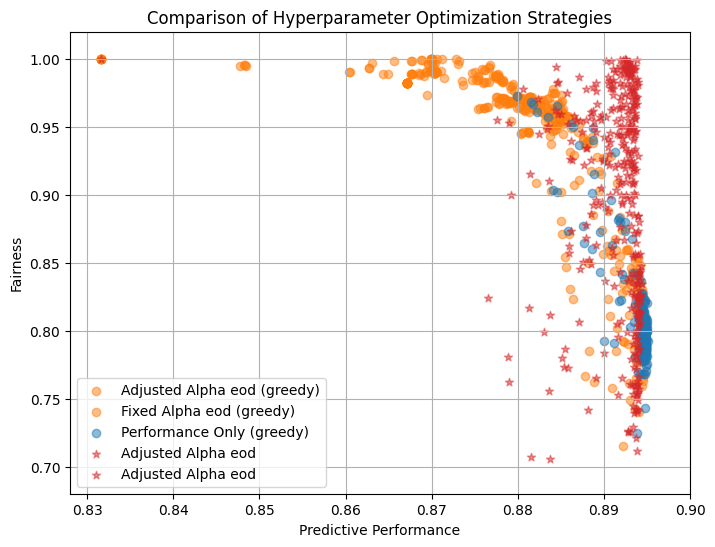

In [ ]:
# prompt: scatter plot three files with bacc_test and eor_test
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


seed = 1111
version = 11
results_df1 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_performance_only_{seed}_{version}.csv")
results_df2 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_fixed_alpha_eod_{seed}_{version}.csv")
results_df3 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_adjusted_alpha_eod_{seed}_{version}.csv")

results_df4 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_performance_only_1111_10.csv")
results_df5 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_fixed_alpha_eod_1111_10.csv")
results_df6 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_adjusted_alpha_eod_1111_10.csv")

# results_df4 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_performance_only_42_2.csv")
# results_df5 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_fixed_alpha_eod_42_2.csv")
# results_df6 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_adjusted_alpha_eod_42_2.csv")

results_df11 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_performance_only_resampling_mean_{seed}_{version}.csv")
results_df11 = results_df11[ 0.05/(0.05 + np.abs(results_df11['EOD Val'])) > 0.7]
results_df12 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_fixed_alpha_eod_resampling_mean_{seed}_{version}.csv")
results_df12 = results_df12[ 0.05/(0.05 + np.abs(results_df12['EOD Val'])) > 0.7]
results_df13 = pd.read_csv(f"/content/drive/MyDrive/math6912/results/hpt_adjusted_alpha_eod_resampling_mean_{seed}_12.csv")
results_df13 = results_df13[ 0.05/(0.05 + np.abs(results_df13['EOD Val'])) > 0.7]


# Create the scatter plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
cmap = plt.get_cmap("tab10")


plt.scatter(results_df3['Accuracy Test'], 0.05/(0.05 + np.abs(results_df3['EOD Test'])), label='Adjusted Alpha eod (greedy)', color=cmap(1), alpha=0.5)
plt.scatter(results_df2['Accuracy Test'], 0.05/(0.05 + np.abs(results_df2['EOD Test'])), label='Fixed Alpha eod (greedy)', color=cmap(1), alpha=0.5)
plt.scatter(results_df1['Accuracy Test'], 0.05/(0.05 + np.abs(results_df1['EOD Test'])), label='Performance Only (greedy)', color=cmap(0), alpha=0.5)

# plt.scatter(results_df6['Accuracy Test'], 0.05/(0.05 + np.abs(results_df6['EOD Test'])), label='Adjusted Alpha eod (importance)', color=cmap(2), alpha=0.5, marker="*")
# plt.scatter(results_df5['Accuracy Test'], 0.05/(0.05 + np.abs(results_df5['EOD Test'])), label='Fixed Alpha eod (importance)', color=cmap(1), alpha=0.5, marker="*")
# plt.scatter(results_df4['Accuracy Test'], 0.05/(0.05 + np.abs(results_df4['EOD Test'])), label='Performance Only (importance)', color=cmap(0), alpha=0.5, marker="*")


# plt.scatter(results_df12['Accuracy Test'], 0.05/(0.05 + np.abs(results_df12['EOD Test'])), label='Fixed Alpha eod', color=cmap(3), alpha=0.5, marker="*")
plt.scatter(results_df11['Accuracy Test'], 0.05/(0.05 + np.abs(results_df11['EOD Test'])), label='Adjusted Alpha eod', color=cmap(3), alpha=0.5, marker="*")
plt.scatter(results_df13['Accuracy Test'], 0.05/(0.05 + np.abs(results_df13['EOD Test'])), label='Adjusted Alpha eod', color=cmap(3), alpha=0.5, marker="*")
# plt.scatter(results_df4['Bacc Test'], 0.05/(0.05 + results_df4['EOD Test']), label='Performance Only', color=cmap(0), alpha=0.5)

# Customize the plot
plt.xlabel('Predictive Performance')
plt.ylabel('Fairness')
plt.ylim(0.68, 1.02)
plt.xlim(0.828, 0.9)
plt.title('Comparison of Hyperparameter Optimization Strategies')
plt.legend()  # Show legend to identify data points
plt.grid(True)  # Add a grid for better readability

plt.show()